# Machine Learning Engineer Nanodegree
### Capstone Project code notebook
--------------------------
Anderas Lewitzki<br>
February 02, 2019
## Realtime contextual and passive network outage detection
----------------

#### Project paper @ https://github.com/std3rr/realtime_contextual_and_passive_outage_detection/project_paper.pdf

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

In [2]:
sparse_data = pd.read_csv("sparse_opYcityX.csv", sep=';', names=['ts','zip','dhcp','call'])

In [3]:
sparse_data.head()

,ts,zip,dhcp,call
0,1539913440,166225,1,0
1,1539913500,166225,2,0
2,1539913560,166225,0,0
3,1539913620,166225,1,0
4,1539913680,166225,0,0


### Data exploration

#### Lets check the number of areas in our test population

In [4]:
print("Number of unique areas: {}".format( len( sparse_data['zip'].unique() )))

Number of unique areas: 141


#### Lets visualize the discrete minute by minute pattern of DHCP requests from devices.

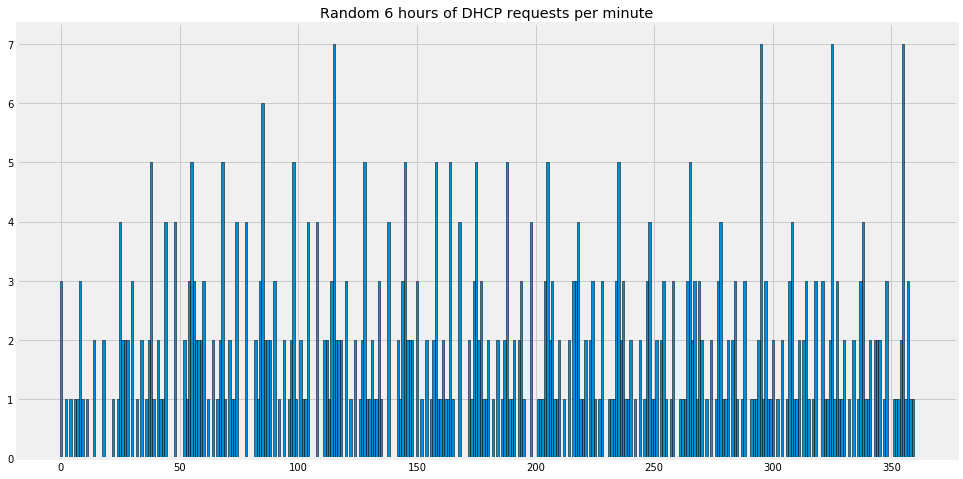

In [5]:
samples = sparse_data[40000:40360].copy().reset_index().dhcp
plt.figure(figsize=(15, 8))
plt.title("Random 6 hours of DHCP requests per minute")
plt.bar( range(0,len(samples)), samples, width=1, edgecolor='black'  )
plt.show()

#### Heated pixelmap visualization

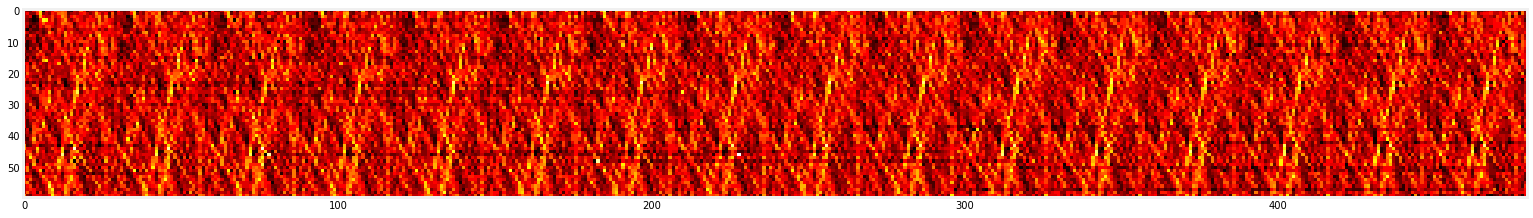

In [11]:
start = 0
width = 60
height = 480
end   = start+(width*height)
plt.figure(figsize=(24, 12))
plt.grid(False)
d = sparse_data[sparse_data['zip'] == 166280]
plt.imshow(np.reshape( [d[start:end].copy().reset_index().dhcp],(width,height) ), cmap="hot")
# approximate population 209

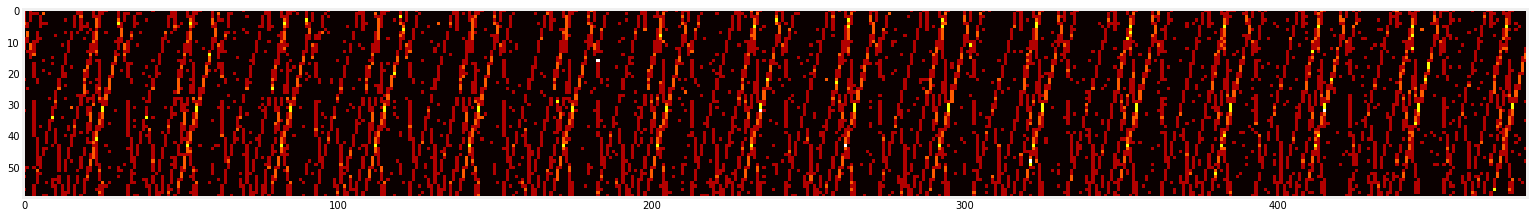

In [13]:
start = 0
width = 60
height = 480
end   = start+(width*height)
plt.figure(figsize=(24, 12))
plt.grid(False)
d = sparse_data[sparse_data['zip'] == 165847]
plt.imshow(np.reshape( [d[start:end].copy().reset_index().dhcp],(width,height) ), cmap="hot")
# approximate population 8

#### Frequency analysis.
Our hypothesis and prediction is that it is half the configured lease time of 3600 seconds.<br>
<br>
First I'll create a function that tries to resolve the most probable frequency.
My thinking is that as this data constitutes a recurring pattern.
So for every frequency tested every minute within the window needs to be descrete.<br>
If I calculate the spread of data within every discrete minute, the frequency with least spread should reveal the most significant and probable frequency.<br>


In [14]:
def min_std_interval( dlist, MIN_WINDOW_SIZE = 1, MAX_WINDOW_SIZE = 120 ):
    
    # lets use twice the maximum window size as scan size
    # this way we allways have at least two intervals to analyze
    MAX_SCAN_SIZE = MAX_WINDOW_SIZE * 2

    std_means = []
    # For every window size or interval frequence we want to test...
    for wsize in range( MIN_WINDOW_SIZE, MAX_WINDOW_SIZE ):

        std = []
        # ..scan up to MAX_SCAN_SIZE ( minutes ) ..
        for i in range( 0, MAX_SCAN_SIZE, 1 ):
            # ..extract the predicted frequency index pattern..
            ar = list(range( 0+i, i+(wsize*10), wsize ))
            # ..append the standard deviation of our window on assumed window size..
            std.append( np.std( dlist[ ar ] ) )
            
        # ..get the mean average of the spread recorded for this window size 
        std_means.append(np.mean(std))
    
    # ..return the argmin of all tested window sizes.
    # That is the window size that gave us the least spread when applied
    val, idx = min((val, idx) for (idx, val) in enumerate(std_means))
    return idx+1

In [15]:
pd.to_datetime(sparse_data.ts[25600],unit='s')

Timestamp('2018-11-05 20:24:00')

#### Lets test and analyse population, frequency, coverage per zip code area

In [16]:
OFFSET = 25600 # 2018-11-05 20:24:00
analys = []
for zip_code in sparse_data['zip'].unique():
    d = sparse_data[sparse_data['zip'] == zip_code].copy().reset_index()

    freq = min_std_interval( np.array( d[OFFSET:OFFSET+OFFSET].dhcp.copy() ) )
    sum_dhcp = d[OFFSET:OFFSET+freq].dhcp.sum()
    coverage = np.round( np.sum( d[OFFSET:OFFSET+freq].dhcp > 0 ) / freq, 2 )
    analys.append([zip_code, freq, sum_dhcp, coverage, np.sum( d.call )])
    print("ZIP: {}, Population: {}, Freq: {}, Coverage: {}".format( zip_code, sum_dhcp, freq, coverage ))

ZIP: 166225, Population: 50, Freq: 30, Coverage: 0.7
ZIP: 172203, Population: 11, Freq: 30, Coverage: 0.3
ZIP: 165587, Population: 28, Freq: 30, Coverage: 0.6
ZIP: 166272, Population: 187, Freq: 30, Coverage: 1.0
ZIP: 166052, Population: 2, Freq: 30, Coverage: 0.07
ZIP: 165523, Population: 4, Freq: 30, Coverage: 0.07
ZIP: 165947, Population: 19, Freq: 60, Coverage: 0.28
ZIP: 152978, Population: 1, Freq: 30, Coverage: 0.03
ZIP: 165855, Population: 28, Freq: 30, Coverage: 0.53
ZIP: 172068, Population: 53, Freq: 30, Coverage: 0.83
ZIP: 166071, Population: 21, Freq: 30, Coverage: 0.37
ZIP: 166224, Population: 187, Freq: 30, Coverage: 0.9
ZIP: 165357, Population: 87, Freq: 30, Coverage: 0.87
ZIP: 165956, Population: 3, Freq: 30, Coverage: 0.1
ZIP: 166072, Population: 55, Freq: 30, Coverage: 0.8
ZIP: 152875, Population: 4, Freq: 60, Coverage: 0.07
ZIP: 172120, Population: 39, Freq: 30, Coverage: 0.6
ZIP: 165458, Population: 19, Freq: 30, Coverage: 0.4
ZIP: 165946, Population: 1, Freq: 30, Co

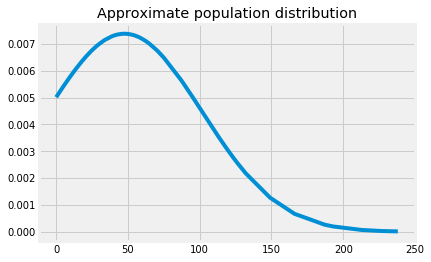

In [17]:
population = np.sort( [x[2] for x in analys] )
popmean = np.mean(population)
popstd = np.std(population)
pdf = stats.norm.pdf(population, popmean, popstd)
plt.title("Approximate population distribution")
plt.plot(population, pdf)
plt.show()

In [18]:
pd.Series(population).describe().round(0).astype(np.int)

count    141
mean      48
std       54
min        0
25%        7
50%       26
75%       69
max      238
dtype: int32

In [19]:
print("Number of areas with coverage over 20%: {} of {}".format(len([x[0] for x in analys if x[-2] >= .20]), len(analys)))
cov_pop = sum([x[2] for x in analys if x[-2] >= .20])
tot_pop= sum([x[2] for x in analys])
print("Population coverage: {}%".format(np.round((cov_pop/tot_pop)*100,2)))
cov_calls = sum( [x[-1] for x in analys if x[-2] >= .20] )
tot_calls = sum([x[-1] for x in analys])
print("Call coverage: {}%".format(np.round((cov_calls/tot_calls)*100,2)))

Number of areas with coverage over 20%: 103 of 141
Population coverage: 98.33%
Call coverage: 99.15%


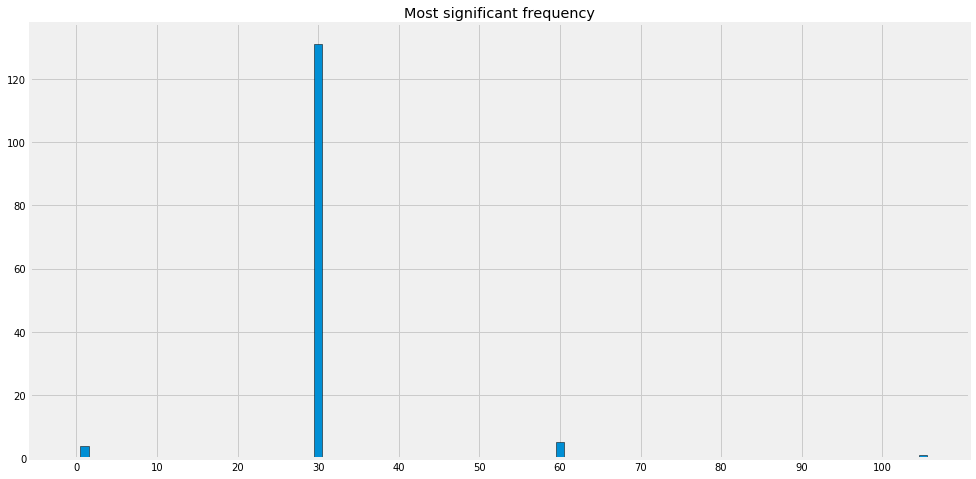

In [20]:
freq_cnt = np.bincount([x[1] for x in analys])
plt.figure(figsize=(15, 8))
plt.title("Most significant frequency")
plt.bar(np.arange(0, len(freq_cnt)), freq_cnt, width=1, edgecolor='black'  )
plt.xticks( np.arange(0, len(freq_cnt) ,10))
plt.show()

In [21]:
missclassified_areas = len([x[0] for x in analys if x[-2] >= .20 and x[1] != 30])
print( "{} in {} areas missclassified".format( missclassified_areas, len(analys) ) )

1 in 141 areas missclassified


In [63]:
def replay_moving_average(data, 
             step_size=1, 
             window_size=30, 
             lookbehind=(12*60),
             anomaly_threshold = .0,
             detect_threshold = 10, #minutes
             decline_threshold = 30, #minutes
             clear_threshold=(12*60) ):
    """replay minute measures through a sliding window.
    
    Keyword arguments:
    data              -- pandas data serie
    step_size         -- indices moving forward per itteration
    window_size       -- size of the window / interval
    lookbehind        -- post detection timespan to scan
    anomaly_threshold -- multiple against mean average to trigger
    detect_threshold  -- minutes suppression before detect event
    decline_threshold -- minutes threshold
    clear_threshold   -- minutes until clear event after anomaly end
    """

    skip_indices = []
    ticks = []
    events = []
    
    tick = 0
    count = 0
    anomaly_start = 0
    
    print("index0:{}, lookbehind:{}, len(data):{}".format(data.index[0], lookbehind, len(data)))
    start = lookbehind + data.index[0]
    end = len(data) + ( data.index[0] )
    
    print(f'processing {start}, {end}, {step_size}')

    for right in range( start, end, step_size ):
        
        # adjust the lookbehind dynamicaly depending on anomaly indices, which we skip
        _lookbehind = lookbehind + len(skip_indices)
        
        left = right - _lookbehind
        
        window = list(range( left, right, window_size ))
        
        # this is the magic .. 
        # .. get the mean average of all frequency dependant minute buckets like this, 
        # but skip anomaly detected indices 
        avg = np.mean( data.dhcp[ [x for x in window[:-1] if x is not skip_indices] ] )
        last = data.dhcp[right]
        # last measurement multiple of the average
        mul = last/avg if avg and last else 0.0
        # get current anomaly length in minutes
        cur_anomaly_len = (data.ts[right] - anomaly_start)//60 if anomaly_start > 0 else 0
        
        # anomaly tick coverage and event triggers
        if mul <= anomaly_threshold:
            
            if avg != 0.0 or anomaly_start > 0:
                # cap the tick at max tick_supression limit when active
                tick = min( tick+1, detect_threshold )
                skip_indices.append(right)
                if anomaly_start == 0 and tick == detect_threshold:
                    anomaly_start = data.ts[skip_indices[0]]
                    # append indices for start, detect, end, clear
                    # current 'end' and 'clear' gets inititalized as far end
                    events.append( {
                        'start' :skip_indices[0], 
                        'detect':right, 
                        'end'   :end, 
                        'clear' :end 
                    })
                    print("detected anomaly @ {} started @ {}, idx:{}".format(
                        pd.to_datetime(data.ts[right],unit='s'),
                        pd.to_datetime(anomaly_start,unit='s'), right
                    ))        
        elif mul > anomaly_threshold and anomaly_start > 0:
            skip_indices.clear()
            tick = 0

            if cur_anomaly_len  >= clear_threshold:
                events[-1]['clear'] = right
                print("cleared anomaly @ {} started @ {}".format(
                    pd.to_datetime(data.ts[right],unit='s'),
                    pd.to_datetime(anomaly_start,unit='s')
                ))
                anomaly_start = 0
            elif cur_anomaly_len < decline_threshold:
                    print("decline anomaly @ {} started @ {} idx:{}, len:{}, thres:{}".format(
                        pd.to_datetime(data.ts[right],unit='s'),
                        pd.to_datetime(anomaly_start,unit='s'), right,
                        cur_anomaly_len, decline_threshold
                    ))
                    # event gets cleared
                    events.pop()
                    anomaly_start = 0

            elif events[-1]['end'] == end:
                events[-1]['end'] = right
                print("end anomaly after {} minutes".format( cur_anomaly_len ))

                
        ticks.append(tick)
        count += 1
    return events


In [58]:
def generate_total_outage_dhcp( data, from_minute, to_minute ):
        """Generate total outage 'dhcp'.
            which means setting all measures to zero at indices span.
            print debug.
           
           Arguments:
           data        -- pandas data serie
           from_minute -- outage start minute 
           to_minute   -- outage end minute
        """
    
        print("Simulating dhcp requests outage @ {}, clearing {}".format(
            pd.to_datetime(d.at[from_minute,'ts'],unit='s'),
            pd.to_datetime(d.at[to_minute,'ts'],unit='s')
        ))
        d.at[from_minute:to_minute,'dhcp'] = 0


#### Bellow we specify a 35 hour replay and loop through all zip codes and simulate a 2 hour complete outage

ZIP: 166225, Population: 50, Freq: 30, coverage: 0.7
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


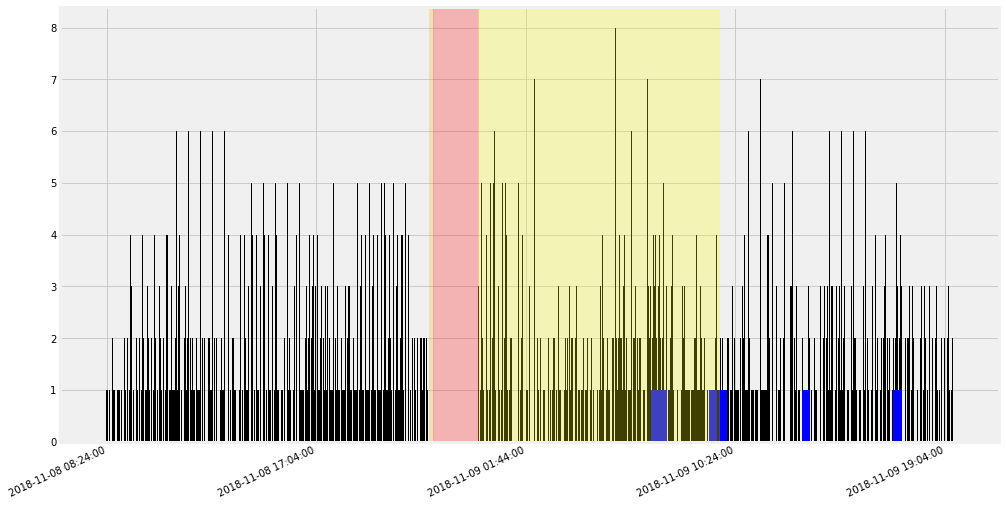

ZIP: 172203, Population: 11, Freq: 30, coverage: 0.3
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:55:00 started @ 2018-11-08 20:46:00 (29951)
decline anomaly @ 2018-11-08 20:57:00 started @ 2018-11-08 20:46:00 idx:29953, len:11, thres:30
detected anomaly @ 2018-11-08 21:25:00 started @ 2018-11-08 21:16:00 (29981)
decline anomaly @ 2018-11-08 21:27:00 started @ 2018-11-08 21:16:00 idx:29983, len:11, thres:30
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 13:45:00 started @ 2018-11-08 21:43:00
detected anomaly @ 2018-11-09 16:24:00 started @ 2018-11-09 16:15:00 (31120)
decline anomaly @ 2018-11-09 16:25:00 started @ 2018-11-09 16:15:00 idx:31121, len:10, thres:30
detected anomaly @ 2018-11-09 16:54:00 started @ 2018-11-09 16:45:00 (31150)
decline anomaly @ 20

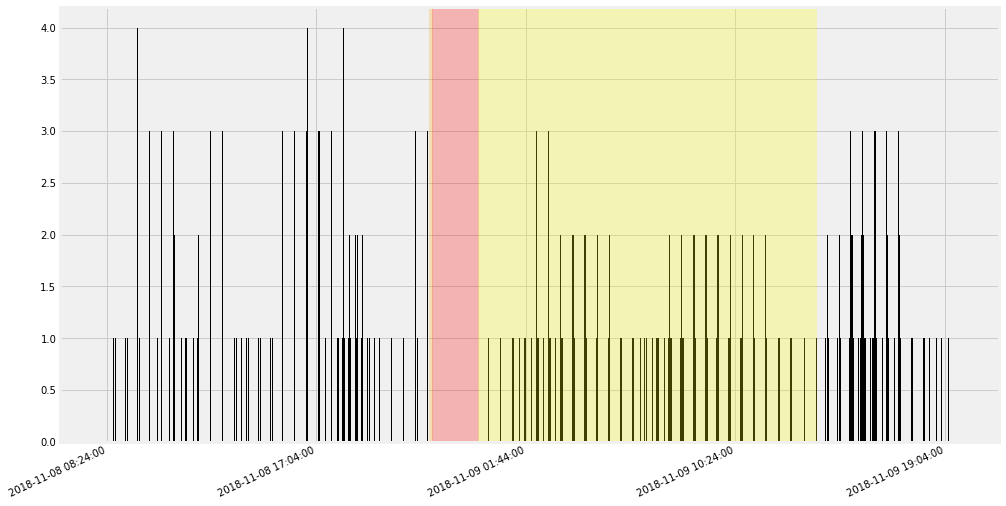

ZIP: 165587, Population: 28, Freq: 30, coverage: 0.6
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:54:00 started @ 2018-11-08 21:45:00 (30010)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 09:46:00 started @ 2018-11-08 21:45:00
[{'start': 30001, 'detect': 30010, 'end': 30121, 'clear': 30722}]


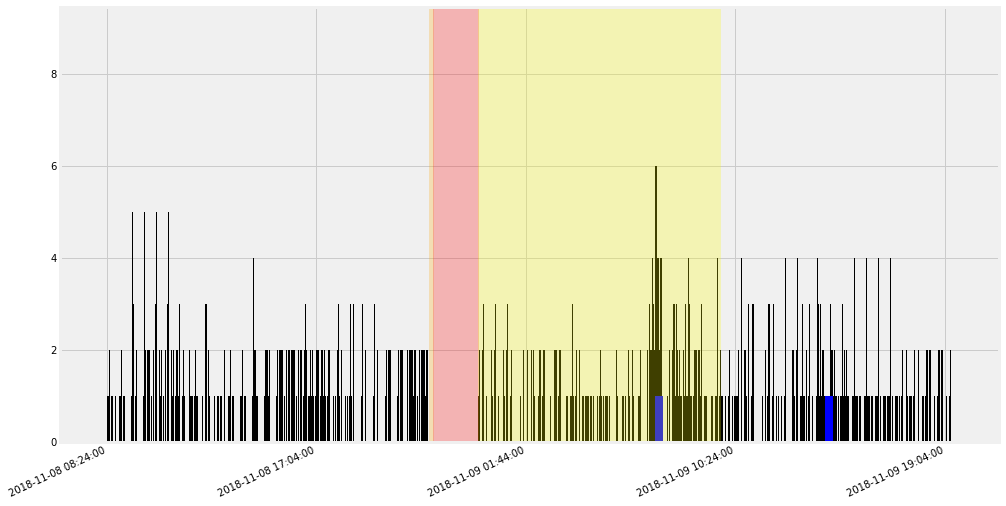

ZIP: 166272, Population: 374, Freq: 60, coverage: 1.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


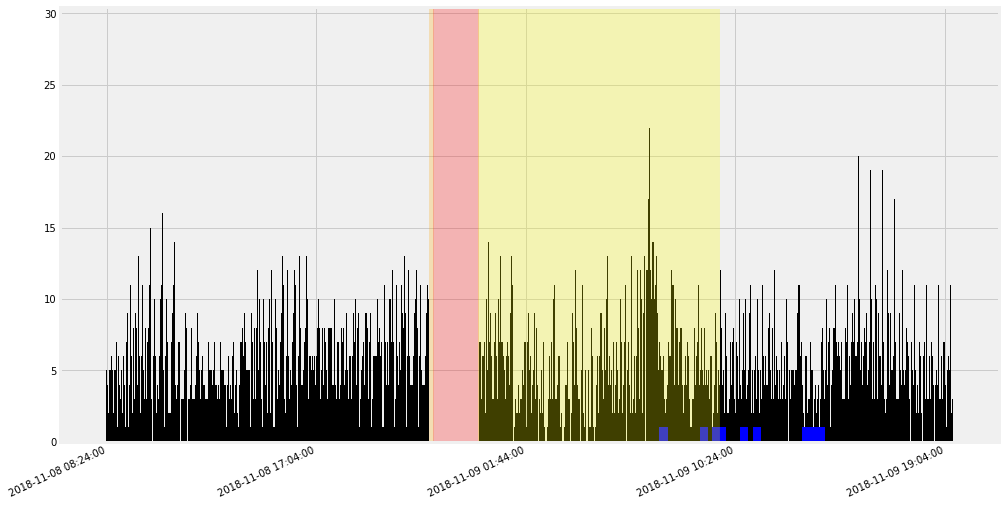

ZIP: 166052, Population: 2, Freq: 30, coverage: 0.07
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:55:00 started @ 2018-11-08 20:46:00 (29951)
decline anomaly @ 2018-11-08 21:01:00 started @ 2018-11-08 20:46:00 idx:29957, len:15, thres:30
detected anomaly @ 2018-11-08 21:11:00 started @ 2018-11-08 21:02:00 (29967)
decline anomaly @ 2018-11-08 21:31:00 started @ 2018-11-08 21:02:00 idx:29987, len:29, thres:30
detected anomaly @ 2018-11-08 21:41:00 started @ 2018-11-08 21:32:00 (29997)
end anomaly after 148 minutes
cleared anomaly @ 2018-11-09 09:41:00 started @ 2018-11-08 21:32:00
detected anomaly @ 2018-11-09 09:51:00 started @ 2018-11-09 09:42:00 (30727)
decline anomaly @ 2018-11-09 09:56:00 started @ 2018-11-09 09:42:00 idx:30732, len:14, thres:30
detected anomaly @ 2018-11-09 10:07:00 started @ 2018-11-09 09:58:00 (30743)
decline anomaly @ 20

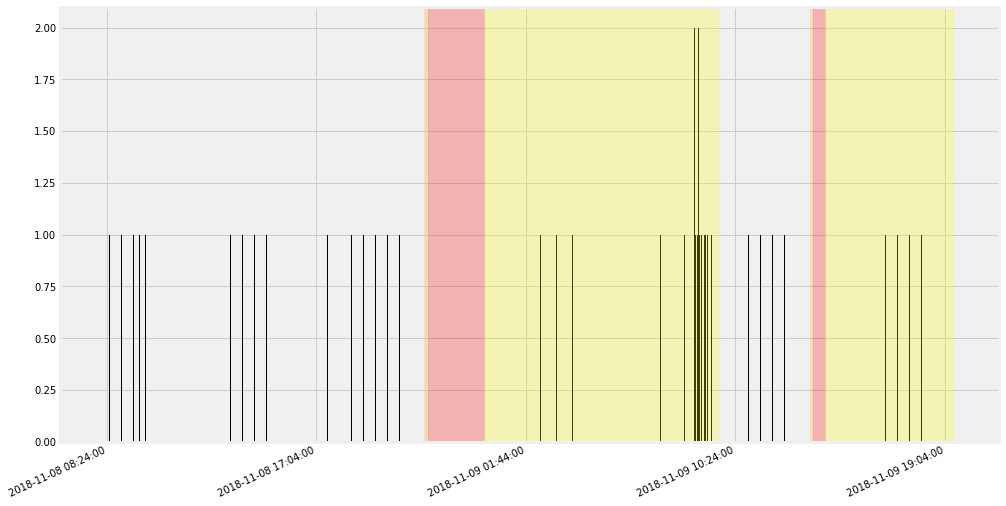

ZIP: 165523, Population: 4, Freq: 30, coverage: 0.07
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:35:00 started @ 2018-11-08 20:26:00 (29931)
decline anomaly @ 2018-11-08 20:37:00 started @ 2018-11-08 20:26:00 idx:29933, len:11, thres:30
detected anomaly @ 2018-11-08 21:05:00 started @ 2018-11-08 20:56:00 (29961)
decline anomaly @ 2018-11-08 21:07:00 started @ 2018-11-08 20:56:00 idx:29963, len:11, thres:30
detected anomaly @ 2018-11-08 21:35:00 started @ 2018-11-08 21:26:00 (29991)
decline anomaly @ 2018-11-08 21:37:00 started @ 2018-11-08 21:26:00 idx:29993, len:11, thres:30
detected anomaly @ 2018-11-08 22:04:00 started @ 2018-11-08 21:55:00 (30020)
end anomaly after 120 minutes
[{'start': 30011, 'detect': 30020, 'end': 30131, 'clear': 31300}]


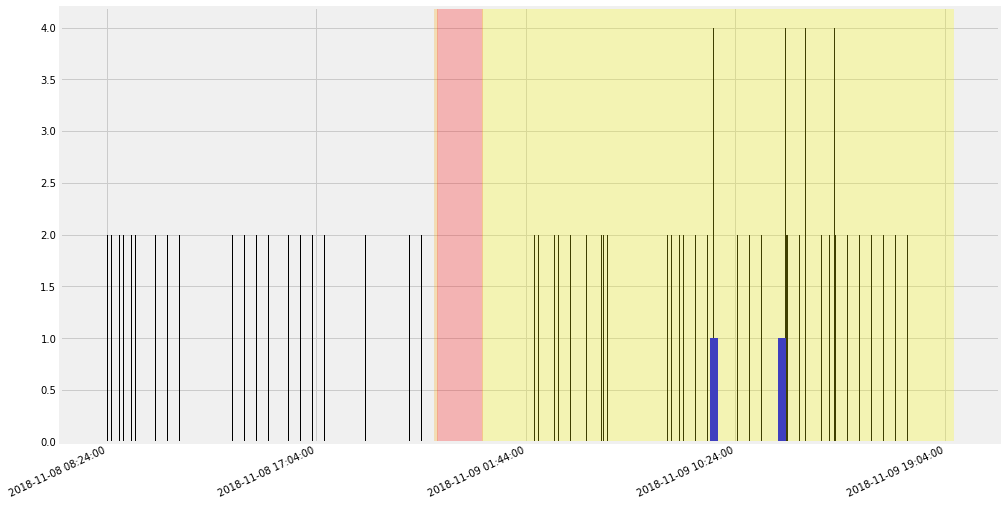

ZIP: 165947, Population: 9, Freq: 30, coverage: 0.27
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 124 minutes
cleared anomaly @ 2018-11-09 09:46:00 started @ 2018-11-08 21:43:00
detected anomaly @ 2018-11-09 13:38:00 started @ 2018-11-09 13:29:00 (30954)
decline anomaly @ 2018-11-09 13:49:00 started @ 2018-11-09 13:29:00 idx:30965, len:20, thres:30
detected anomaly @ 2018-11-09 19:17:00 started @ 2018-11-09 19:08:00 (31293)
decline anomaly @ 2018-11-09 19:19:00 started @ 2018-11-09 19:08:00 idx:31295, len:11, thres:30
[{'start': 29999, 'detect': 30008, 'end': 30123, 'clear': 30722}]


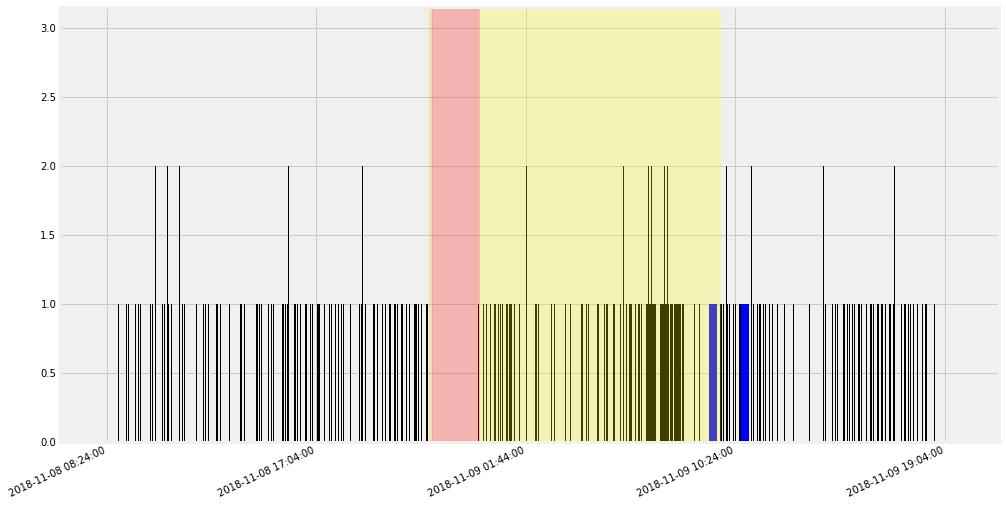

ZIP: 152978, Population: 3, Freq: 90, coverage: 0.03
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 150 minutes
[{'start': 30000, 'detect': 30009, 'end': 30150, 'clear': 31300}]


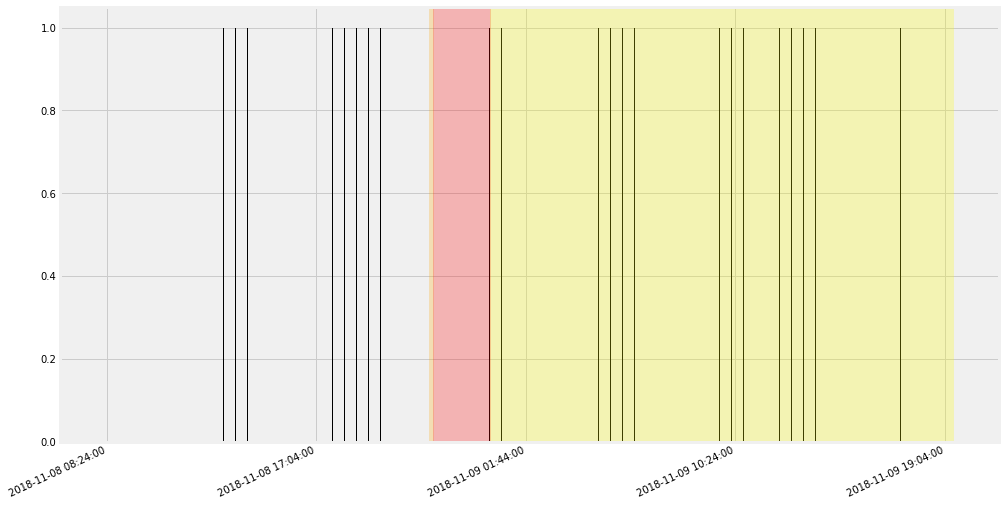

ZIP: 165855, Population: 56, Freq: 60, coverage: 0.53
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 123 minutes
cleared anomaly @ 2018-11-09 09:46:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 10:12:00 started @ 2018-11-09 10:03:00 (30748)
decline anomaly @ 2018-11-09 10:13:00 started @ 2018-11-09 10:03:00 idx:30749, len:10, thres:30
detected anomaly @ 2018-11-09 11:30:00 started @ 2018-11-09 11:21:00 (30826)
decline anomaly @ 2018-11-09 11:35:00 started @ 2018-11-09 11:21:00 idx:30831, len:14, thres:30
[{'start': 30000, 'detect': 30009, 'end': 30123, 'clear': 30722}]


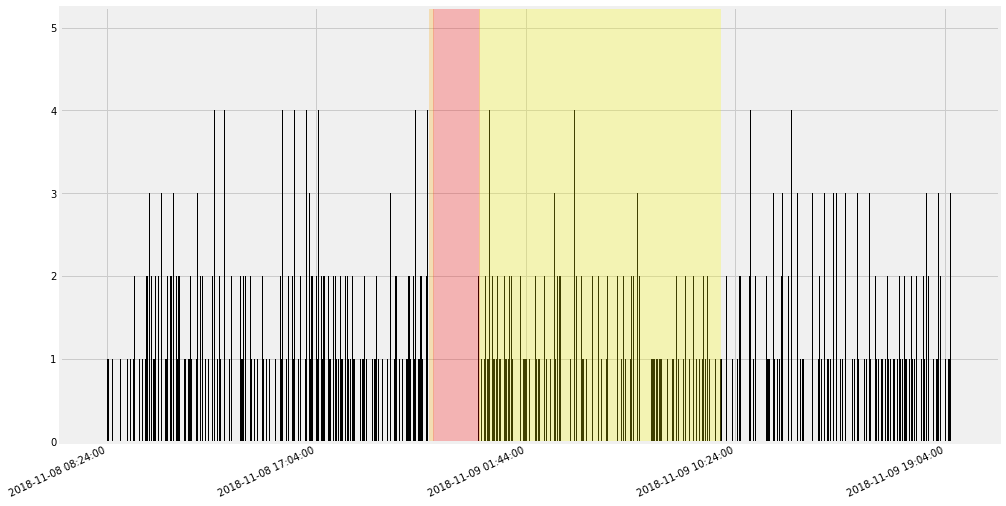

ZIP: 172068, Population: 53, Freq: 30, coverage: 0.83
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:07:00 started @ 2018-11-08 20:58:00 (29963)
decline anomaly @ 2018-11-08 21:10:00 started @ 2018-11-08 20:58:00 idx:29966, len:12, thres:30
detected anomaly @ 2018-11-08 21:37:00 started @ 2018-11-08 21:28:00 (29993)
decline anomaly @ 2018-11-08 21:40:00 started @ 2018-11-08 21:28:00 idx:29996, len:12, thres:30
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 11:59:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30855}]


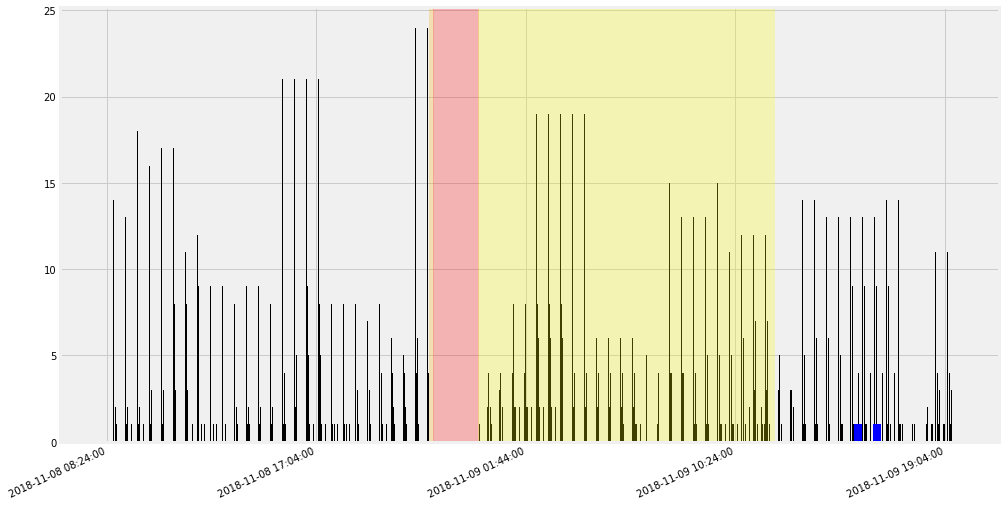

ZIP: 166071, Population: 21, Freq: 30, coverage: 0.37
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:50:00 started @ 2018-11-08 21:41:00 (30006)
end anomaly after 125 minutes
cleared anomaly @ 2018-11-09 09:41:00 started @ 2018-11-08 21:41:00
[{'start': 29997, 'detect': 30006, 'end': 30122, 'clear': 30717}]


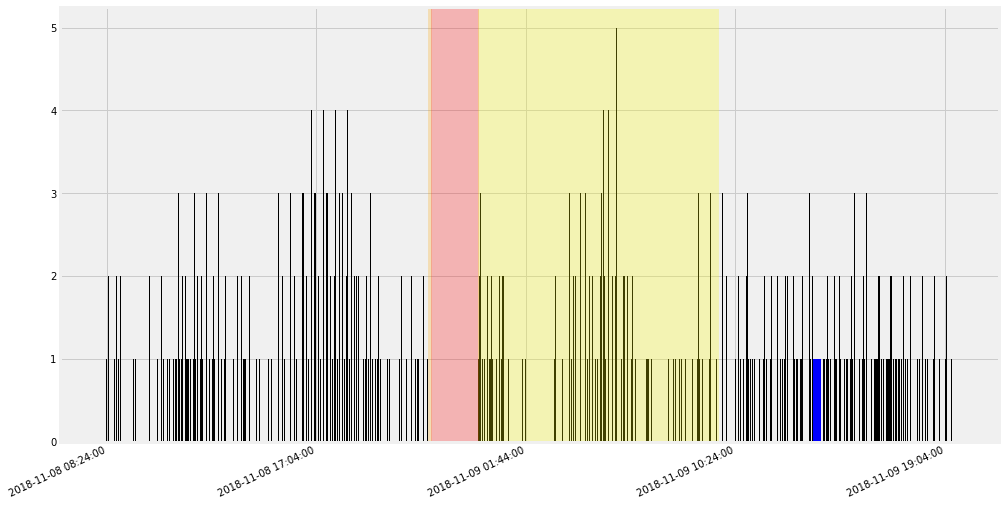

ZIP: 166224, Population: 187, Freq: 30, coverage: 0.9
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


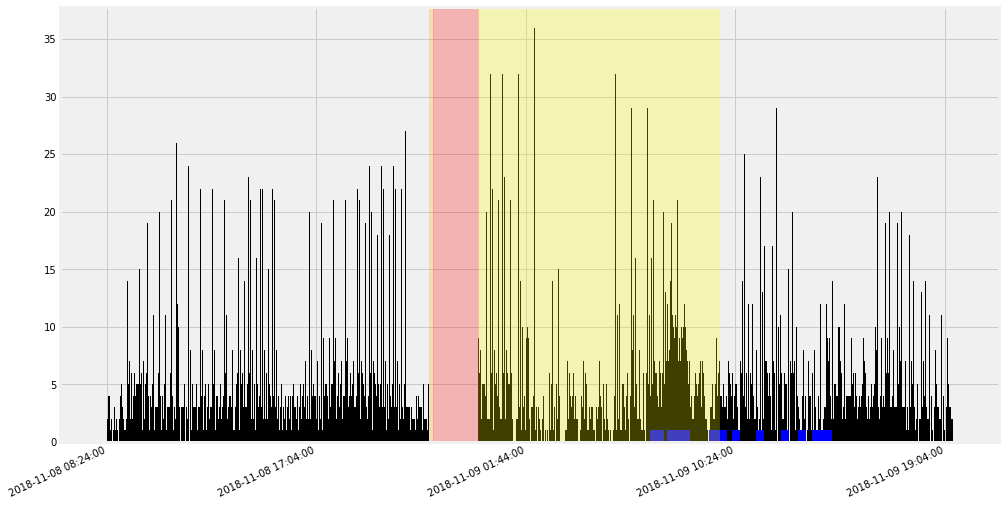

ZIP: 165357, Population: 87, Freq: 30, coverage: 0.87
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


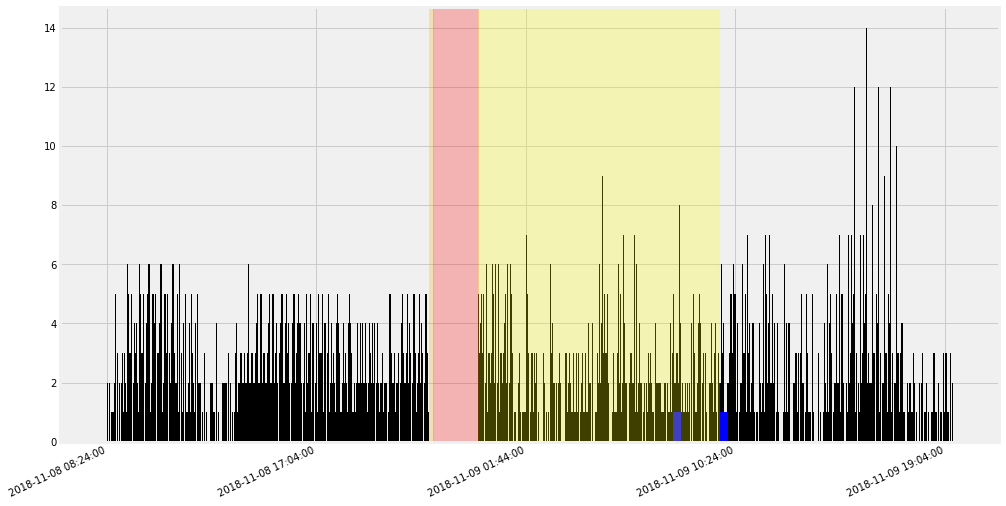

ZIP: 165956, Population: 6, Freq: 60, coverage: 0.1
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:15:00 started @ 2018-11-08 22:06:00 (30031)
end anomaly after 120 minutes
[{'start': 30022, 'detect': 30031, 'end': 30142, 'clear': 31300}]


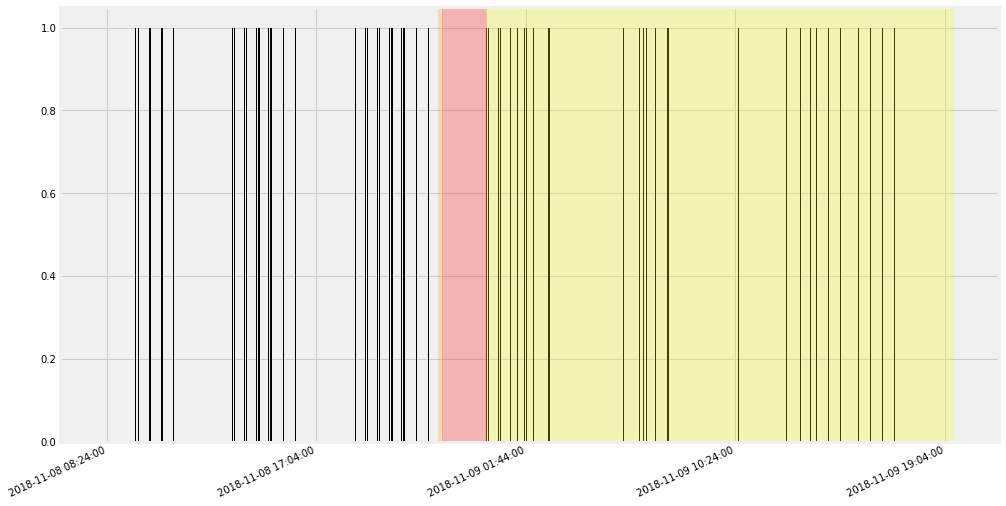

ZIP: 166072, Population: 55, Freq: 30, coverage: 0.8
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


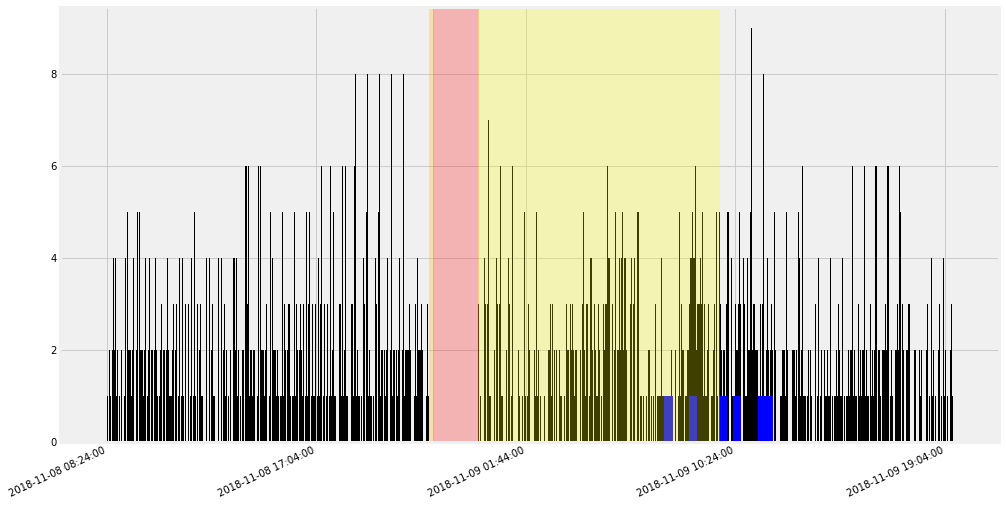

ZIP: 152875, Population: 4, Freq: 60, coverage: 0.07
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:13:00 started @ 2018-11-08 22:04:00 (30029)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 16:05:00 started @ 2018-11-08 22:04:00
detected anomaly @ 2018-11-09 17:45:00 started @ 2018-11-09 17:36:00 (31201)
decline anomaly @ 2018-11-09 18:05:00 started @ 2018-11-09 17:36:00 idx:31221, len:29, thres:30
[{'start': 30020, 'detect': 30029, 'end': 30141, 'clear': 31101}]


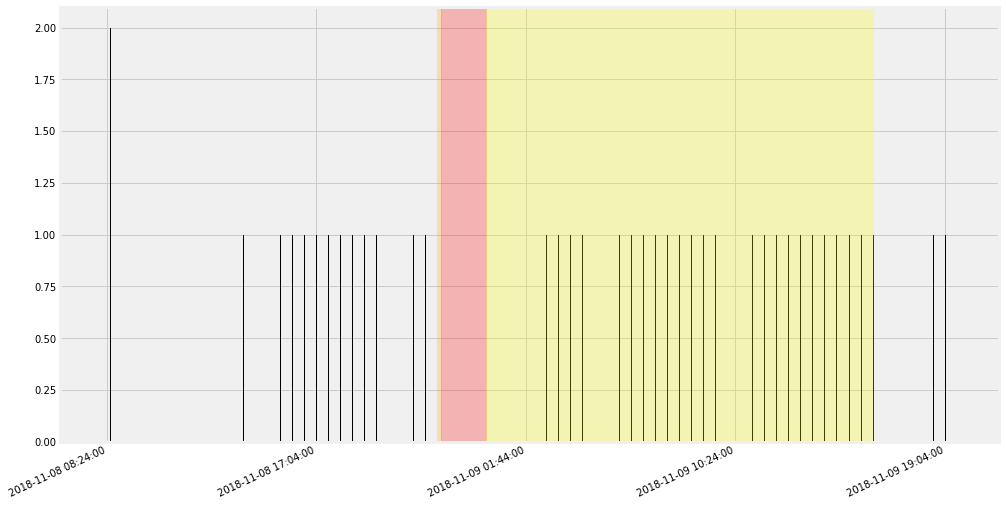

ZIP: 172120, Population: 39, Freq: 30, coverage: 0.6
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:55:00 started @ 2018-11-08 20:46:00 (29951)
decline anomaly @ 2018-11-08 20:57:00 started @ 2018-11-08 20:46:00 idx:29953, len:11, thres:30
detected anomaly @ 2018-11-08 21:25:00 started @ 2018-11-08 21:16:00 (29981)
decline anomaly @ 2018-11-08 21:27:00 started @ 2018-11-08 21:16:00 idx:29983, len:11, thres:30
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 11:30:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 18:55:00 started @ 2018-11-09 18:46:00 (31271)
decline anomaly @ 2018-11-09 18:59:00 started @ 2018-11-09 18:46:00 idx:31275, len:13, thres:30
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30826}]


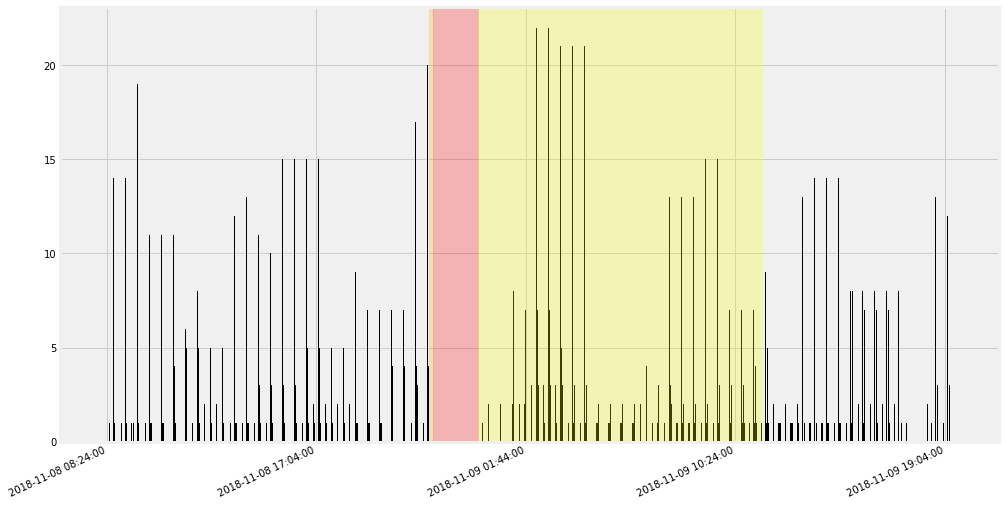

ZIP: 165458, Population: 19, Freq: 30, coverage: 0.4
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:56:00 started @ 2018-11-08 21:47:00 (30012)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 10:23:00 started @ 2018-11-08 21:47:00
detected anomaly @ 2018-11-09 12:18:00 started @ 2018-11-09 12:09:00 (30874)
decline anomaly @ 2018-11-09 12:23:00 started @ 2018-11-09 12:09:00 idx:30879, len:14, thres:30
detected anomaly @ 2018-11-09 13:21:00 started @ 2018-11-09 13:12:00 (30937)
decline anomaly @ 2018-11-09 13:22:00 started @ 2018-11-09 13:12:00 idx:30938, len:10, thres:30
detected anomaly @ 2018-11-09 18:56:00 started @ 2018-11-09 18:47:00 (31272)
decline anomaly @ 2018-11-09 19:01:00 started @ 2018-11-09 18:47:00 idx:31277, len:14, thres:30
[{'start': 30003, 'detect': 30012, 'end': 30123, 'clear': 30759}]


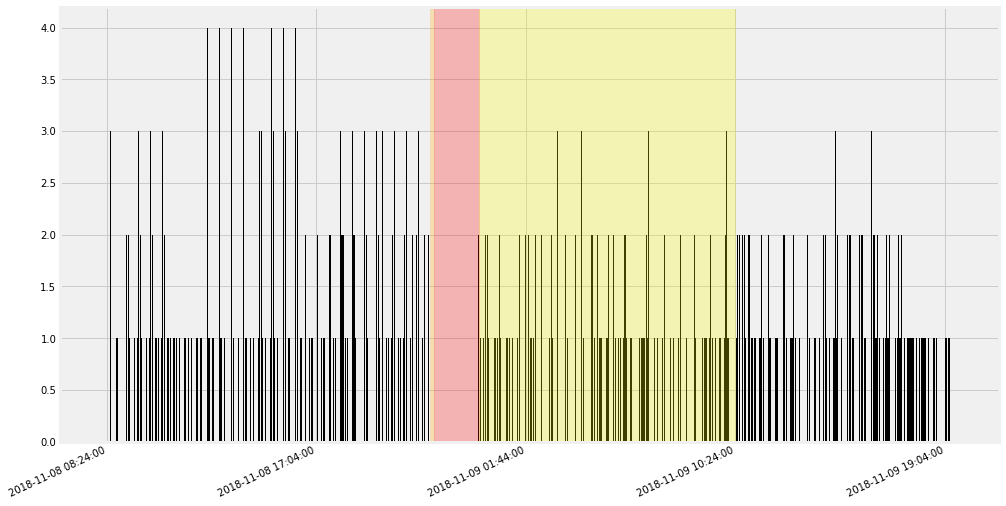

ZIP: 165946, Population: 1, Freq: 30, coverage: 0.03
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:10:00 started @ 2018-11-08 22:01:00 (30026)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 10:35:00 started @ 2018-11-08 22:01:00
detected anomaly @ 2018-11-09 11:00:00 started @ 2018-11-09 10:51:00 (30796)
decline anomaly @ 2018-11-09 11:12:00 started @ 2018-11-09 10:51:00 idx:30808, len:21, thres:30
detected anomaly @ 2018-11-09 11:23:00 started @ 2018-11-09 11:14:00 (30819)
decline anomaly @ 2018-11-09 11:42:00 started @ 2018-11-09 11:14:00 idx:30838, len:28, thres:30
detected anomaly @ 2018-11-09 11:53:00 started @ 2018-11-09 11:44:00 (30849)
decline anomaly @ 2018-11-09 12:12:00 started @ 2018-11-09 11:44:00 idx:30868, len:28, thres:30
detected anomaly @ 2018-11-09 12:23:00 started @ 2018-11-09 12:14:00 (30879)
decline anomaly @ 20

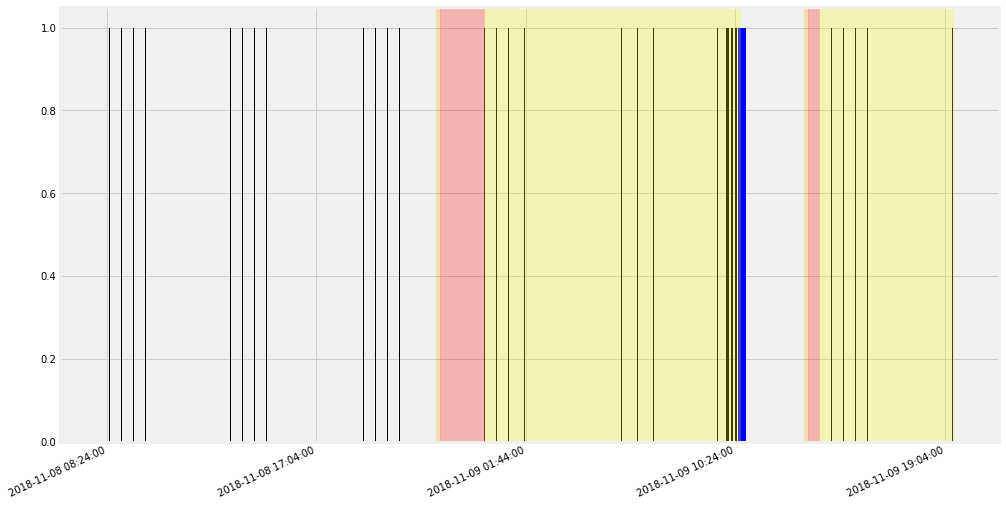

ZIP: 120854, Population: 0, Freq: 1, coverage: 0.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
[]


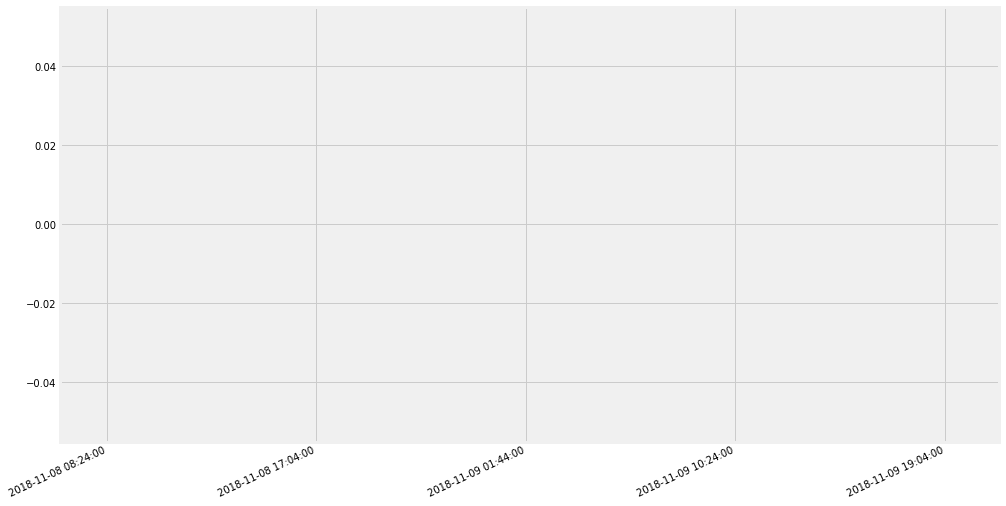

ZIP: 166274, Population: 95, Freq: 30, coverage: 0.97
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


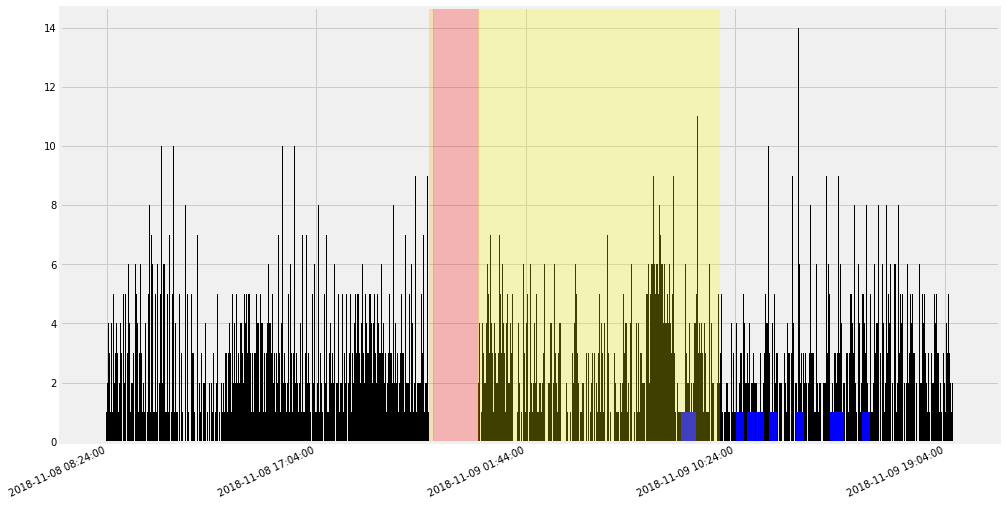

ZIP: 164647, Population: 166, Freq: 30, coverage: 0.97
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


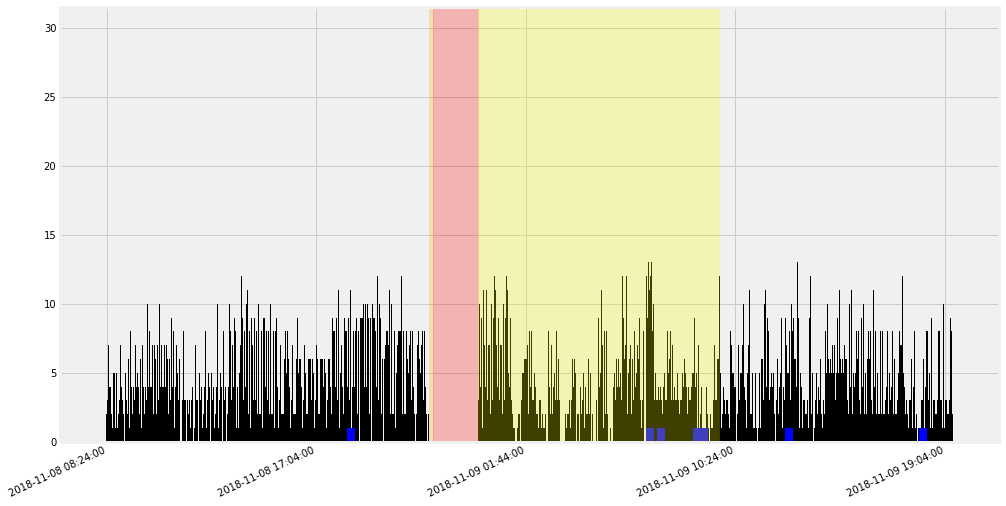

ZIP: 165001, Population: 17, Freq: 30, coverage: 0.3
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:55:00 started @ 2018-11-08 21:46:00 (30011)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 09:49:00 started @ 2018-11-08 21:46:00
detected anomaly @ 2018-11-09 10:10:00 started @ 2018-11-09 10:01:00 (30746)
decline anomaly @ 2018-11-09 10:15:00 started @ 2018-11-09 10:01:00 idx:30751, len:14, thres:30
detected anomaly @ 2018-11-09 12:10:00 started @ 2018-11-09 12:01:00 (30866)
decline anomaly @ 2018-11-09 12:11:00 started @ 2018-11-09 12:01:00 idx:30867, len:10, thres:30
[{'start': 30002, 'detect': 30011, 'end': 30122, 'clear': 30725}]


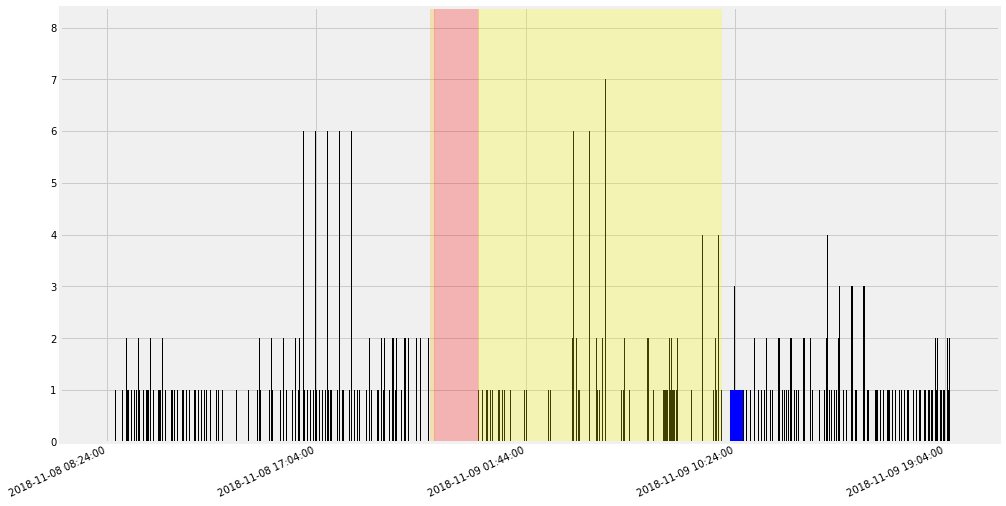

ZIP: 108301, Population: 40, Freq: 30, coverage: 0.67
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 11:52:00 started @ 2018-11-08 21:43:00
[{'start': 29999, 'detect': 30008, 'end': 30121, 'clear': 30848}]


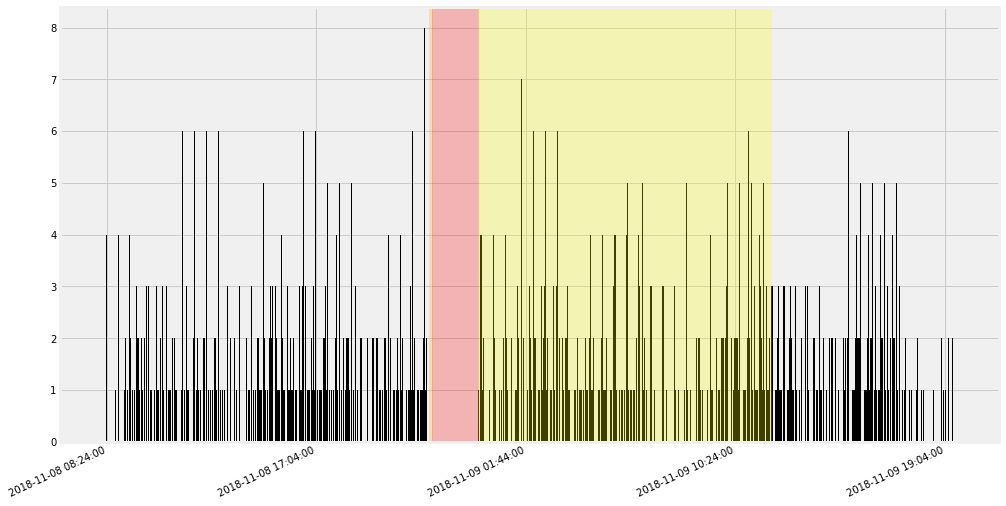

ZIP: 165469, Population: 29, Freq: 30, coverage: 0.6
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 14:03:00 started @ 2018-11-09 13:54:00 (30979)
decline anomaly @ 2018-11-09 14:06:00 started @ 2018-11-09 13:54:00 idx:30982, len:12, thres:30
detected anomaly @ 2018-11-09 18:03:00 started @ 2018-11-09 17:54:00 (31219)
decline anomaly @ 2018-11-09 18:06:00 started @ 2018-11-09 17:54:00 idx:31222, len:12, thres:30
detected anomaly @ 2018-11-09 19:01:00 started @ 2018-11-09 18:52:00 (31277)
decline anomaly @ 2018-11-09 19:06:00 started @ 2018-11-09 18:52:00 idx:31282, len:14, thres:30
[{'start': 30000, 'detect': 30009, 'end': 30122, 'clear': 30720}]


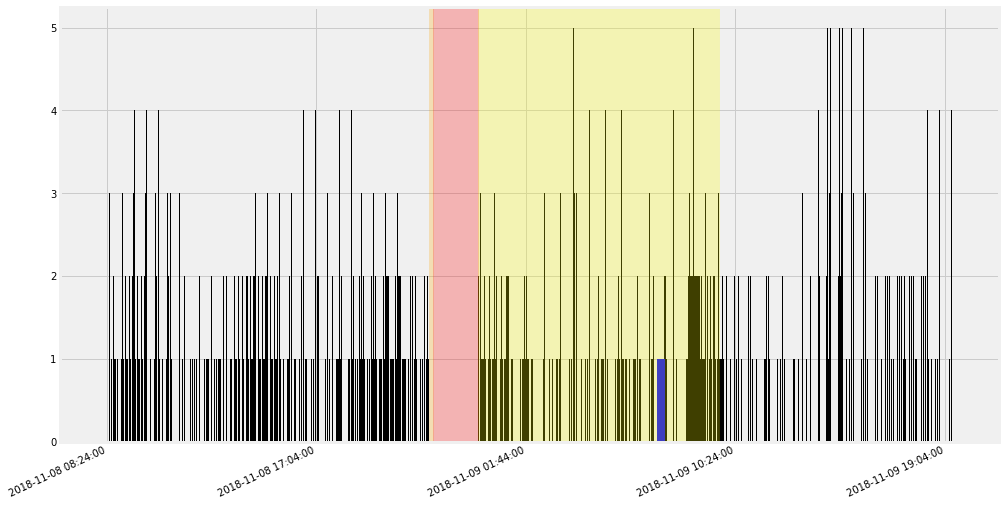

ZIP: 165321, Population: 34, Freq: 30, coverage: 0.77
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:45:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30721}]


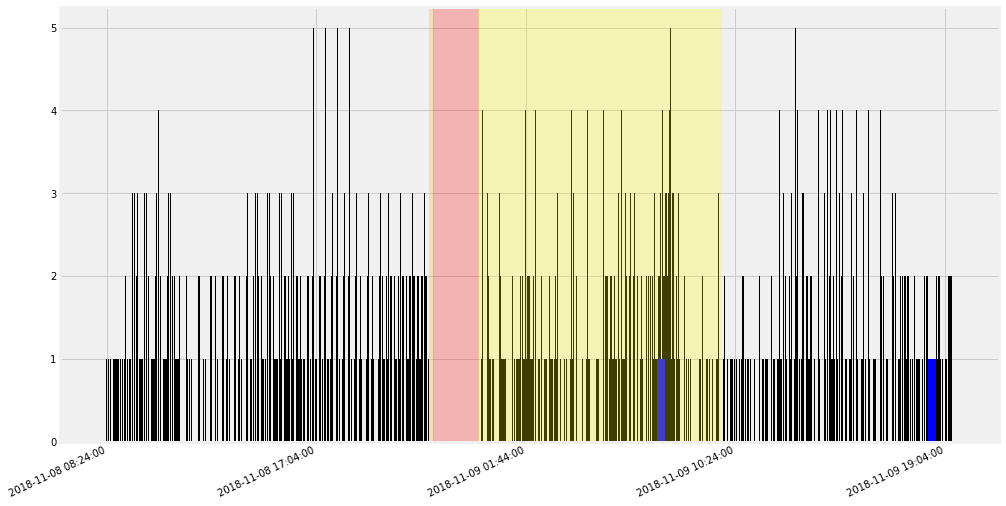

ZIP: 166222, Population: 54, Freq: 30, coverage: 0.73
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:43:00 started @ 2018-11-08 21:43:00
[{'start': 29999, 'detect': 30008, 'end': 30121, 'clear': 30719}]


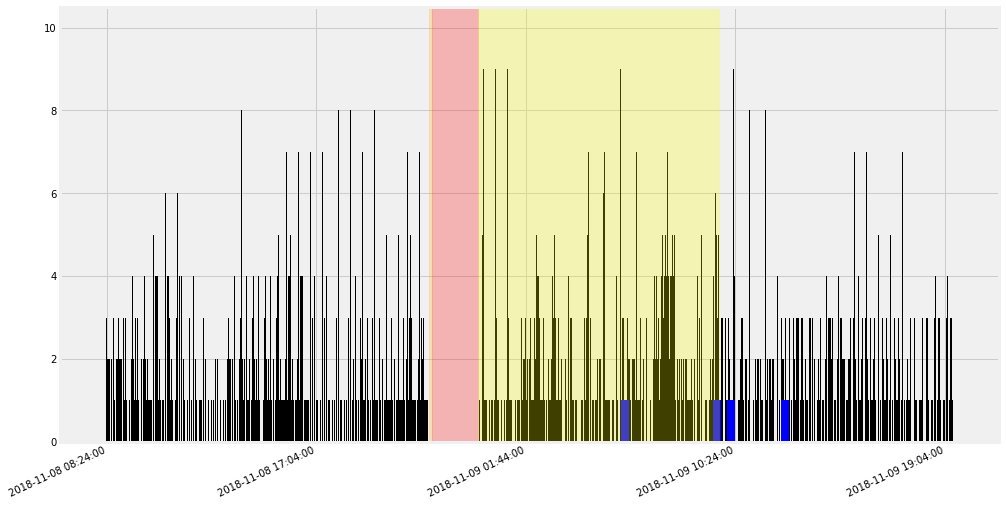

ZIP: 165008, Population: 193, Freq: 30, coverage: 1.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


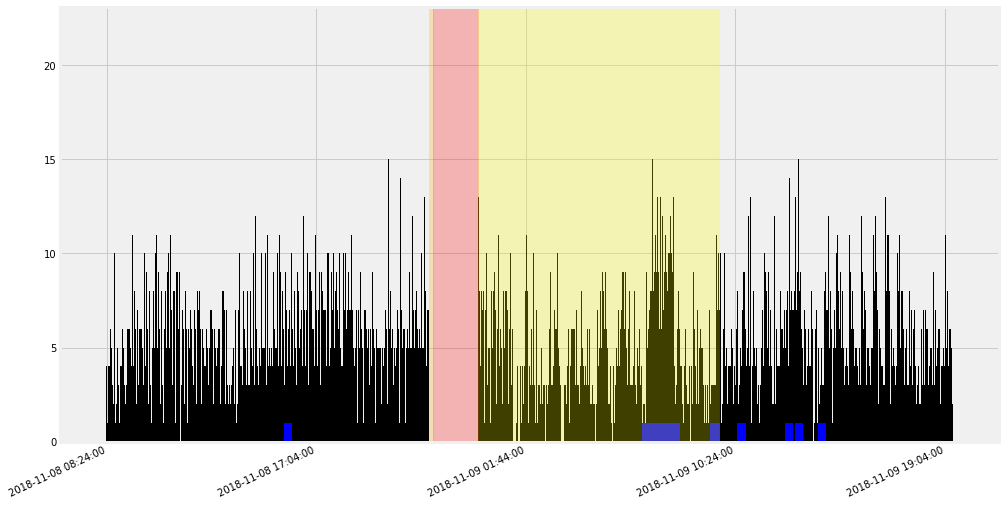

ZIP: 165420, Population: 100, Freq: 30, coverage: 0.93
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


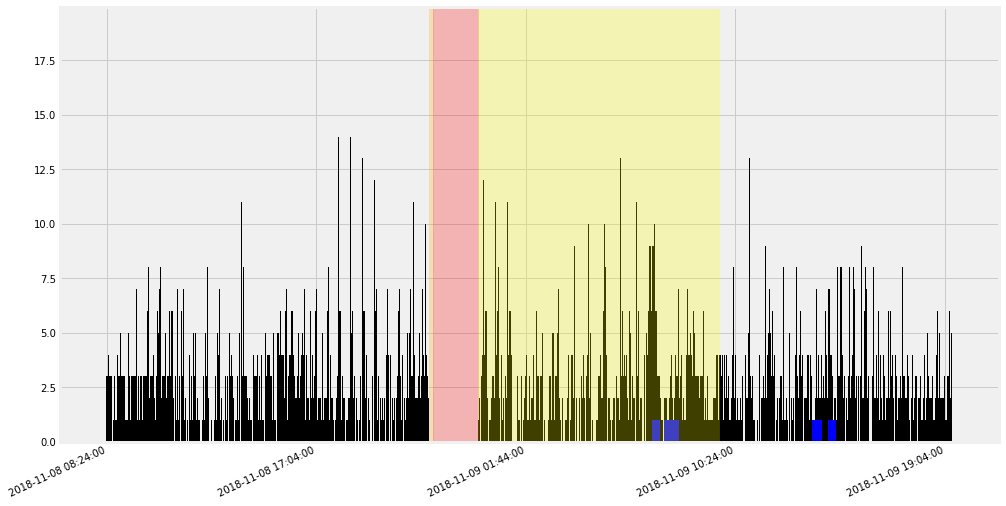

ZIP: 172557, Population: 56, Freq: 30, coverage: 0.9
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 31300}]


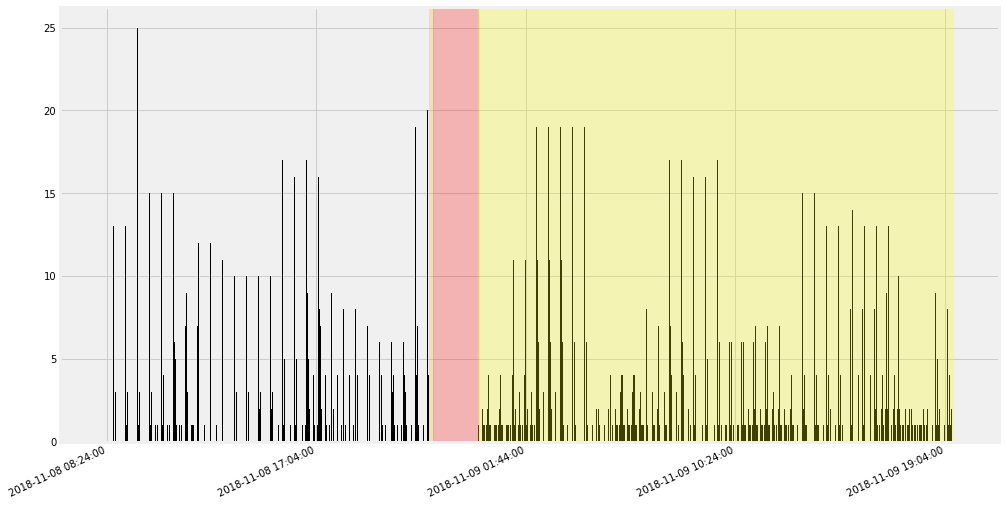

ZIP: 172067, Population: 43, Freq: 30, coverage: 0.7
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:09:00 started @ 2018-11-08 21:00:00 (29965)
decline anomaly @ 2018-11-08 21:10:00 started @ 2018-11-08 21:00:00 idx:29966, len:10, thres:30
detected anomaly @ 2018-11-08 21:39:00 started @ 2018-11-08 21:30:00 (29995)
decline anomaly @ 2018-11-08 21:40:00 started @ 2018-11-08 21:30:00 idx:29996, len:10, thres:30
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 122 minutes
[{'start': 29999, 'detect': 30008, 'end': 30121, 'clear': 31300}]


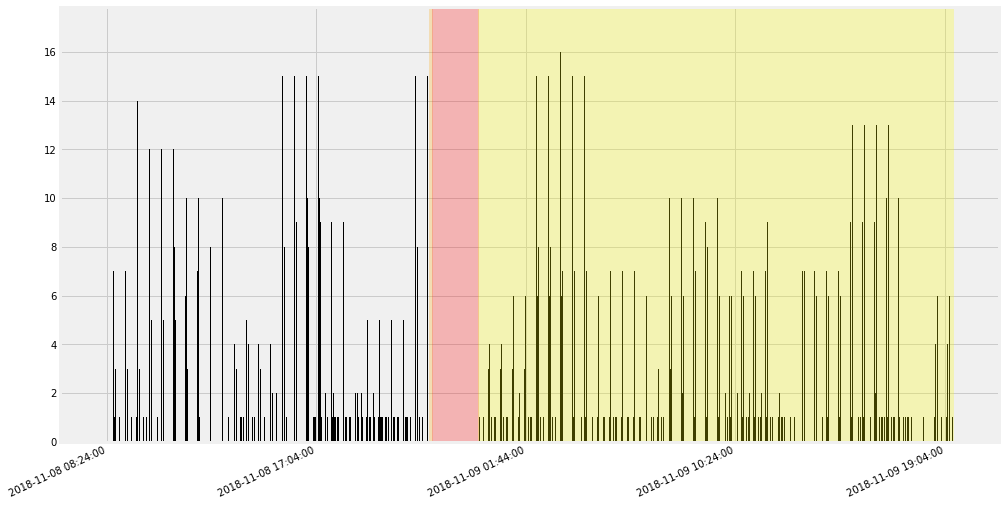

ZIP: 172196, Population: 8, Freq: 30, coverage: 0.23
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 124 minutes
cleared anomaly @ 2018-11-09 10:25:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 10:35:00 started @ 2018-11-09 10:26:00 (30771)
decline anomaly @ 2018-11-09 10:40:00 started @ 2018-11-09 10:26:00 idx:30776, len:14, thres:30
detected anomaly @ 2018-11-09 11:20:00 started @ 2018-11-09 11:11:00 (30816)
decline anomaly @ 2018-11-09 11:21:00 started @ 2018-11-09 11:11:00 idx:30817, len:10, thres:30
detected anomaly @ 2018-11-09 11:32:00 started @ 2018-11-09 11:23:00 (30828)
decline anomaly @ 2018-11-09 11:35:00 started @ 2018-11-09 11:23:00 idx:30831, len:12, thres:30
detected anomaly @ 2018-11-09 11:59:00 started @ 2018-11-09 11:50:00 (30855)
decline anomaly @ 20

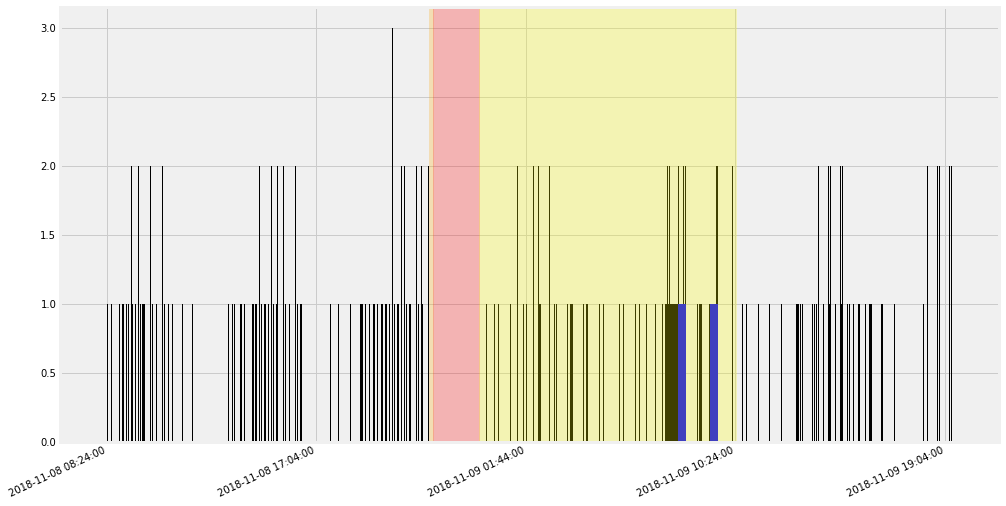

ZIP: 165359, Population: 71, Freq: 30, coverage: 0.97
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


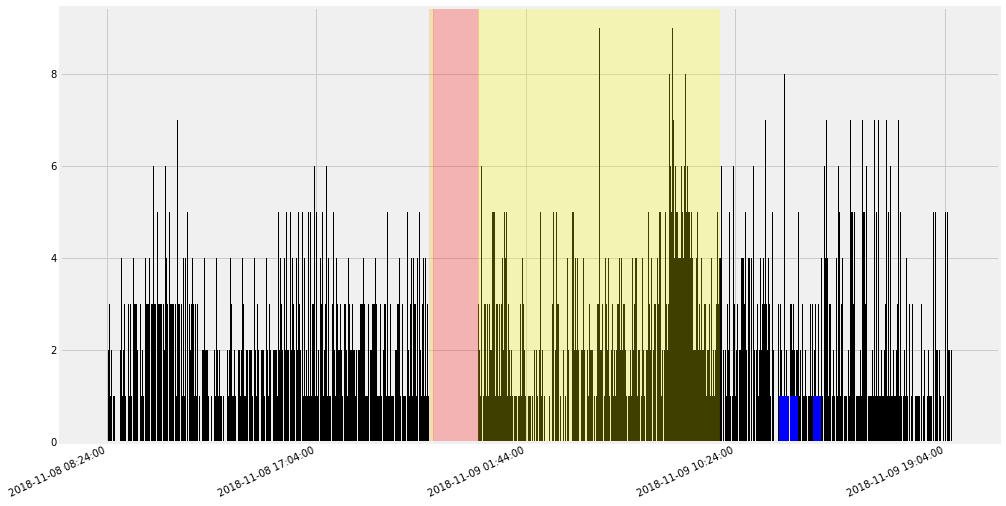

ZIP: 165961, Population: 1, Freq: 30, coverage: 0.03
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:09:00 started @ 2018-11-08 22:00:00 (30025)
end anomaly after 120 minutes
[{'start': 30016, 'detect': 30025, 'end': 30136, 'clear': 31300}]


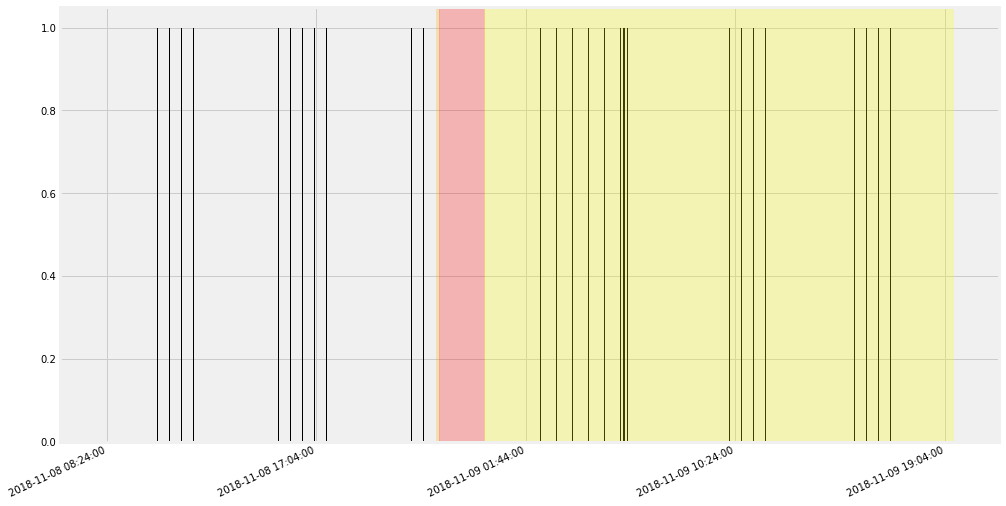

ZIP: 166074, Population: 17, Freq: 30, coverage: 0.5
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 127 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:43:00
detected anomaly @ 2018-11-09 13:46:00 started @ 2018-11-09 13:37:00 (30962)
decline anomaly @ 2018-11-09 13:48:00 started @ 2018-11-09 13:37:00 idx:30964, len:11, thres:30
[{'start': 29999, 'detect': 30008, 'end': 30126, 'clear': 30720}]


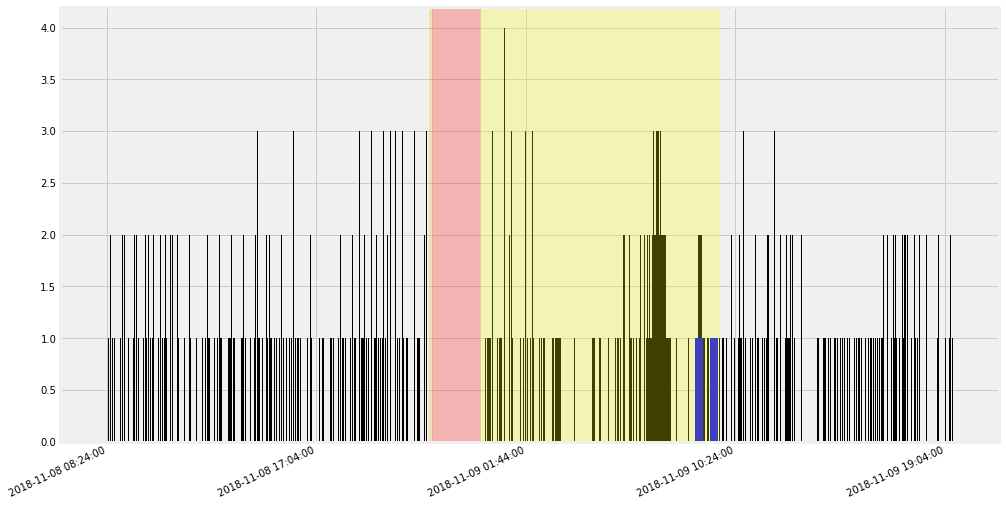

ZIP: 165937, Population: 3, Freq: 30, coverage: 0.1
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:53:00 started @ 2018-11-08 20:44:00 (29949)
decline anomaly @ 2018-11-08 21:01:00 started @ 2018-11-08 20:44:00 idx:29957, len:17, thres:30
detected anomaly @ 2018-11-08 21:23:00 started @ 2018-11-08 21:14:00 (29979)
decline anomaly @ 2018-11-08 21:31:00 started @ 2018-11-08 21:14:00 idx:29987, len:17, thres:30
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 141 minutes
[{'start': 30000, 'detect': 30009, 'end': 30141, 'clear': 31300}]


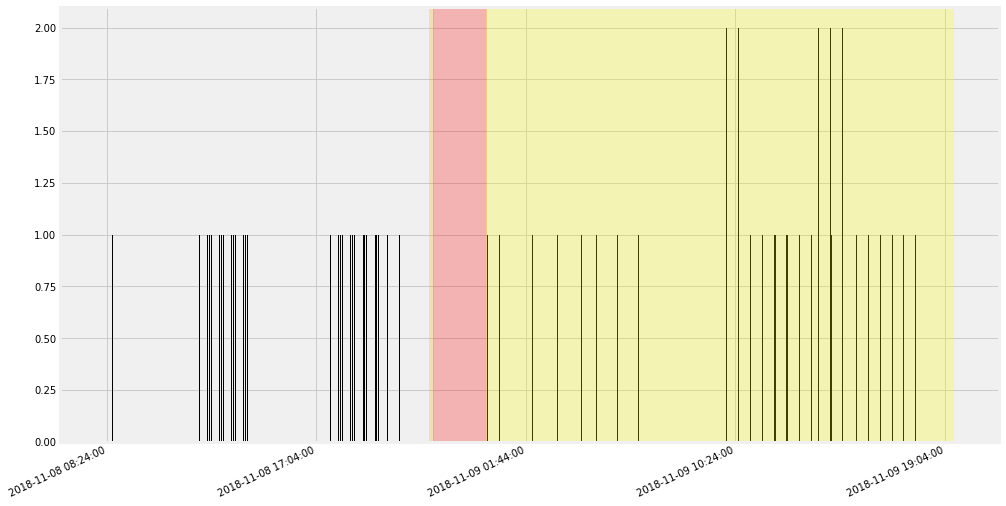

ZIP: 166221, Population: 126, Freq: 30, coverage: 1.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


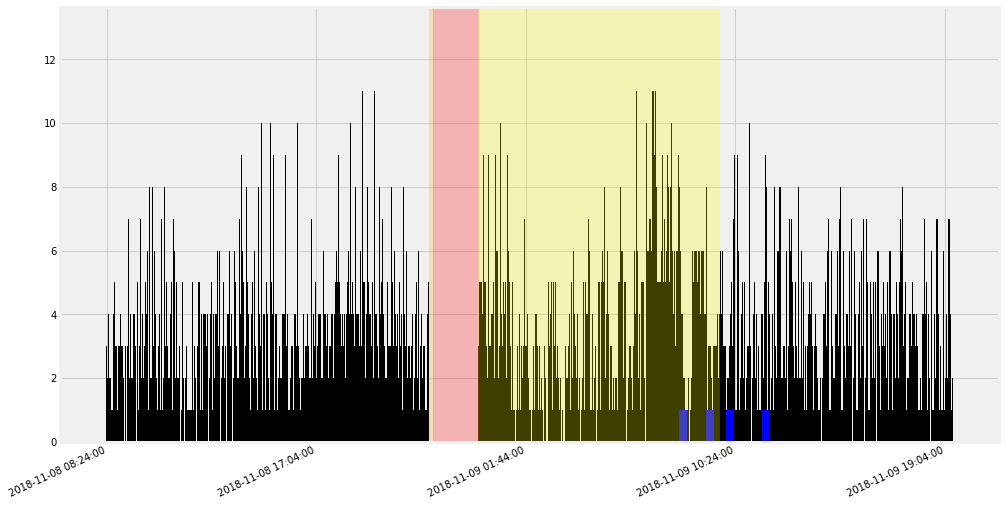

ZIP: 166068, Population: 47, Freq: 30, coverage: 0.67
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


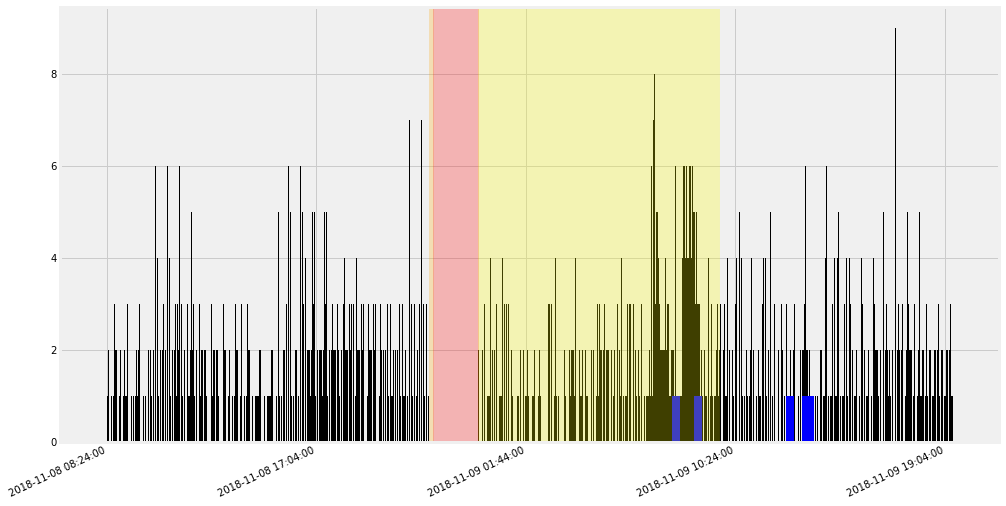

ZIP: 165892, Population: 25, Freq: 30, coverage: 0.4
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:50:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 10:36:00 started @ 2018-11-09 10:27:00 (30772)
decline anomaly @ 2018-11-09 10:37:00 started @ 2018-11-09 10:27:00 idx:30773, len:10, thres:30
detected anomaly @ 2018-11-09 11:06:00 started @ 2018-11-09 10:57:00 (30802)
decline anomaly @ 2018-11-09 11:07:00 started @ 2018-11-09 10:57:00 idx:30803, len:10, thres:30
detected anomaly @ 2018-11-09 12:06:00 started @ 2018-11-09 11:57:00 (30862)
decline anomaly @ 2018-11-09 12:07:00 started @ 2018-11-09 11:57:00 idx:30863, len:10, thres:30
detected anomaly @ 2018-11-09 12:36:00 started @ 2018-11-09 12:27:00 (30892)
decline anomaly @ 20

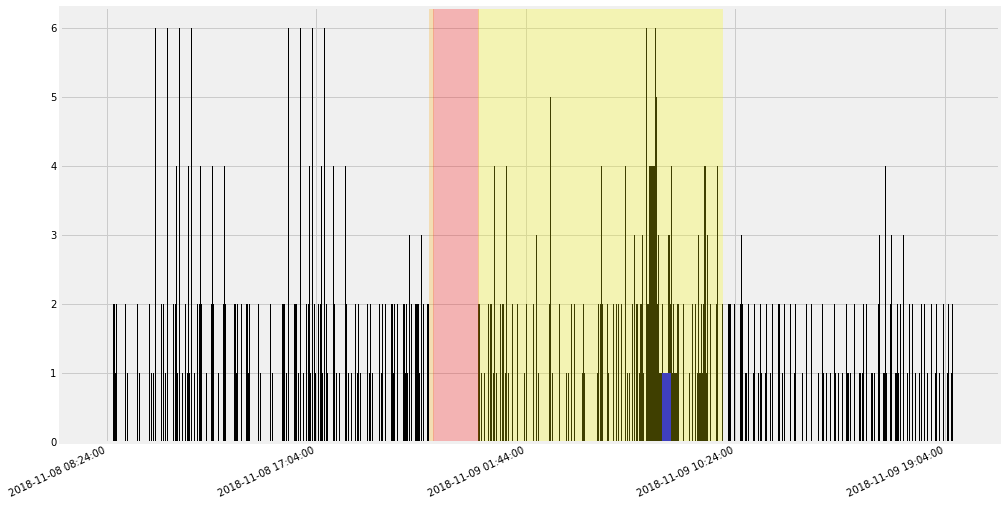

ZIP: 165844, Population: 4, Freq: 30, coverage: 0.13
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:46:00 started @ 2018-11-08 21:37:00 (30002)
end anomaly after 128 minutes
cleared anomaly @ 2018-11-09 09:49:00 started @ 2018-11-08 21:37:00
detected anomaly @ 2018-11-09 10:06:00 started @ 2018-11-09 09:57:00 (30742)
decline anomaly @ 2018-11-09 10:26:00 started @ 2018-11-09 09:57:00 idx:30762, len:29, thres:30
detected anomaly @ 2018-11-09 10:46:00 started @ 2018-11-09 10:37:00 (30782)
decline anomaly @ 2018-11-09 10:48:00 started @ 2018-11-09 10:37:00 idx:30784, len:11, thres:30
detected anomaly @ 2018-11-09 11:06:00 started @ 2018-11-09 10:57:00 (30802)
decline anomaly @ 2018-11-09 11:26:00 started @ 2018-11-09 10:57:00 idx:30822, len:29, thres:30
detected anomaly @ 2018-11-09 11:45:00 started @ 2018-11-09 11:36:00 (30841)
decline anomaly @ 20

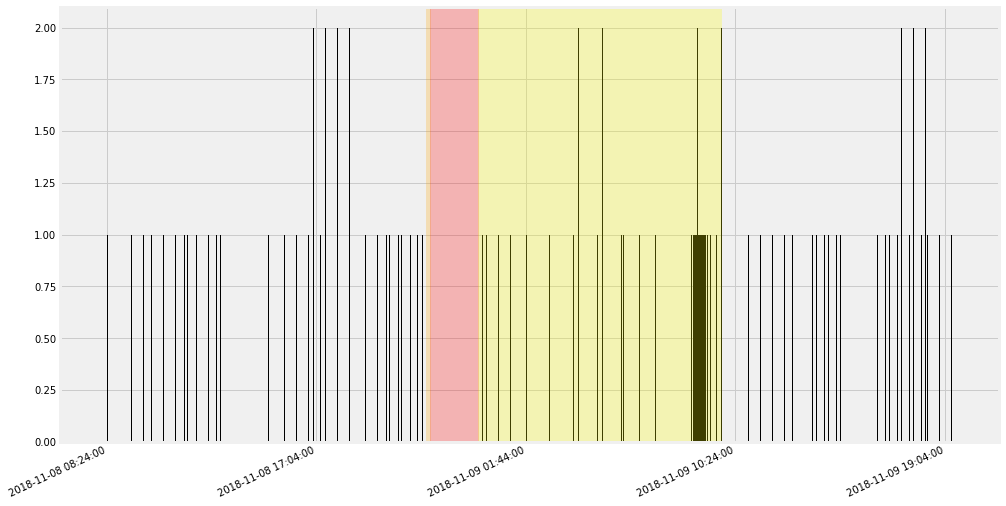

ZIP: 166064, Population: 10, Freq: 30, coverage: 0.27
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:57:00 started @ 2018-11-08 21:48:00 (30013)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 09:49:00 started @ 2018-11-08 21:48:00
detected anomaly @ 2018-11-09 13:41:00 started @ 2018-11-09 13:32:00 (30957)
decline anomaly @ 2018-11-09 13:56:00 started @ 2018-11-09 13:32:00 idx:30972, len:24, thres:30
detected anomaly @ 2018-11-09 14:06:00 started @ 2018-11-09 13:57:00 (30982)
decline anomaly @ 2018-11-09 14:07:00 started @ 2018-11-09 13:57:00 idx:30983, len:10, thres:30
detected anomaly @ 2018-11-09 17:58:00 started @ 2018-11-09 17:49:00 (31214)
decline anomaly @ 2018-11-09 18:00:00 started @ 2018-11-09 17:49:00 idx:31216, len:11, thres:30
detected anomaly @ 2018-11-09 18:28:00 started @ 2018-11-09 18:19:00 (31244)
decline anomaly @ 2

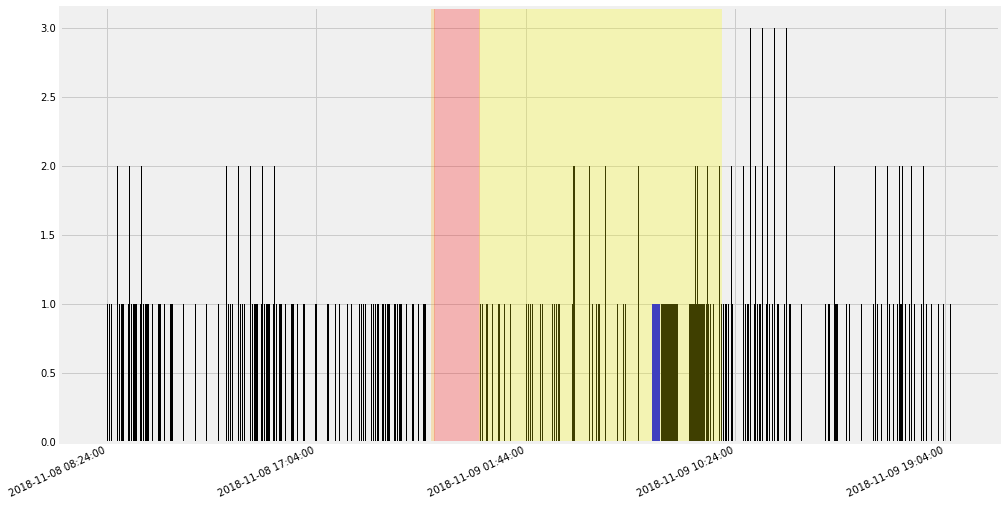

ZIP: 166177, Population: 14, Freq: 30, coverage: 0.4
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 123 minutes
cleared anomaly @ 2018-11-09 09:48:00 started @ 2018-11-08 21:43:00
detected anomaly @ 2018-11-09 10:21:00 started @ 2018-11-09 10:12:00 (30757)
decline anomaly @ 2018-11-09 10:25:00 started @ 2018-11-09 10:12:00 idx:30761, len:13, thres:30
detected anomaly @ 2018-11-09 11:47:00 started @ 2018-11-09 11:38:00 (30843)
decline anomaly @ 2018-11-09 11:48:00 started @ 2018-11-09 11:38:00 idx:30844, len:10, thres:30
detected anomaly @ 2018-11-09 13:45:00 started @ 2018-11-09 13:36:00 (30961)
decline anomaly @ 2018-11-09 13:48:00 started @ 2018-11-09 13:36:00 idx:30964, len:12, thres:30
detected anomaly @ 2018-11-09 17:55:00 started @ 2018-11-09 17:46:00 (31211)
decline anomaly @ 20

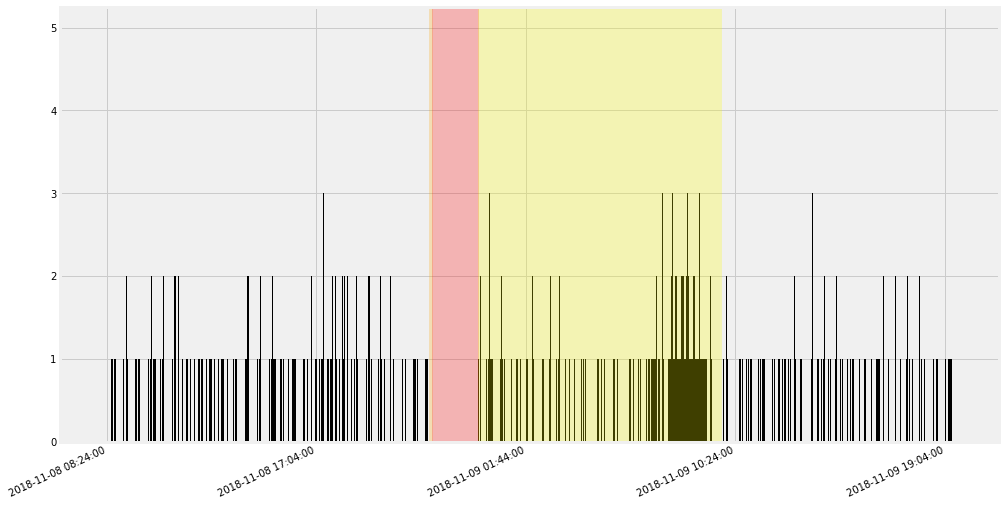

ZIP: 165588, Population: 49, Freq: 30, coverage: 0.7
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:51:00 started @ 2018-11-08 21:42:00 (30007)
end anomaly after 123 minutes
cleared anomaly @ 2018-11-09 09:42:00 started @ 2018-11-08 21:42:00
[{'start': 29998, 'detect': 30007, 'end': 30121, 'clear': 30718}]


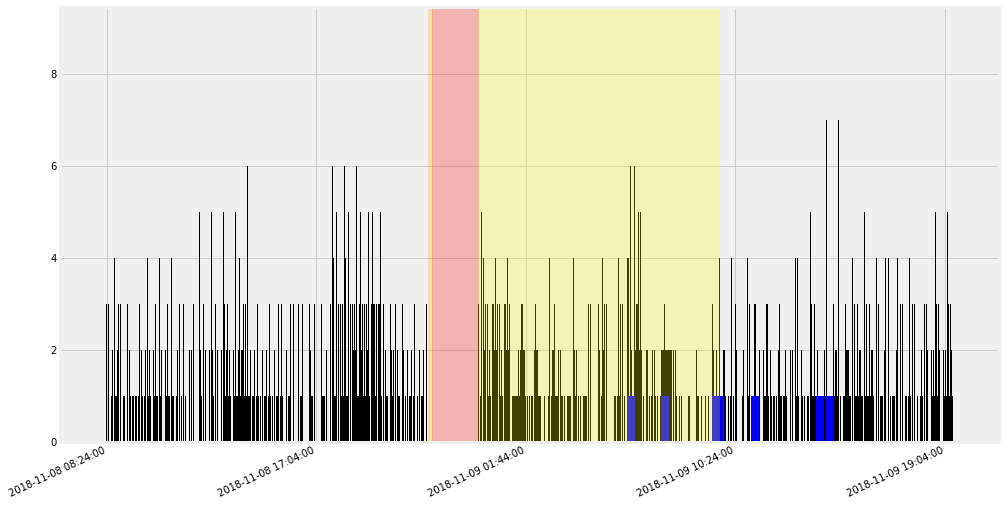

ZIP: 165123, Population: 45, Freq: 30, coverage: 0.7
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:45:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30721}]


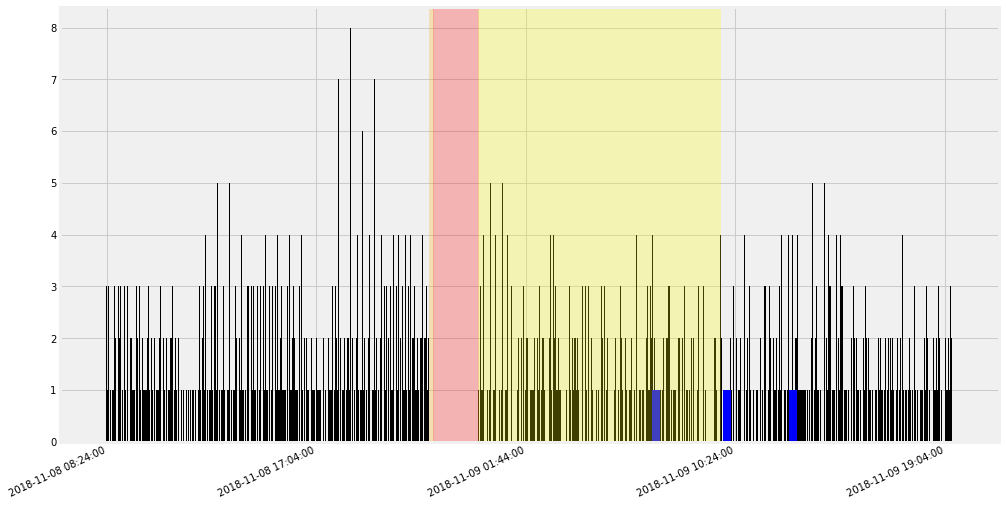

ZIP: 166383, Population: 113, Freq: 30, coverage: 0.93
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


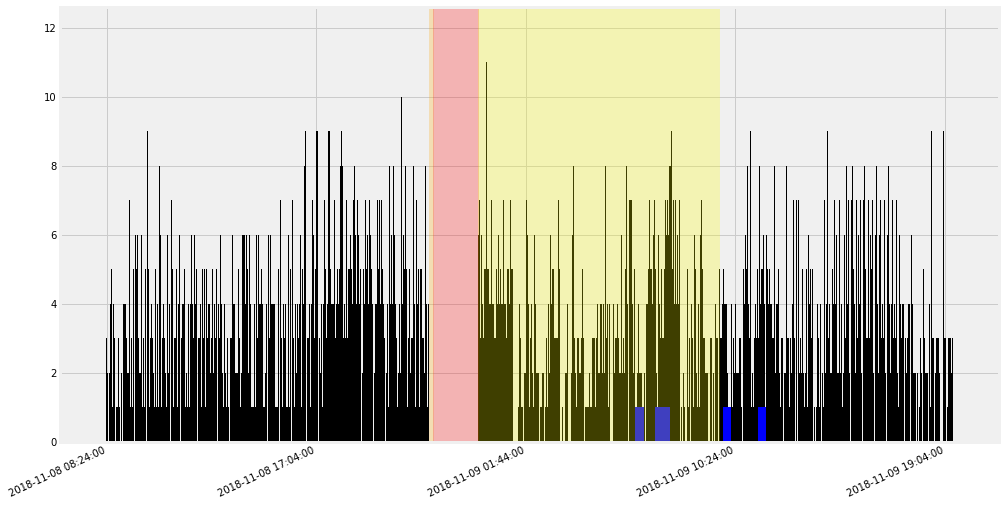

ZIP: 165866, Population: 48, Freq: 30, coverage: 0.73
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:46:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30122, 'clear': 30722}]


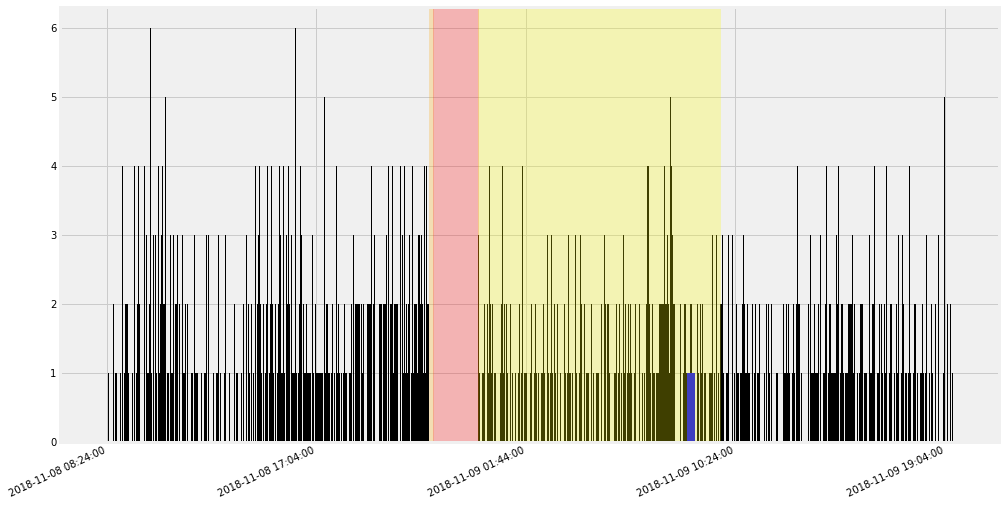

ZIP: 166067, Population: 122, Freq: 30, coverage: 0.93
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


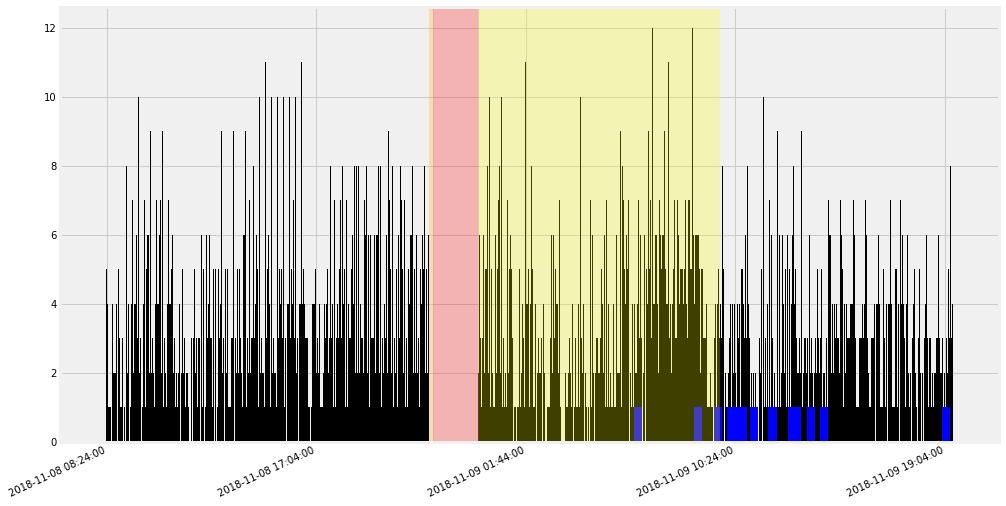

ZIP: 165847, Population: 8, Freq: 30, coverage: 0.2
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 123 minutes
cleared anomaly @ 2018-11-09 09:45:00 started @ 2018-11-08 21:43:00
detected anomaly @ 2018-11-09 10:44:00 started @ 2018-11-09 10:35:00 (30780)
decline anomaly @ 2018-11-09 10:45:00 started @ 2018-11-09 10:35:00 idx:30781, len:10, thres:30
detected anomaly @ 2018-11-09 11:11:00 started @ 2018-11-09 11:02:00 (30807)
decline anomaly @ 2018-11-09 11:15:00 started @ 2018-11-09 11:02:00 idx:30811, len:13, thres:30
detected anomaly @ 2018-11-09 11:37:00 started @ 2018-11-09 11:28:00 (30833)
decline anomaly @ 2018-11-09 11:38:00 started @ 2018-11-09 11:28:00 idx:30834, len:10, thres:30
detected anomaly @ 2018-11-09 12:37:00 started @ 2018-11-09 12:28:00 (30893)
decline anomaly @ 201

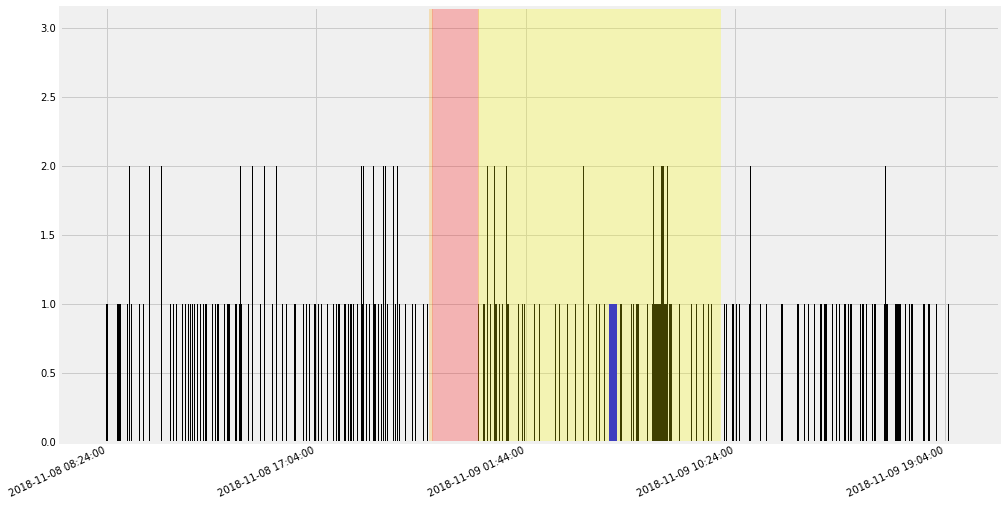

ZIP: 172122, Population: 24, Freq: 30, coverage: 0.57
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:54:00 started @ 2018-11-08 21:45:00 (30010)
end anomaly after 120 minutes
[{'start': 30001, 'detect': 30010, 'end': 30121, 'clear': 31300}]


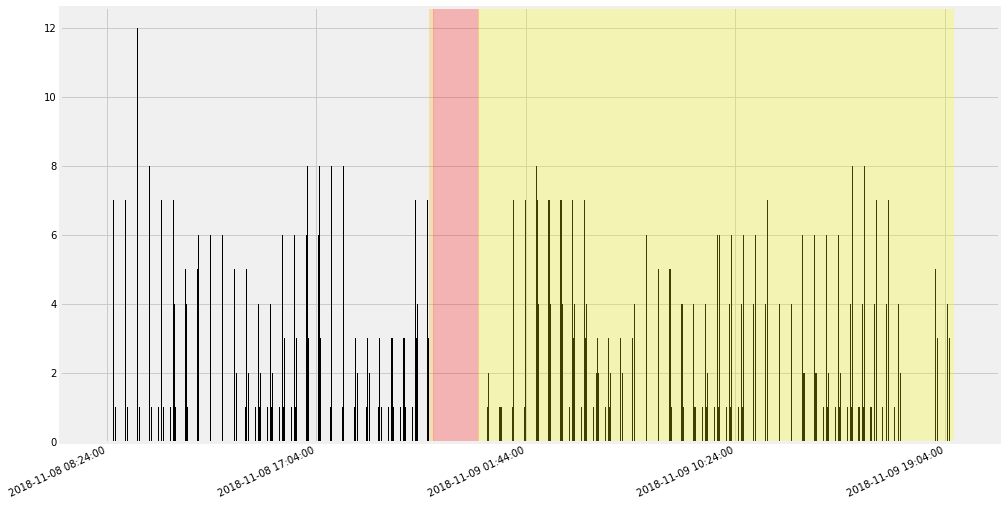

ZIP: 165020, Population: 12, Freq: 30, coverage: 0.3
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:49:00 started @ 2018-11-08 21:40:00 (30005)
end anomaly after 126 minutes
cleared anomaly @ 2018-11-09 09:40:00 started @ 2018-11-08 21:40:00
detected anomaly @ 2018-11-09 17:39:00 started @ 2018-11-09 17:30:00 (31195)
decline anomaly @ 2018-11-09 17:41:00 started @ 2018-11-09 17:30:00 idx:31197, len:11, thres:30
[{'start': 29996, 'detect': 30005, 'end': 30122, 'clear': 30716}]


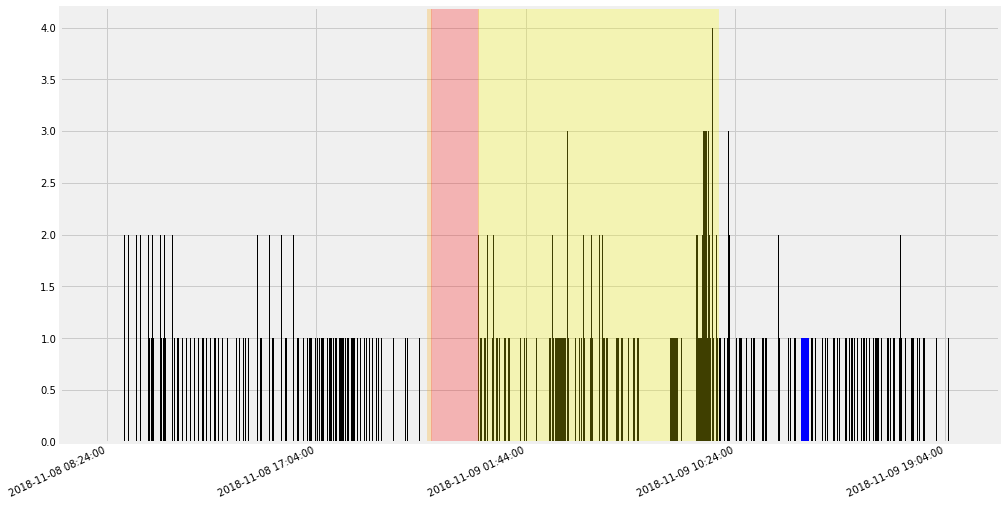

ZIP: 172097, Population: 52, Freq: 30, coverage: 0.83
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 16:25:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 31121}]


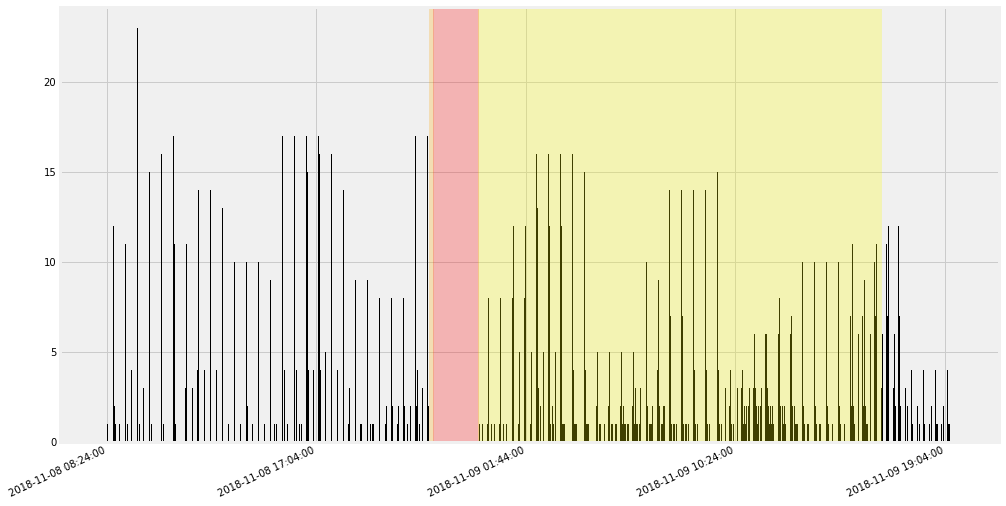

ZIP: 165890, Population: 104, Freq: 30, coverage: 1.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


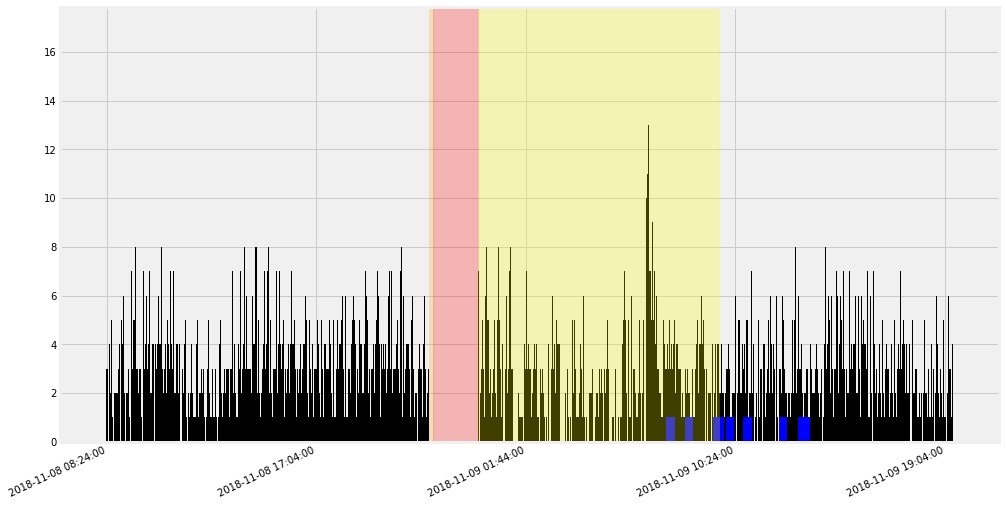

ZIP: 172069, Population: 18, Freq: 30, coverage: 0.5
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 13:56:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 18:10:00 started @ 2018-11-09 18:01:00 (31226)
decline anomaly @ 2018-11-09 18:11:00 started @ 2018-11-09 18:01:00 idx:31227, len:10, thres:30
detected anomaly @ 2018-11-09 18:40:00 started @ 2018-11-09 18:31:00 (31256)
decline anomaly @ 2018-11-09 18:41:00 started @ 2018-11-09 18:31:00 idx:31257, len:10, thres:30
detected anomaly @ 2018-11-09 19:10:00 started @ 2018-11-09 19:01:00 (31286)
decline anomaly @ 2018-11-09 19:11:00 started @ 2018-11-09 19:01:00 idx:31287, len:10, thres:30
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30972}]


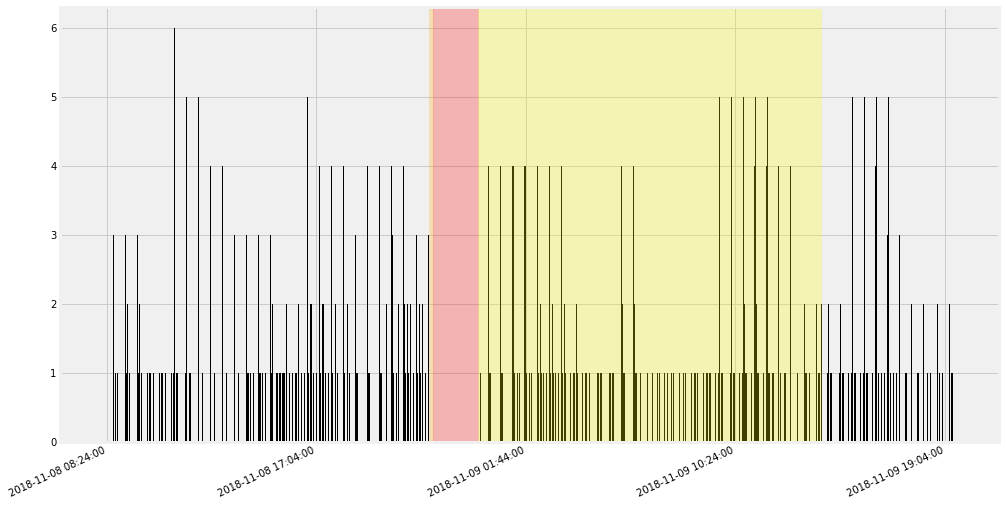

ZIP: 165959, Population: 6, Freq: 60, coverage: 0.1
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:57:00 started @ 2018-11-08 21:48:00 (30013)
end anomaly after 120 minutes
[{'start': 30004, 'detect': 30013, 'end': 30124, 'clear': 31300}]


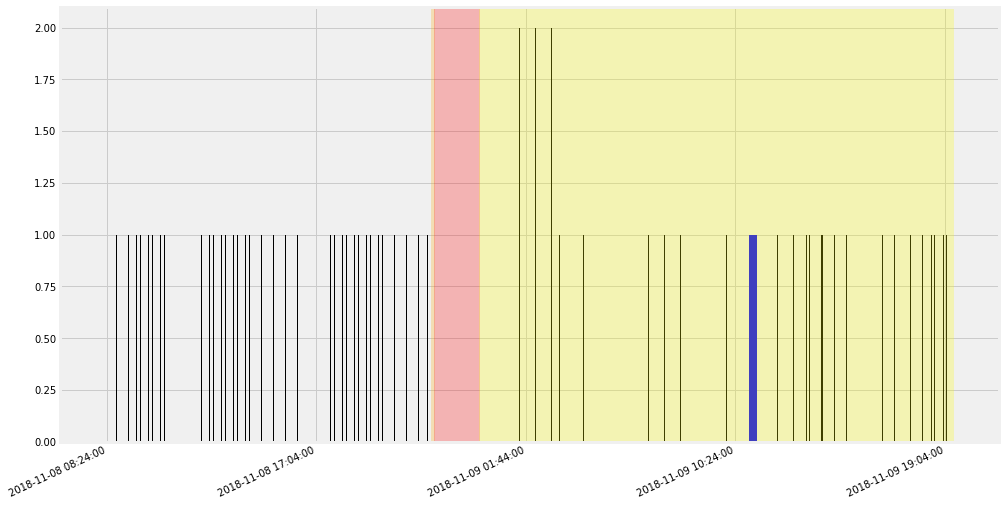

ZIP: 165868, Population: 18, Freq: 30, coverage: 0.4
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:43:00
detected anomaly @ 2018-11-09 11:22:00 started @ 2018-11-09 11:13:00 (30818)
decline anomaly @ 2018-11-09 11:36:00 started @ 2018-11-09 11:13:00 idx:30832, len:23, thres:30
detected anomaly @ 2018-11-09 12:11:00 started @ 2018-11-09 12:02:00 (30867)
decline anomaly @ 2018-11-09 12:12:00 started @ 2018-11-09 12:02:00 idx:30868, len:10, thres:30
detected anomaly @ 2018-11-09 13:22:00 started @ 2018-11-09 13:13:00 (30938)
decline anomaly @ 2018-11-09 13:35:00 started @ 2018-11-09 13:13:00 idx:30951, len:22, thres:30
detected anomaly @ 2018-11-09 18:45:00 started @ 2018-11-09 18:36:00 (31261)
decline anomaly @ 20

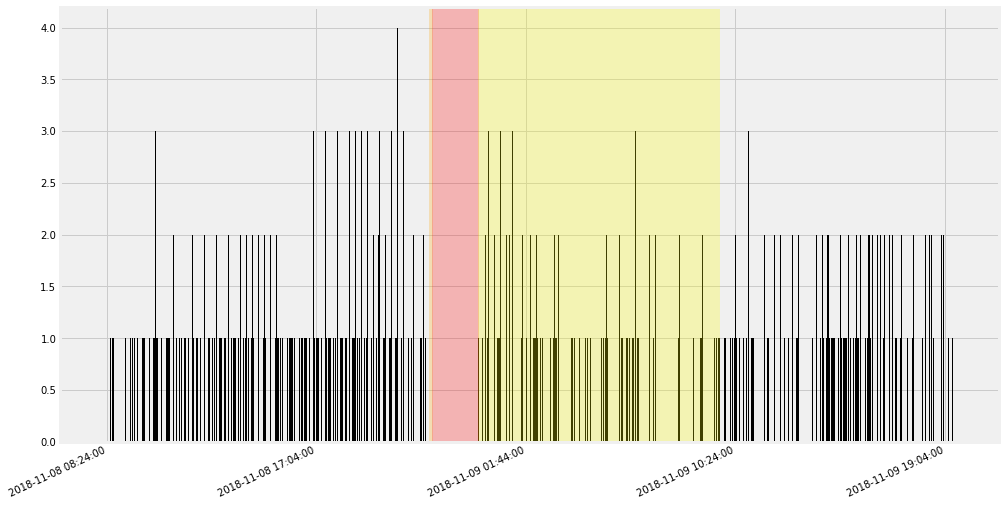

ZIP: 165954, Population: 26, Freq: 30, coverage: 0.53
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:54:00 started @ 2018-11-08 21:45:00 (30010)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 09:45:00 started @ 2018-11-08 21:45:00
detected anomaly @ 2018-11-09 12:40:00 started @ 2018-11-09 12:31:00 (30896)
decline anomaly @ 2018-11-09 12:42:00 started @ 2018-11-09 12:31:00 idx:30898, len:11, thres:30
detected anomaly @ 2018-11-09 13:40:00 started @ 2018-11-09 13:31:00 (30956)
decline anomaly @ 2018-11-09 13:43:00 started @ 2018-11-09 13:31:00 idx:30959, len:12, thres:30
[{'start': 30001, 'detect': 30010, 'end': 30121, 'clear': 30721}]


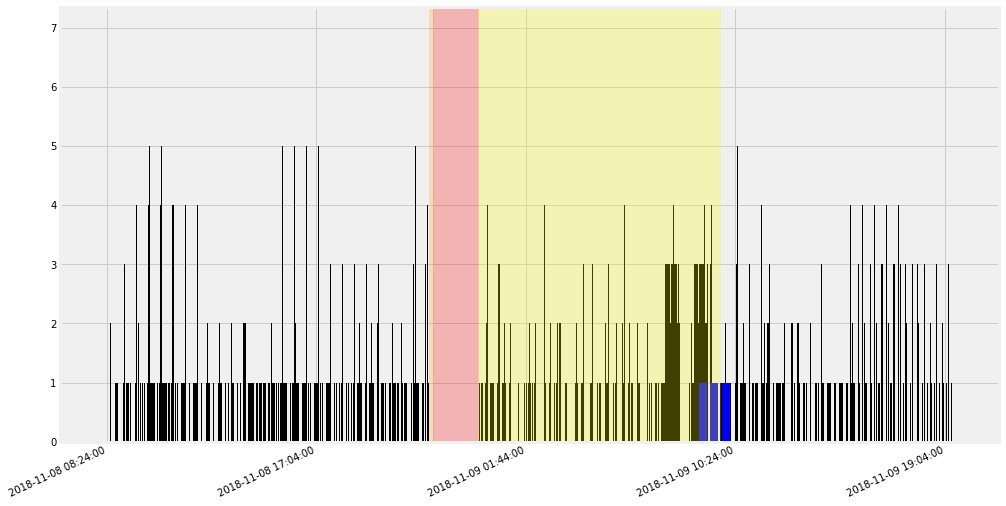

ZIP: 166282, Population: 56, Freq: 30, coverage: 0.77
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:45:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30721}]


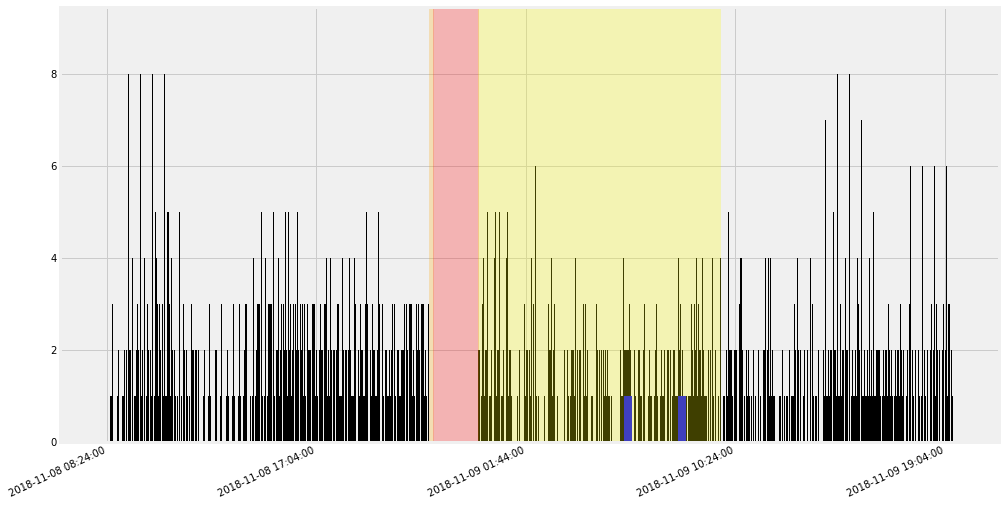

ZIP: 164967, Population: 65, Freq: 30, coverage: 0.8
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


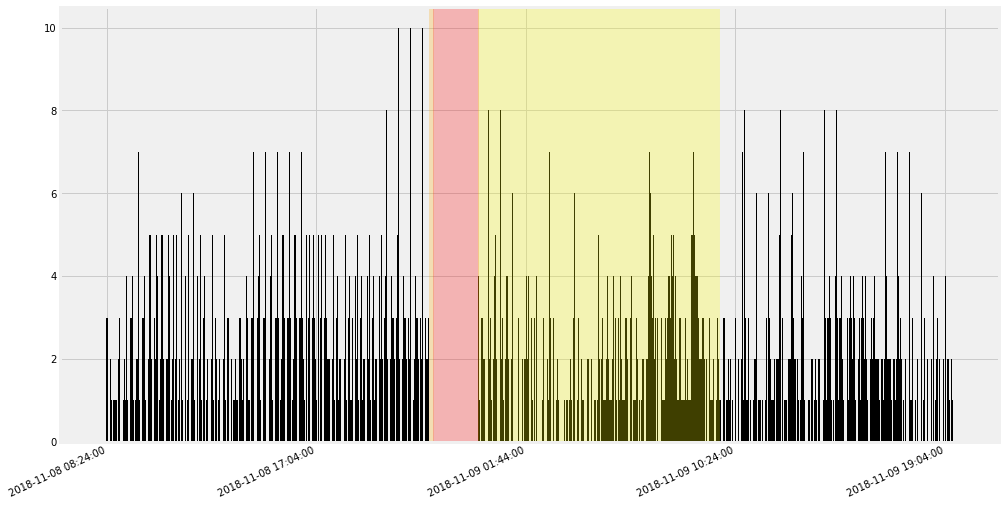

ZIP: 164977, Population: 213, Freq: 30, coverage: 1.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


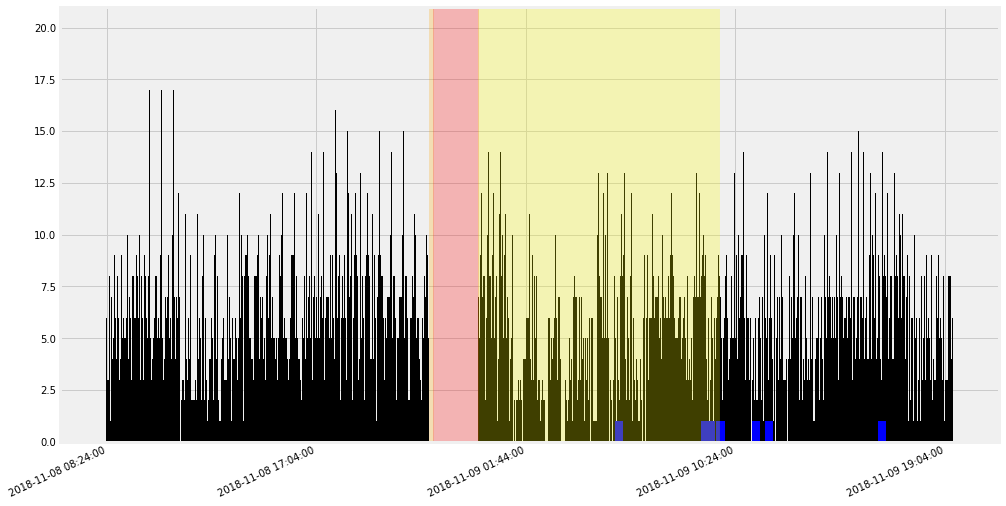

ZIP: 164991, Population: 109, Freq: 30, coverage: 0.8
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30122, 'clear': 30720}]


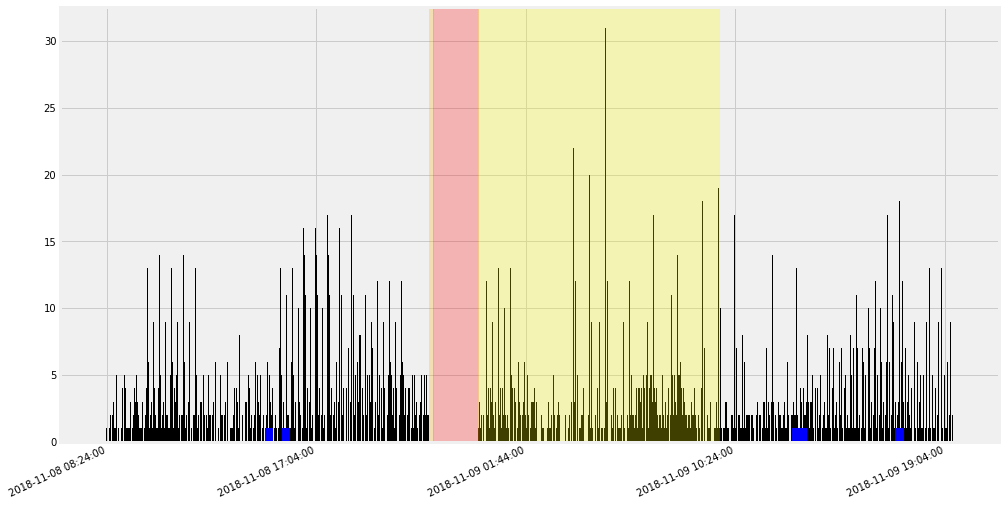

ZIP: 164770, Population: 1, Freq: 30, coverage: 0.03
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:09:00 started @ 2018-11-08 22:00:00 (30025)
end anomaly after 121 minutes
[{'start': 30016, 'detect': 30025, 'end': 30137, 'clear': 31300}]


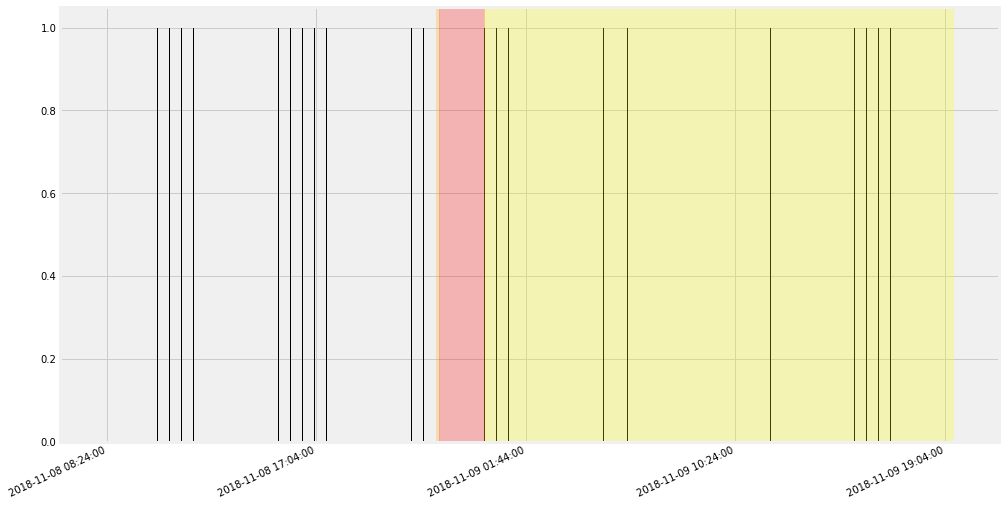

ZIP: 165358, Population: 69, Freq: 30, coverage: 0.9
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


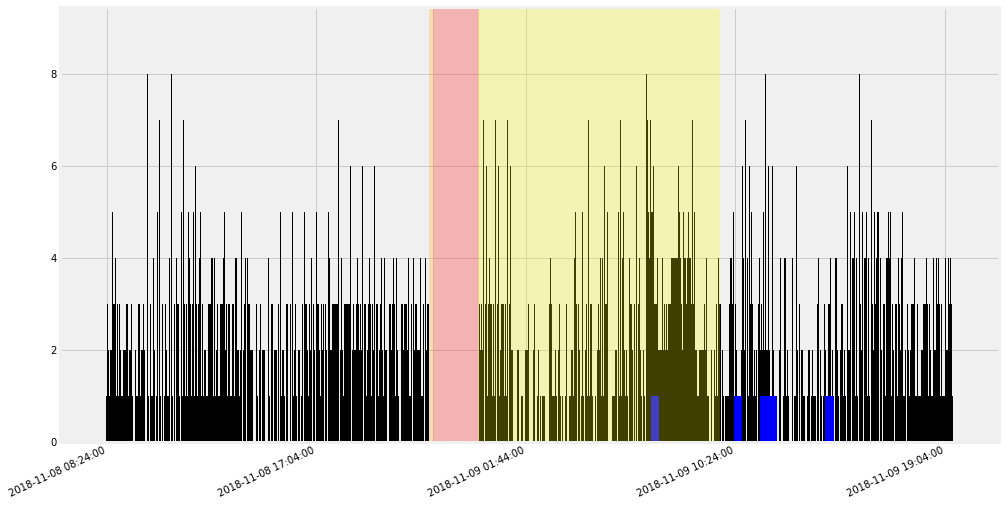

ZIP: 172059, Population: 88, Freq: 30, coverage: 0.93
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


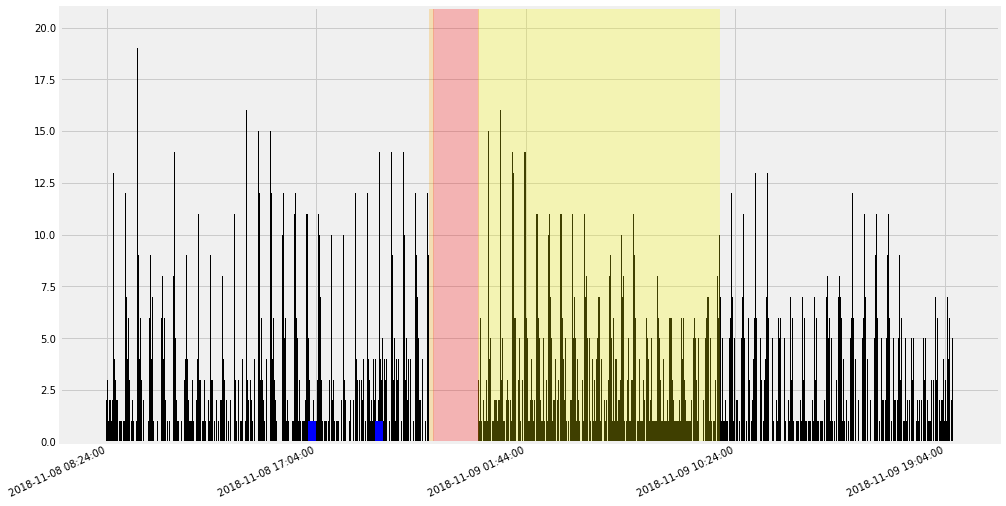

ZIP: 166079, Population: 17, Freq: 30, coverage: 0.37
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:51:00 started @ 2018-11-08 21:42:00 (30007)
end anomaly after 125 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:42:00
detected anomaly @ 2018-11-09 17:57:00 started @ 2018-11-09 17:48:00 (31213)
decline anomaly @ 2018-11-09 18:01:00 started @ 2018-11-09 17:48:00 idx:31217, len:13, thres:30
detected anomaly @ 2018-11-09 18:27:00 started @ 2018-11-09 18:18:00 (31243)
decline anomaly @ 2018-11-09 18:31:00 started @ 2018-11-09 18:18:00 idx:31247, len:13, thres:30
detected anomaly @ 2018-11-09 18:57:00 started @ 2018-11-09 18:48:00 (31273)
decline anomaly @ 2018-11-09 19:01:00 started @ 2018-11-09 18:48:00 idx:31277, len:13, thres:30
[{'start': 29998, 'detect': 30007, 'end': 30123, 'clear': 30720}]


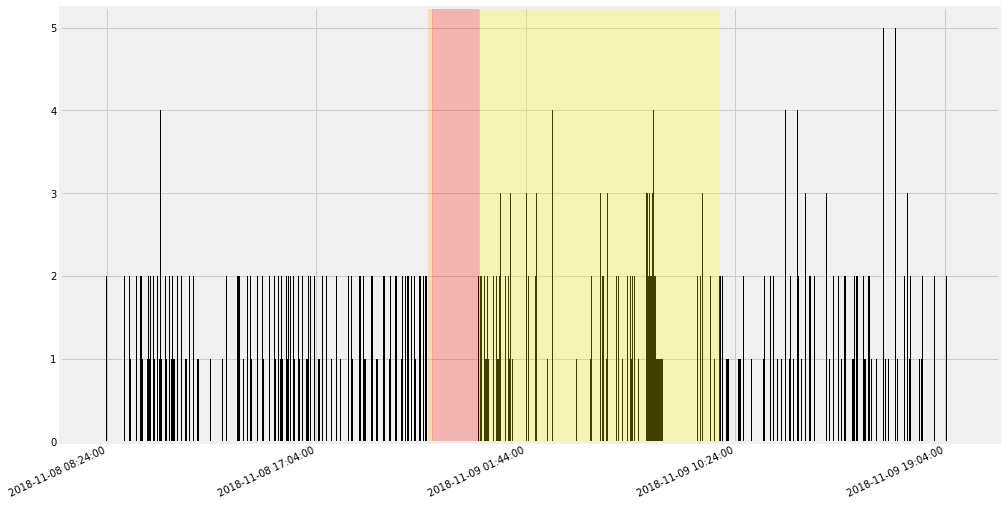

ZIP: 166220, Population: 22, Freq: 30, coverage: 0.37
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:54:00 started @ 2018-11-08 21:45:00 (30010)
end anomaly after 123 minutes
cleared anomaly @ 2018-11-09 09:48:00 started @ 2018-11-08 21:45:00
detected anomaly @ 2018-11-09 10:37:00 started @ 2018-11-09 10:28:00 (30773)
decline anomaly @ 2018-11-09 10:40:00 started @ 2018-11-09 10:28:00 idx:30776, len:12, thres:30
detected anomaly @ 2018-11-09 10:52:00 started @ 2018-11-09 10:43:00 (30788)
decline anomaly @ 2018-11-09 10:53:00 started @ 2018-11-09 10:43:00 idx:30789, len:10, thres:30
detected anomaly @ 2018-11-09 11:37:00 started @ 2018-11-09 11:28:00 (30833)
decline anomaly @ 2018-11-09 11:39:00 started @ 2018-11-09 11:28:00 idx:30835, len:11, thres:30
detected anomaly @ 2018-11-09 11:52:00 started @ 2018-11-09 11:43:00 (30848)
decline anomaly @ 2

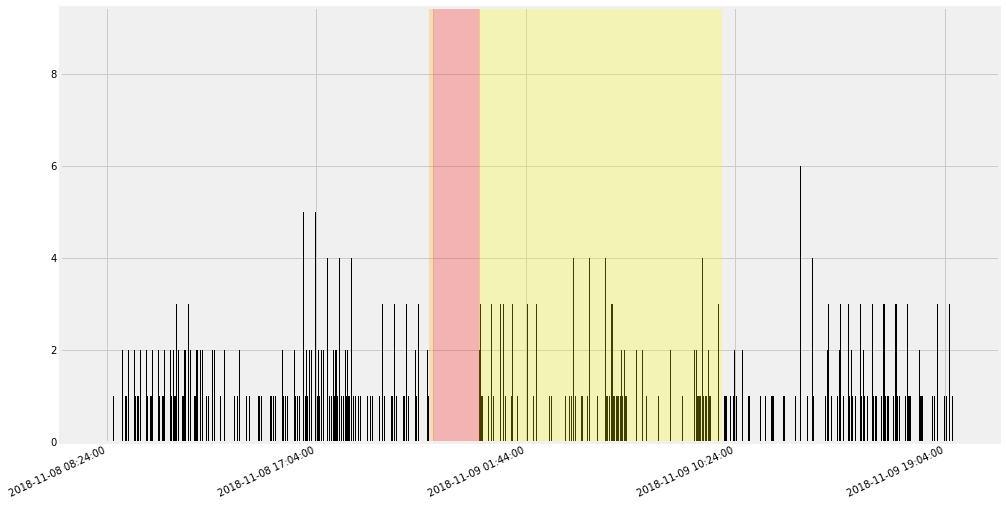

ZIP: 165943, Population: 8, Freq: 30, coverage: 0.17
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:04:00 started @ 2018-11-08 21:55:00 (30020)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:57:00 started @ 2018-11-08 21:55:00
detected anomaly @ 2018-11-09 10:16:00 started @ 2018-11-09 10:07:00 (30752)
decline anomaly @ 2018-11-09 10:21:00 started @ 2018-11-09 10:07:00 idx:30757, len:14, thres:30
detected anomaly @ 2018-11-09 10:46:00 started @ 2018-11-09 10:37:00 (30782)
decline anomaly @ 2018-11-09 10:51:00 started @ 2018-11-09 10:37:00 idx:30787, len:14, thres:30
detected anomaly @ 2018-11-09 11:16:00 started @ 2018-11-09 11:07:00 (30812)
decline anomaly @ 2018-11-09 11:21:00 started @ 2018-11-09 11:07:00 idx:30817, len:14, thres:30
detected anomaly @ 2018-11-09 12:16:00 started @ 2018-11-09 12:07:00 (30872)
decline anomaly @ 20

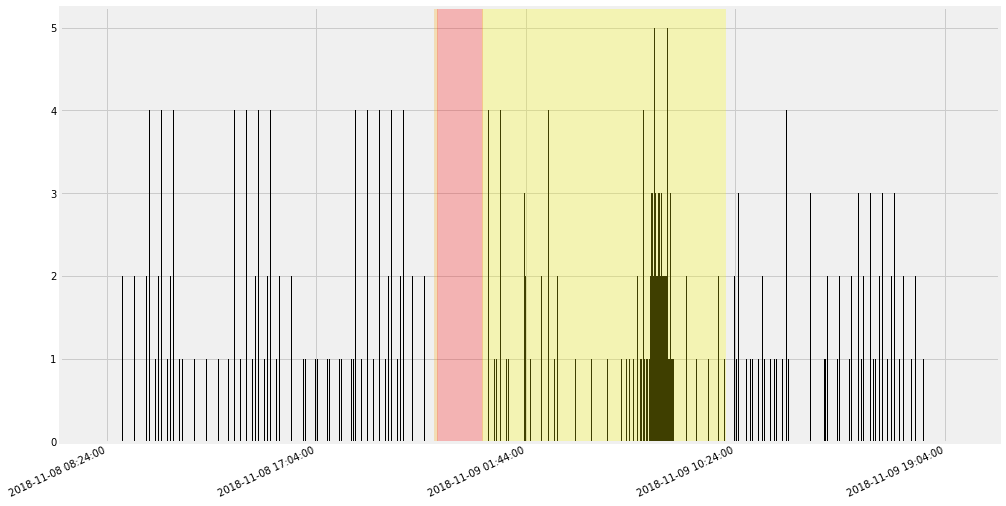

ZIP: 164757, Population: 41, Freq: 30, coverage: 0.8
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:43:00 started @ 2018-11-08 21:43:00
detected anomaly @ 2018-11-09 11:20:00 started @ 2018-11-09 11:11:00 (30816)
decline anomaly @ 2018-11-09 11:22:00 started @ 2018-11-09 11:11:00 idx:30818, len:11, thres:30
[{'start': 29999, 'detect': 30008, 'end': 30121, 'clear': 30719}]


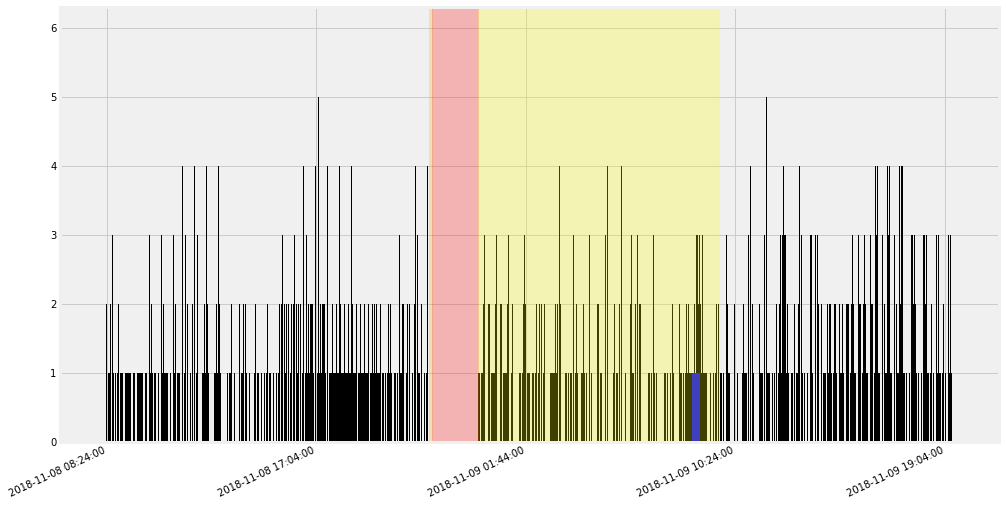

ZIP: 164988, Population: 57, Freq: 30, coverage: 0.67
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:46:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30122, 'clear': 30722}]


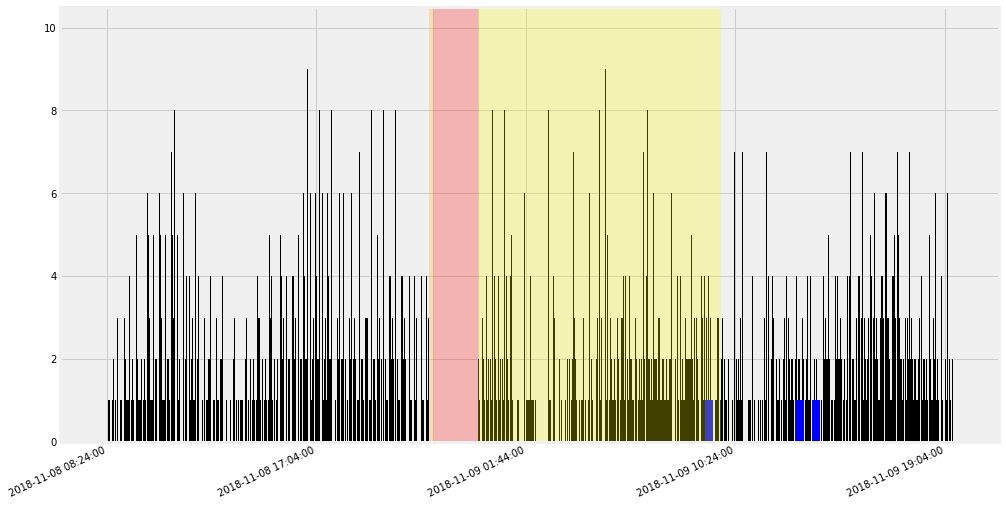

ZIP: 165018, Population: 48, Freq: 30, coverage: 0.7
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:43:00
[{'start': 29999, 'detect': 30008, 'end': 30121, 'clear': 30720}]


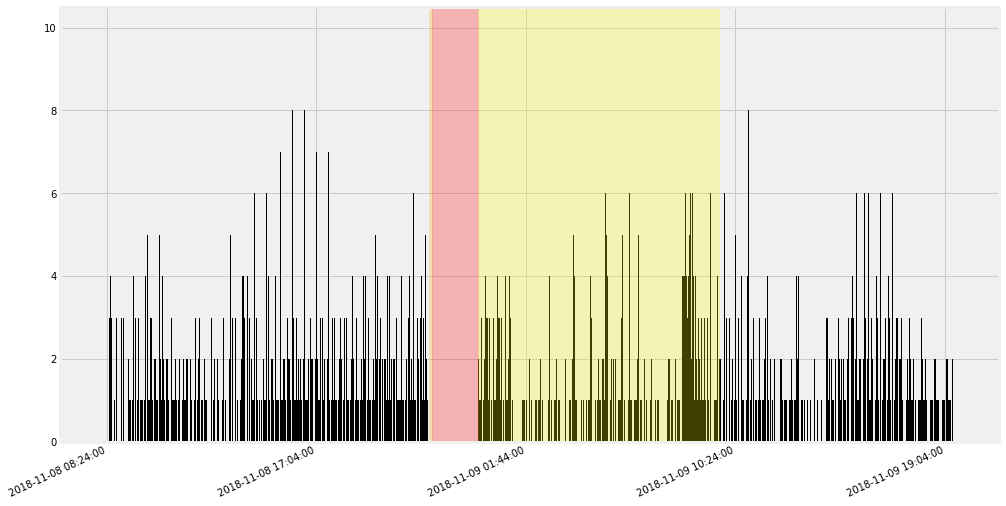

ZIP: 165468, Population: 9, Freq: 30, coverage: 0.23
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:50:00 started @ 2018-11-08 21:41:00 (30006)
end anomaly after 126 minutes
cleared anomaly @ 2018-11-09 09:49:00 started @ 2018-11-08 21:41:00
detected anomaly @ 2018-11-09 10:17:00 started @ 2018-11-09 10:08:00 (30753)
decline anomaly @ 2018-11-09 10:22:00 started @ 2018-11-09 10:08:00 idx:30758, len:14, thres:30
detected anomaly @ 2018-11-09 10:47:00 started @ 2018-11-09 10:38:00 (30783)
decline anomaly @ 2018-11-09 10:48:00 started @ 2018-11-09 10:38:00 idx:30784, len:10, thres:30
detected anomaly @ 2018-11-09 11:20:00 started @ 2018-11-09 11:11:00 (30816)
decline anomaly @ 2018-11-09 11:22:00 started @ 2018-11-09 11:11:00 idx:30818, len:11, thres:30
detected anomaly @ 2018-11-09 11:34:00 started @ 2018-11-09 11:25:00 (30830)
decline anomaly @ 20

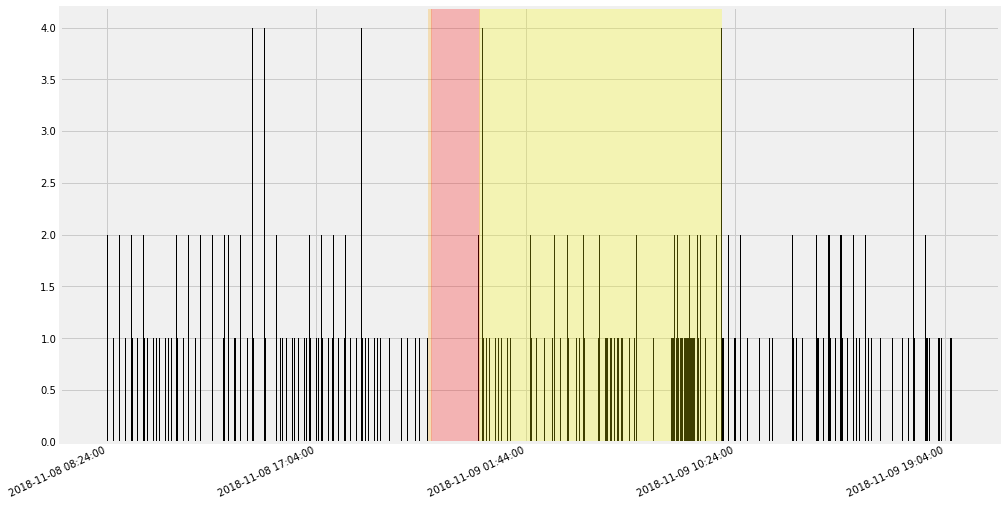

ZIP: 167819, Population: 0, Freq: 1, coverage: 0.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
[]


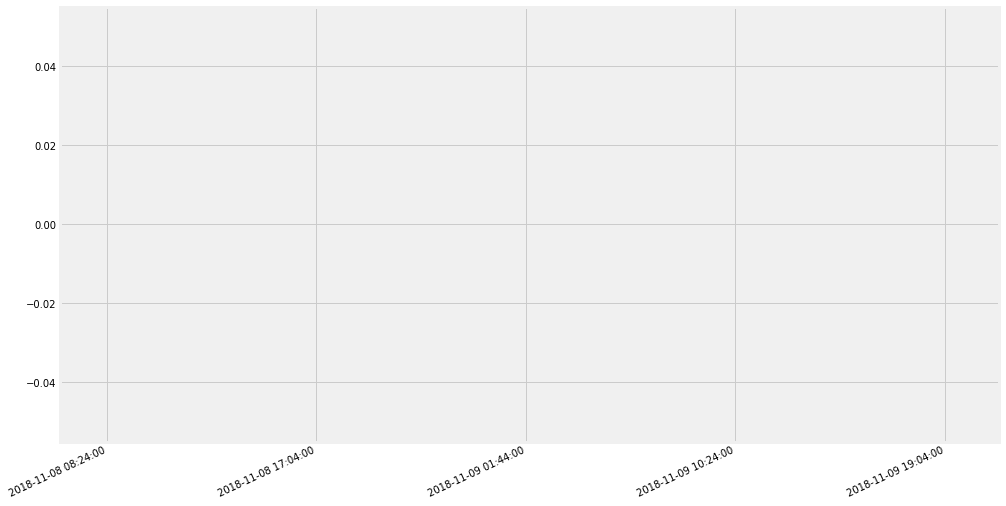

ZIP: 166280, Population: 226, Freq: 30, coverage: 1.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


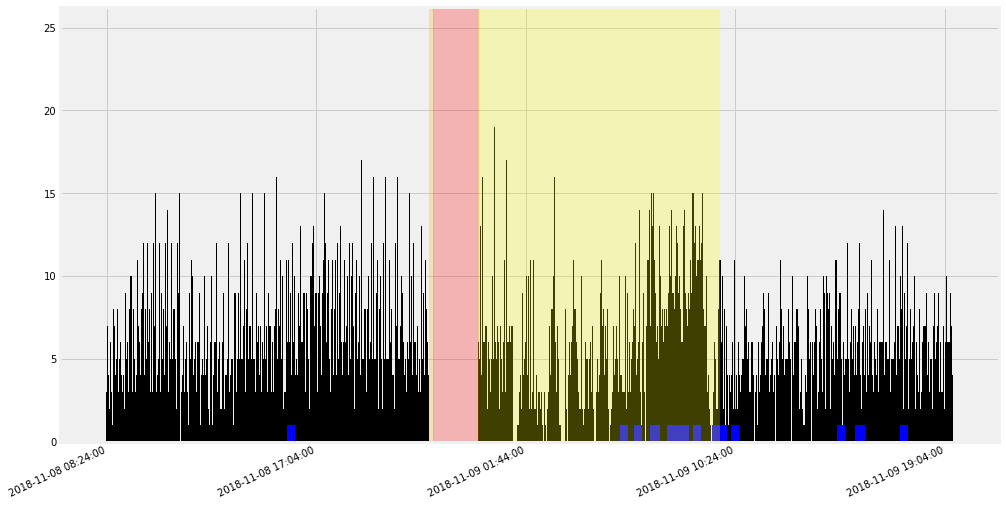

ZIP: 164959, Population: 13, Freq: 30, coverage: 0.23
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:55:00 started @ 2018-11-08 21:46:00 (30011)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 09:47:00 started @ 2018-11-08 21:46:00
detected anomaly @ 2018-11-09 10:53:00 started @ 2018-11-09 10:44:00 (30789)
decline anomaly @ 2018-11-09 10:55:00 started @ 2018-11-09 10:44:00 idx:30791, len:11, thres:30
detected anomaly @ 2018-11-09 11:19:00 started @ 2018-11-09 11:10:00 (30815)
decline anomaly @ 2018-11-09 11:27:00 started @ 2018-11-09 11:10:00 idx:30823, len:17, thres:30
detected anomaly @ 2018-11-09 12:53:00 started @ 2018-11-09 12:44:00 (30909)
decline anomaly @ 2018-11-09 12:55:00 started @ 2018-11-09 12:44:00 idx:30911, len:11, thres:30
detected anomaly @ 2018-11-09 13:59:00 started @ 2018-11-09 13:50:00 (30975)
decline anomaly @ 2

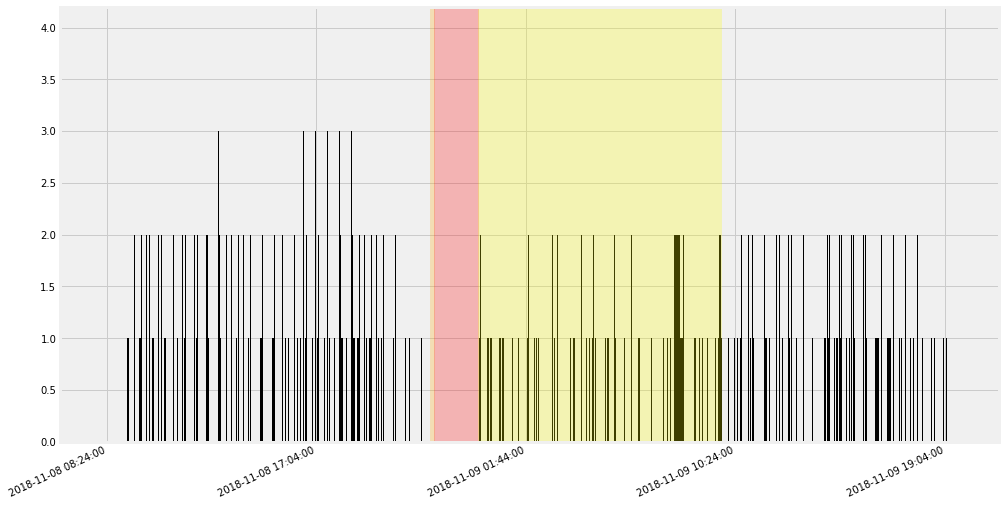

ZIP: 172589, Population: 19, Freq: 30, coverage: 0.4
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:54:00 started @ 2018-11-08 21:45:00 (30010)
end anomaly after 120 minutes
[{'start': 30001, 'detect': 30010, 'end': 30121, 'clear': 31300}]


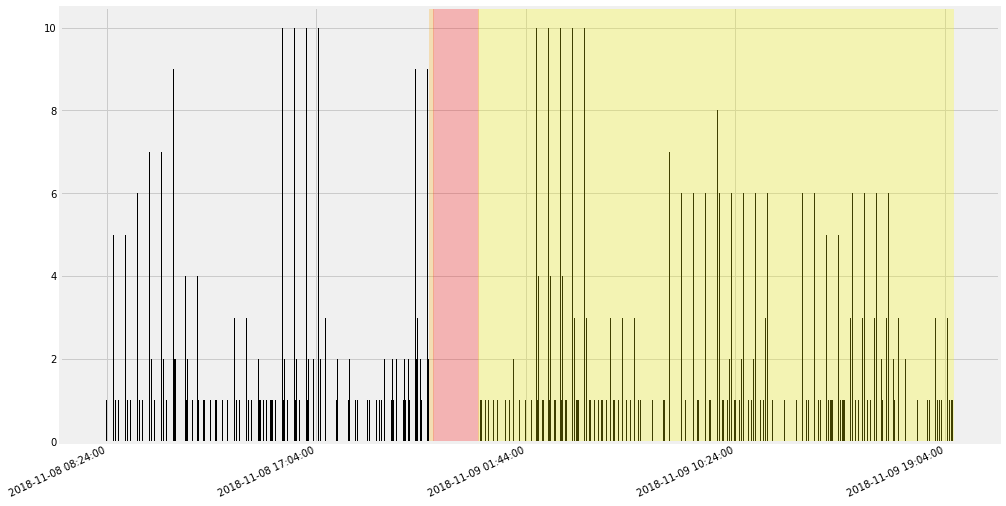

ZIP: 165457, Population: 32, Freq: 30, coverage: 0.5
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30122, 'clear': 30720}]


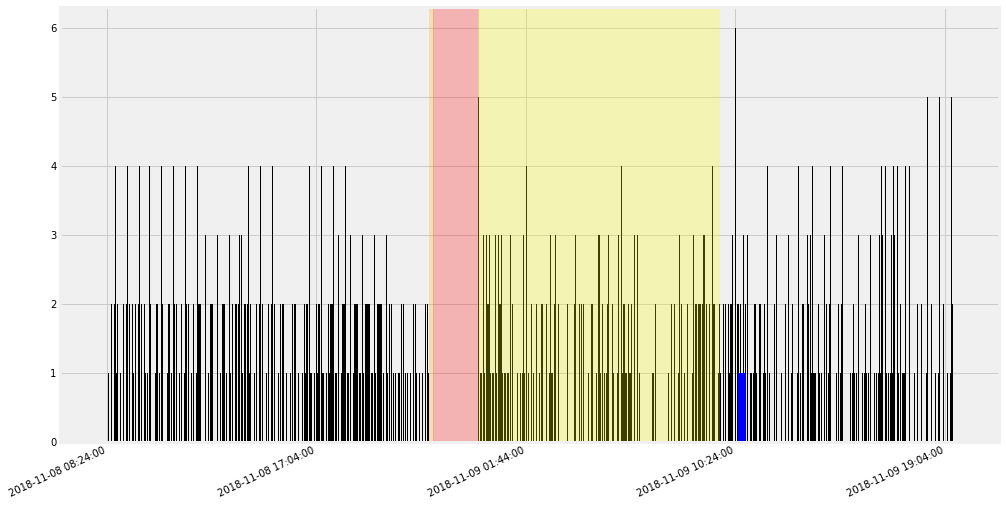

ZIP: 164771, Population: 69, Freq: 30, coverage: 0.87
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


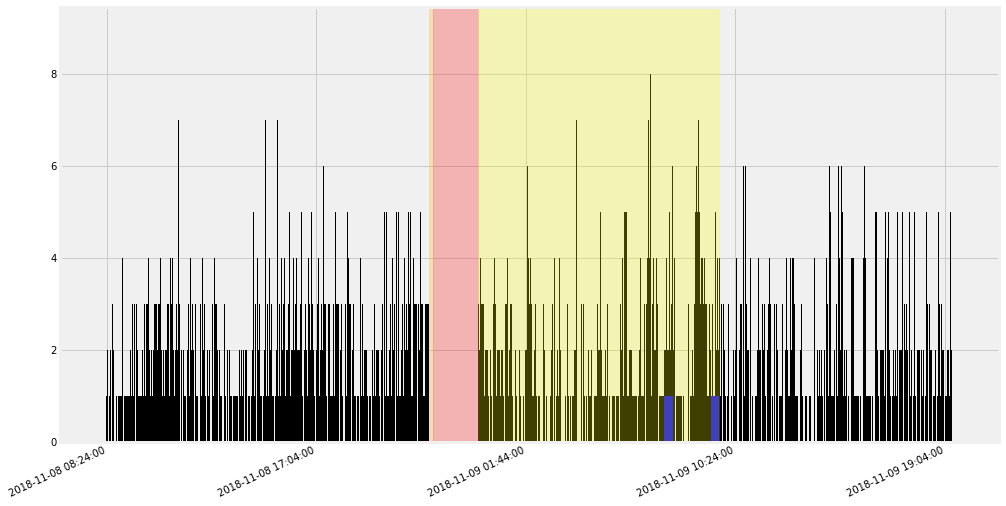

ZIP: 165009, Population: 46, Freq: 30, coverage: 0.6
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:51:00 started @ 2018-11-08 21:42:00 (30007)
end anomaly after 124 minutes
cleared anomaly @ 2018-11-09 09:42:00 started @ 2018-11-08 21:42:00
[{'start': 29998, 'detect': 30007, 'end': 30122, 'clear': 30718}]


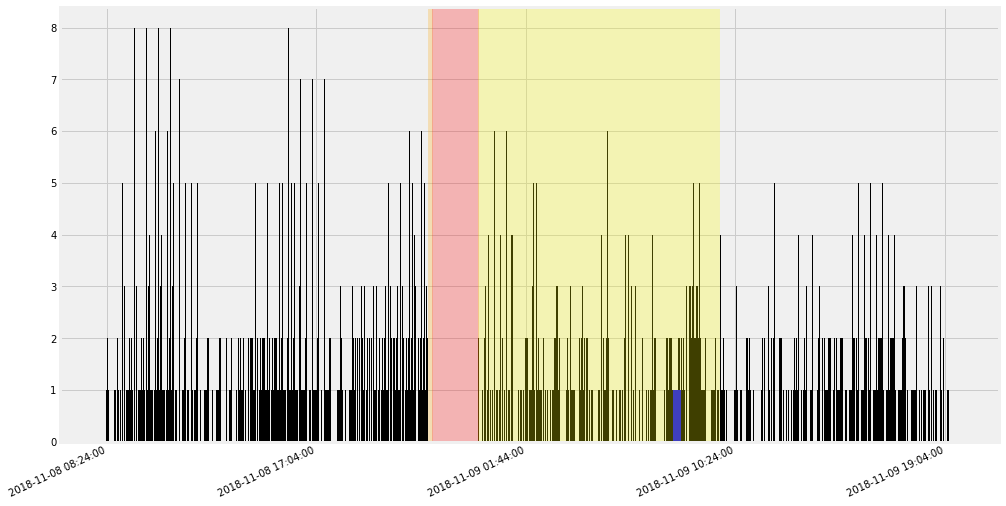

ZIP: 166380, Population: 10, Freq: 30, coverage: 0.3
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:56:00 started @ 2018-11-08 21:47:00 (30012)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 11:18:00 started @ 2018-11-08 21:47:00
detected anomaly @ 2018-11-09 12:02:00 started @ 2018-11-09 11:53:00 (30858)
decline anomaly @ 2018-11-09 12:17:00 started @ 2018-11-09 11:53:00 idx:30873, len:24, thres:30
detected anomaly @ 2018-11-09 13:28:00 started @ 2018-11-09 13:19:00 (30944)
decline anomaly @ 2018-11-09 13:36:00 started @ 2018-11-09 13:19:00 idx:30952, len:17, thres:30
detected anomaly @ 2018-11-09 14:01:00 started @ 2018-11-09 13:52:00 (30977)
decline anomaly @ 2018-11-09 14:03:00 started @ 2018-11-09 13:52:00 idx:30979, len:11, thres:30
detected anomaly @ 2018-11-09 14:31:00 started @ 2018-11-09 14:22:00 (31007)
decline anomaly @ 20

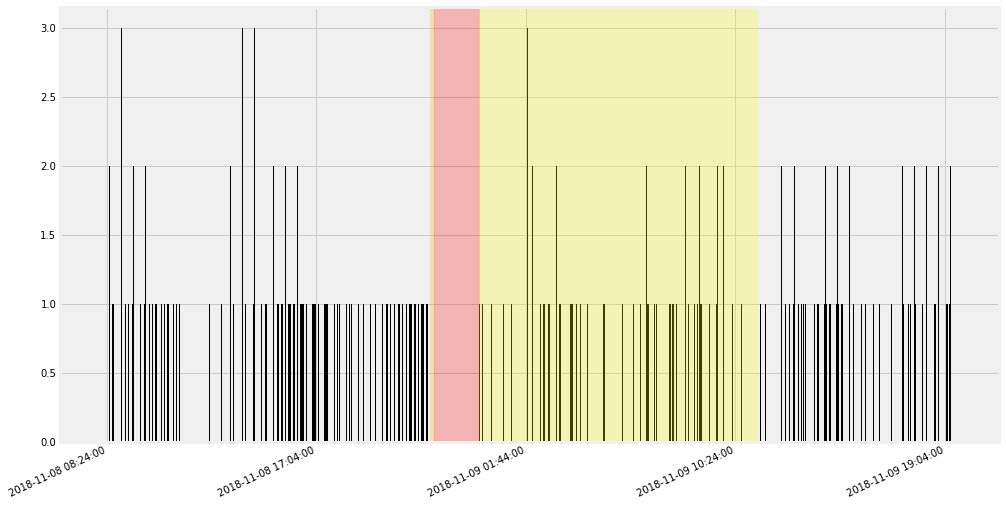

ZIP: 168124, Population: 0, Freq: 1, coverage: 0.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
[]


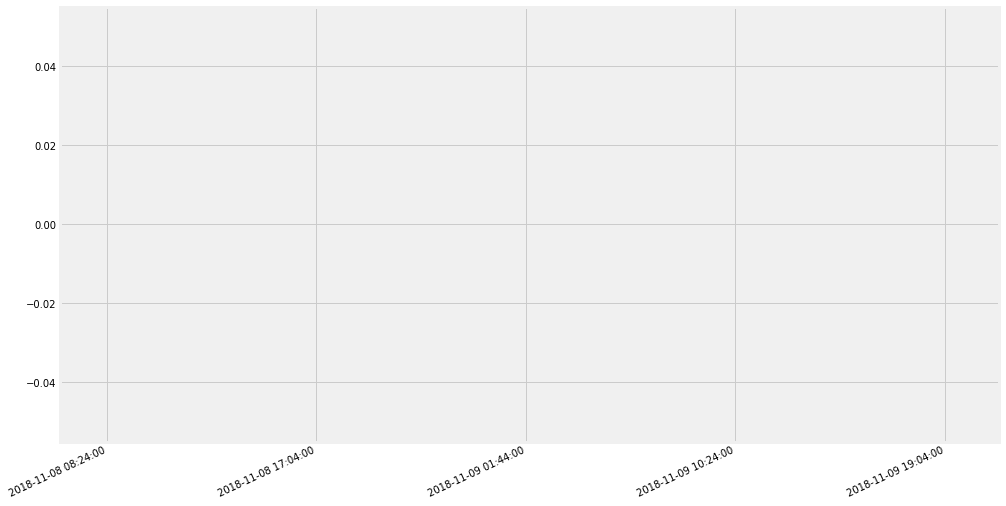

ZIP: 164998, Population: 3, Freq: 90, coverage: 0.03
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:47:00 started @ 2018-11-08 20:38:00 (29943)
decline anomaly @ 2018-11-08 21:07:00 started @ 2018-11-08 20:38:00 idx:29963, len:29, thres:30
detected anomaly @ 2018-11-08 21:17:00 started @ 2018-11-08 21:08:00 (29973)
decline anomaly @ 2018-11-08 21:37:00 started @ 2018-11-08 21:08:00 idx:29993, len:29, thres:30
detected anomaly @ 2018-11-08 21:47:00 started @ 2018-11-08 21:38:00 (30003)
end anomaly after 149 minutes
cleared anomaly @ 2018-11-09 10:07:00 started @ 2018-11-08 21:38:00
detected anomaly @ 2018-11-09 10:17:00 started @ 2018-11-09 10:08:00 (30753)
decline anomaly @ 2018-11-09 10:37:00 started @ 2018-11-09 10:08:00 idx:30773, len:29, thres:30
detected anomaly @ 2018-11-09 10:47:00 started @ 2018-11-09 10:38:00 (30783)
decline anomaly @ 20

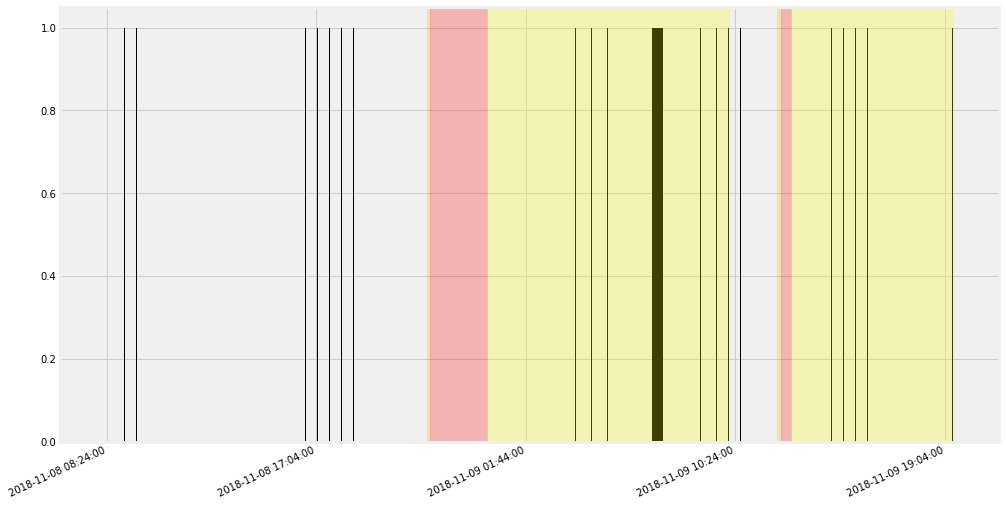

ZIP: 165953, Population: 4, Freq: 60, coverage: 0.07
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:54:00 started @ 2018-11-08 21:45:00 (30010)
end anomaly after 120 minutes
[{'start': 30001, 'detect': 30010, 'end': 30121, 'clear': 31300}]


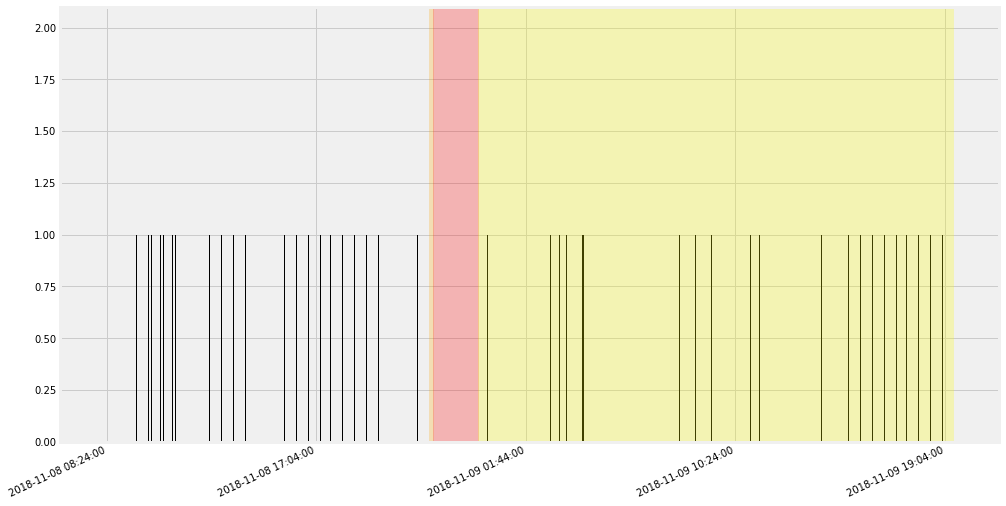

ZIP: 172119, Population: 18, Freq: 30, coverage: 0.4
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 14:49:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 31025}]


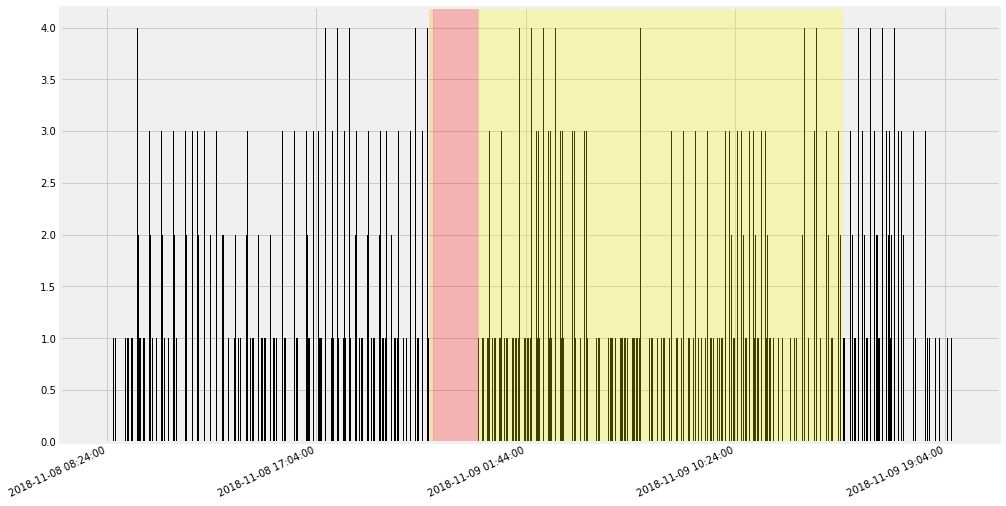

ZIP: 166278, Population: 94, Freq: 30, coverage: 0.8
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:51:00 started @ 2018-11-08 21:42:00 (30007)
end anomaly after 124 minutes
cleared anomaly @ 2018-11-09 09:42:00 started @ 2018-11-08 21:42:00
[{'start': 29998, 'detect': 30007, 'end': 30122, 'clear': 30718}]


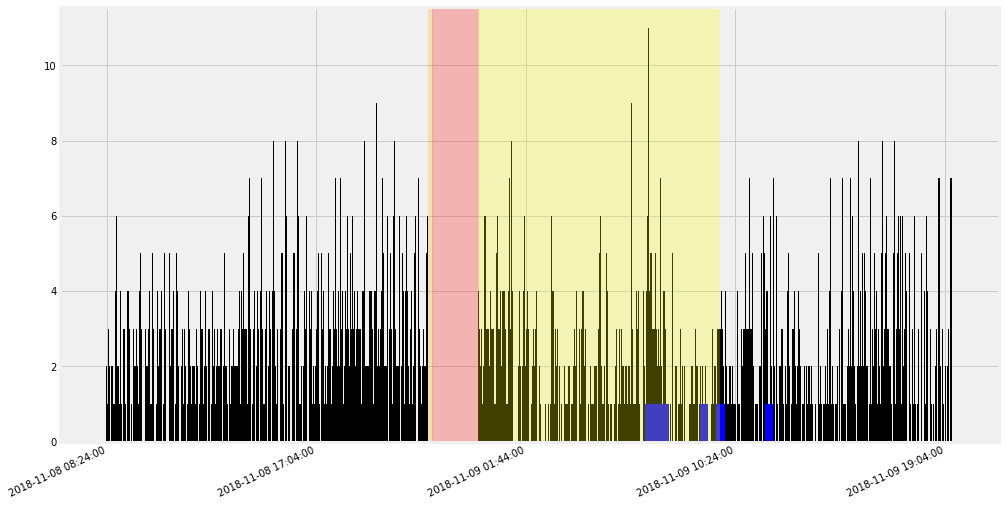

ZIP: 164817, Population: 2, Freq: 30, coverage: 0.07
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:07:00 started @ 2018-11-08 21:58:00 (30023)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 14:47:00 started @ 2018-11-08 21:58:00
detected anomaly @ 2018-11-09 14:57:00 started @ 2018-11-09 14:48:00 (31033)
decline anomaly @ 2018-11-09 14:59:00 started @ 2018-11-09 14:48:00 idx:31035, len:11, thres:30
detected anomaly @ 2018-11-09 15:09:00 started @ 2018-11-09 15:00:00 (31045)
decline anomaly @ 2018-11-09 15:17:00 started @ 2018-11-09 15:00:00 idx:31053, len:17, thres:30
detected anomaly @ 2018-11-09 15:27:00 started @ 2018-11-09 15:18:00 (31063)
decline anomaly @ 2018-11-09 15:29:00 started @ 2018-11-09 15:18:00 idx:31065, len:11, thres:30
detected anomaly @ 2018-11-09 15:39:00 started @ 2018-11-09 15:30:00 (31075)
decline anomaly @ 20

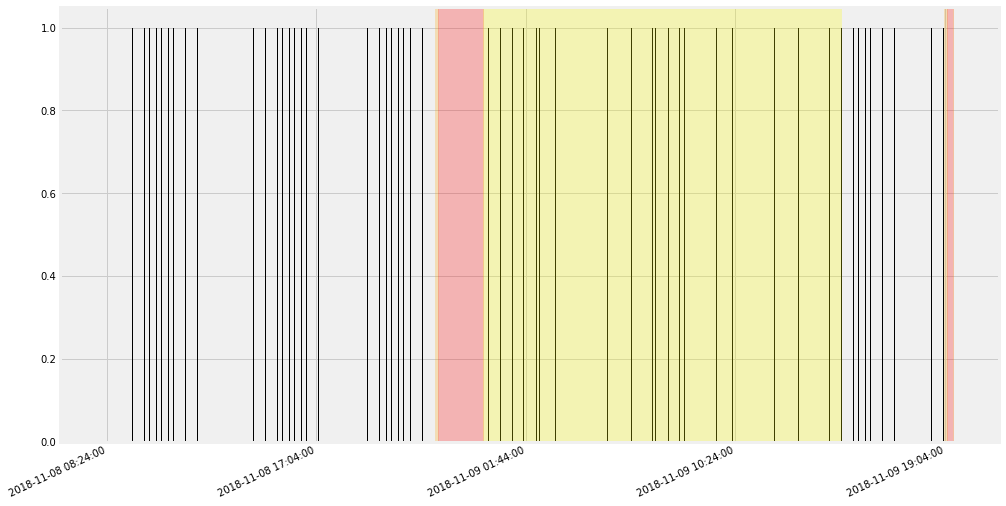

ZIP: 165977, Population: 92, Freq: 30, coverage: 0.97
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


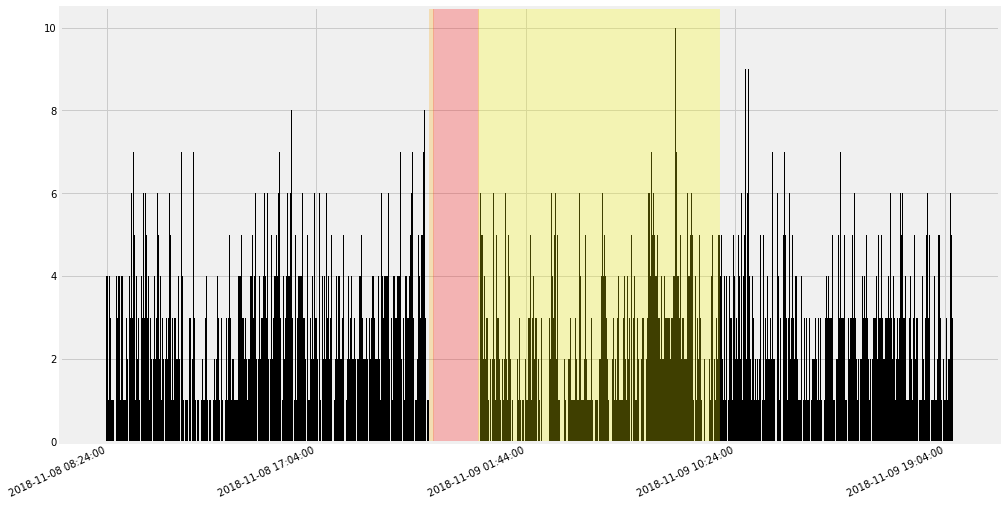

ZIP: 166275, Population: 47, Freq: 30, coverage: 0.7
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


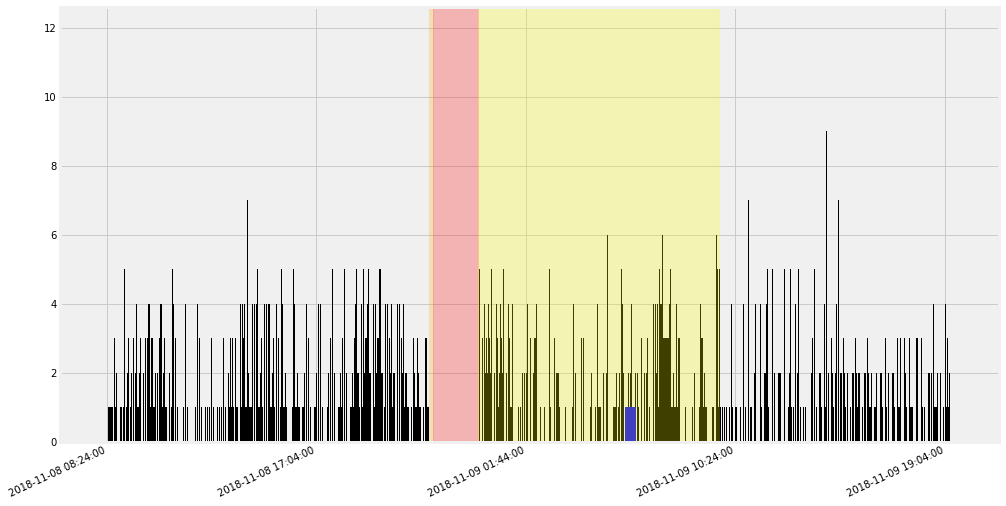

ZIP: 165854, Population: 7, Freq: 30, coverage: 0.2
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:57:00 started @ 2018-11-08 21:48:00 (30013)
end anomaly after 121 minutes
[{'start': 30004, 'detect': 30013, 'end': 30125, 'clear': 31300}]


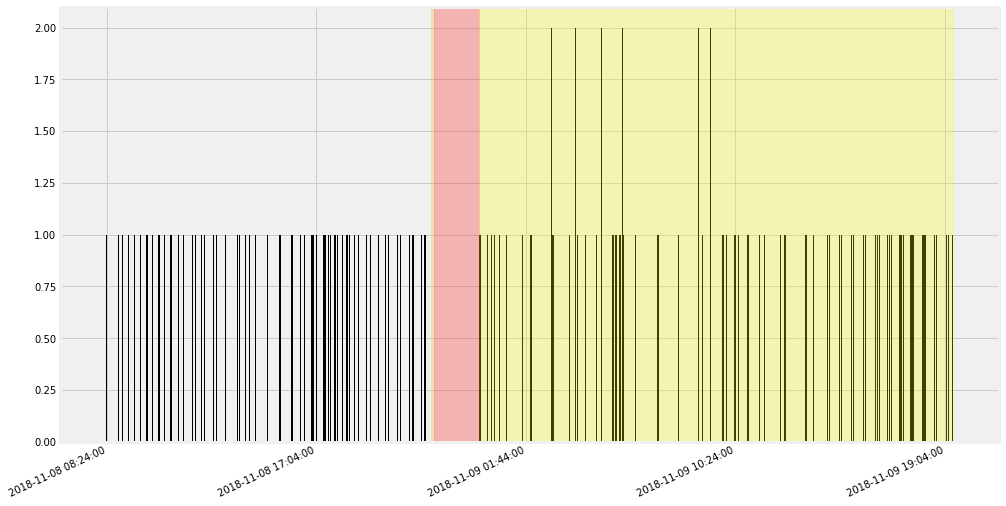

ZIP: 172058, Population: 74, Freq: 30, coverage: 0.9
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 13:00:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30916}]


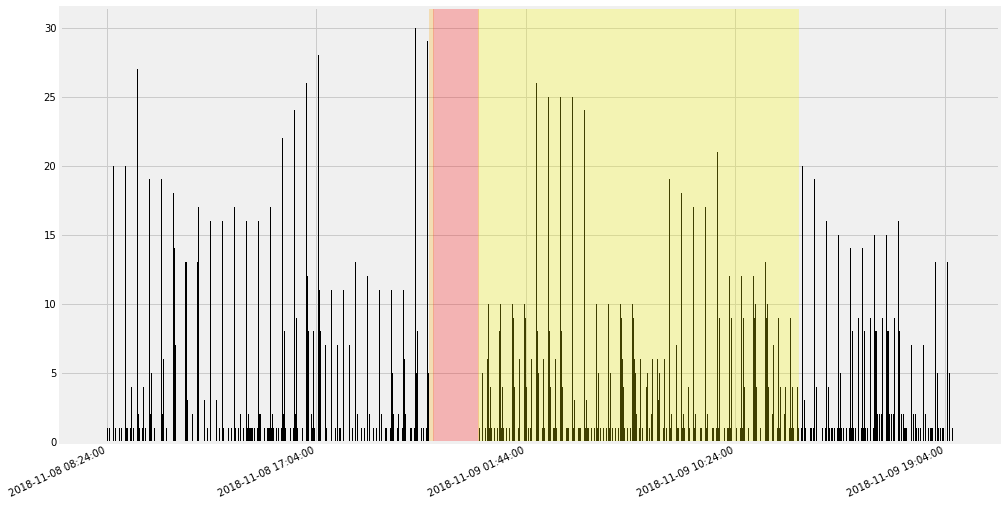

ZIP: 152863, Population: 4, Freq: 30, coverage: 0.07
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:36:00 started @ 2018-11-08 20:27:00 (29932)
decline anomaly @ 2018-11-08 20:38:00 started @ 2018-11-08 20:27:00 idx:29934, len:11, thres:30
detected anomaly @ 2018-11-08 21:06:00 started @ 2018-11-08 20:57:00 (29962)
decline anomaly @ 2018-11-08 21:08:00 started @ 2018-11-08 20:57:00 idx:29964, len:11, thres:30
detected anomaly @ 2018-11-08 21:36:00 started @ 2018-11-08 21:27:00 (29992)
decline anomaly @ 2018-11-08 21:38:00 started @ 2018-11-08 21:27:00 idx:29994, len:11, thres:30
detected anomaly @ 2018-11-08 22:05:00 started @ 2018-11-08 21:56:00 (30021)
end anomaly after 120 minutes
[{'start': 30012, 'detect': 30021, 'end': 30132, 'clear': 31300}]


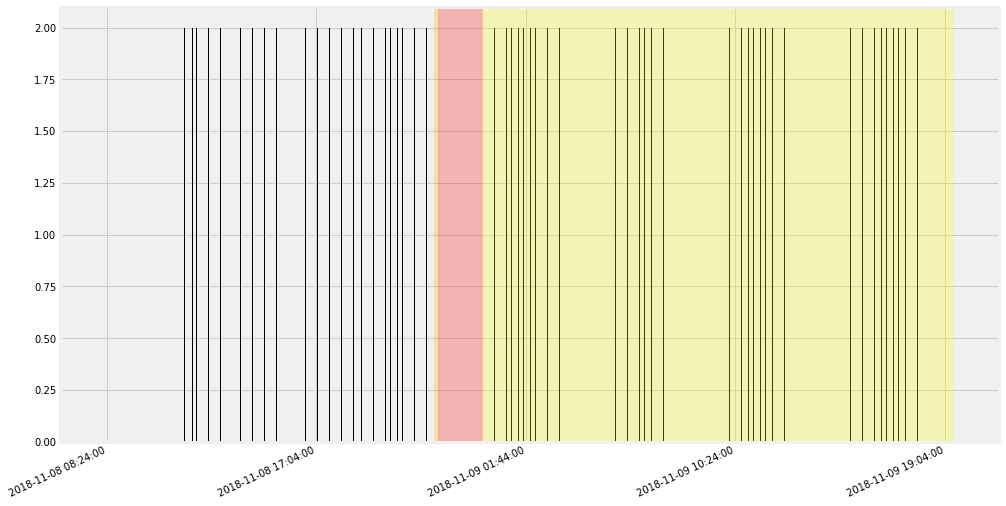

ZIP: 166081, Population: 2, Freq: 60, coverage: 0.03
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:01:00 started @ 2018-11-08 21:52:00 (30017)
end anomaly after 120 minutes
[{'start': 30008, 'detect': 30017, 'end': 30128, 'clear': 31300}]


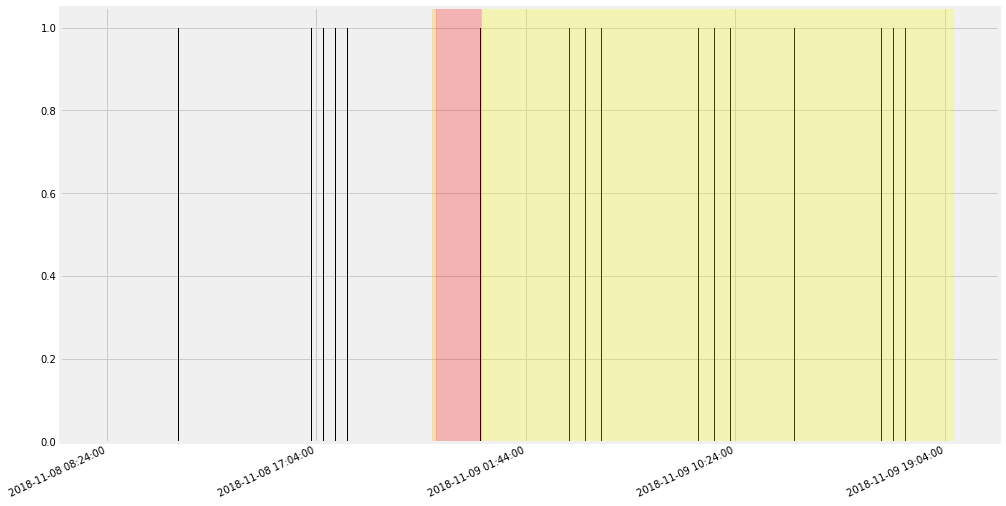

ZIP: 169987, Population: 0, Freq: 1, coverage: 0.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
[]


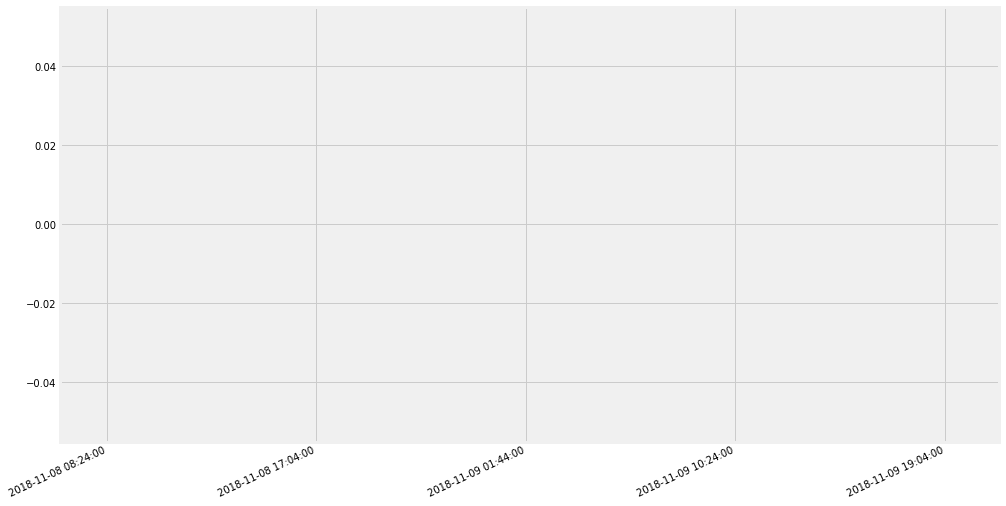

ZIP: 166384, Population: 187, Freq: 30, coverage: 1.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


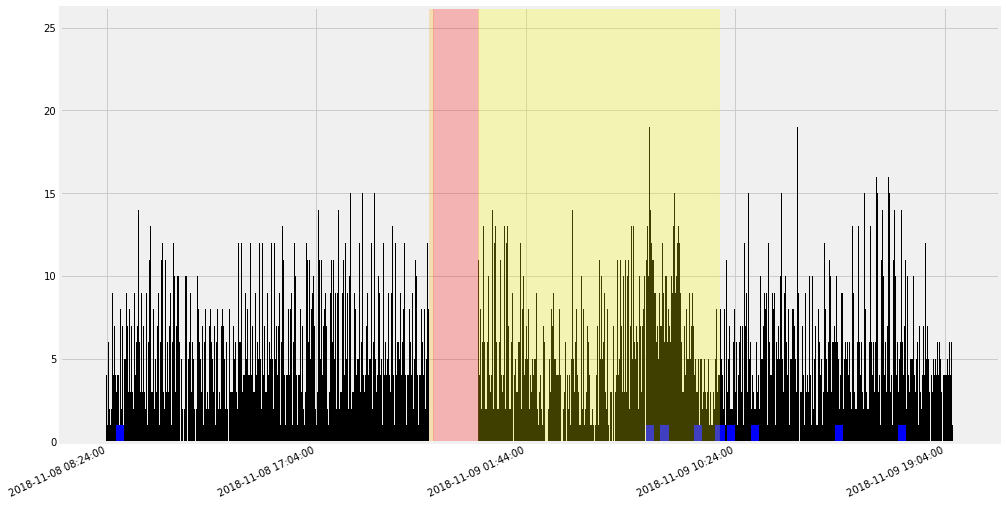

ZIP: 166223, Population: 238, Freq: 30, coverage: 1.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


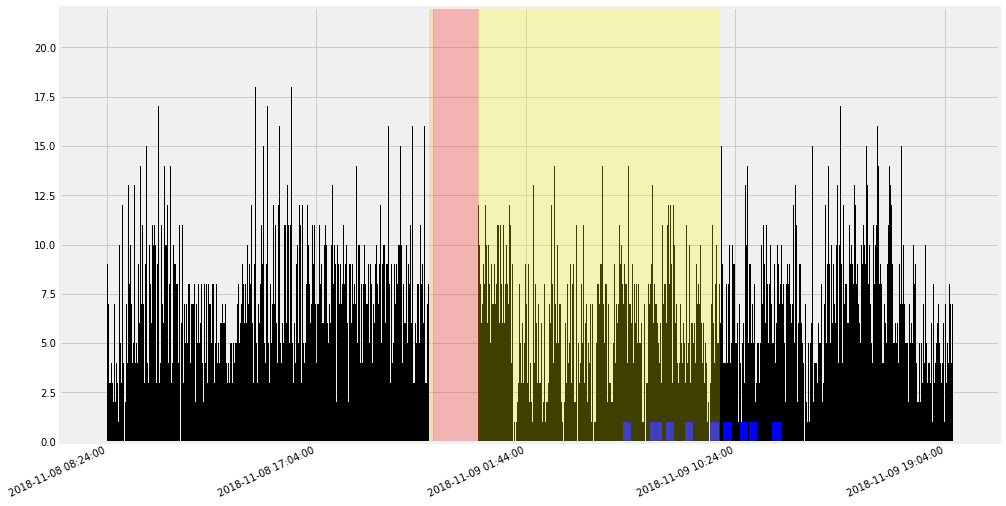

ZIP: 165863, Population: 6, Freq: 60, coverage: 0.1
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:58:00 started @ 2018-11-08 21:49:00 (30014)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 09:56:00 started @ 2018-11-08 21:49:00
detected anomaly @ 2018-11-09 10:06:00 started @ 2018-11-09 09:57:00 (30742)
decline anomaly @ 2018-11-09 10:07:00 started @ 2018-11-09 09:57:00 idx:30743, len:10, thres:30
detected anomaly @ 2018-11-09 10:17:00 started @ 2018-11-09 10:08:00 (30753)
decline anomaly @ 2018-11-09 10:18:00 started @ 2018-11-09 10:08:00 idx:30754, len:10, thres:30
detected anomaly @ 2018-11-09 10:36:00 started @ 2018-11-09 10:27:00 (30772)
decline anomaly @ 2018-11-09 10:37:00 started @ 2018-11-09 10:27:00 idx:30773, len:10, thres:30
detected anomaly @ 2018-11-09 10:47:00 started @ 2018-11-09 10:38:00 (30783)
decline anomaly @ 201

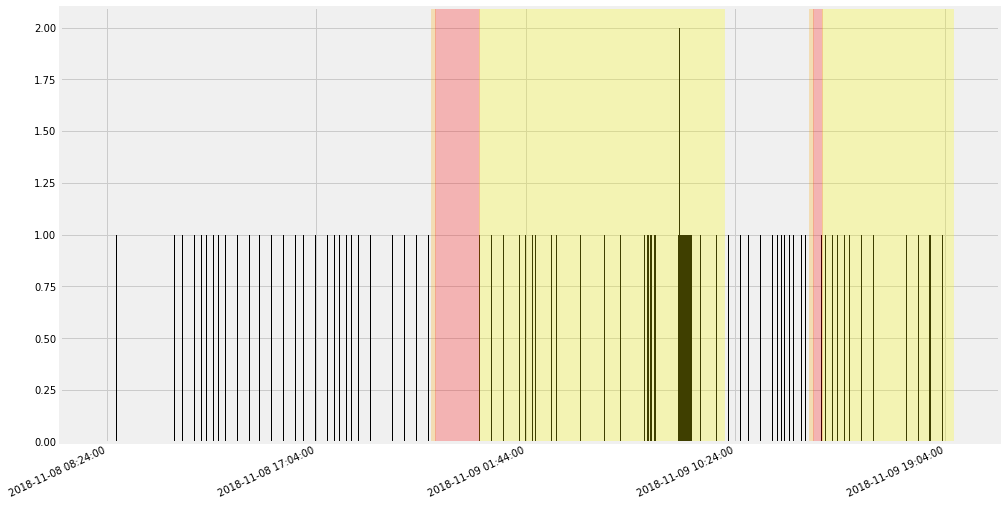

ZIP: 164639, Population: 132, Freq: 30, coverage: 0.8
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


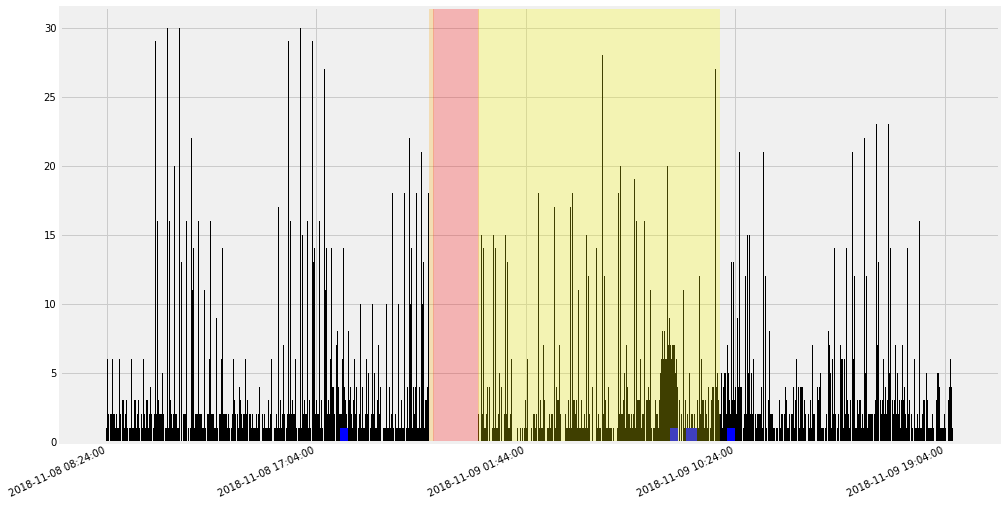

ZIP: 165477, Population: 20, Freq: 30, coverage: 0.5
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:43:00 started @ 2018-11-08 21:43:00
detected anomaly @ 2018-11-09 11:14:00 started @ 2018-11-09 11:05:00 (30810)
decline anomaly @ 2018-11-09 11:16:00 started @ 2018-11-09 11:05:00 idx:30812, len:11, thres:30
[{'start': 29999, 'detect': 30008, 'end': 30121, 'clear': 30719}]


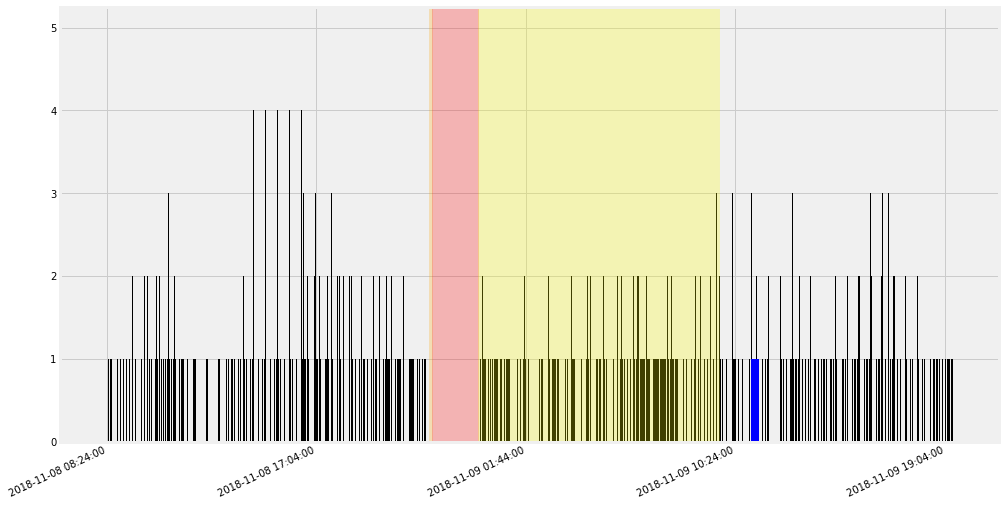

ZIP: 152992, Population: 2, Freq: 105, coverage: 0.02
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:40:00 started @ 2018-11-08 20:31:00 (29936)
end anomaly after 45 minutes
[{'start': 29927, 'detect': 29936, 'end': 29972, 'clear': 31300}]


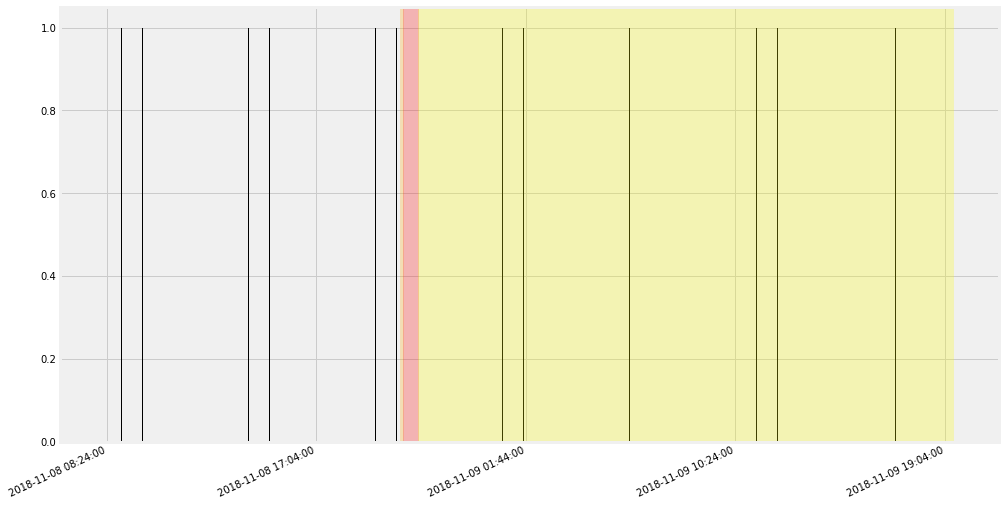

ZIP: 165964, Population: 94, Freq: 30, coverage: 0.87
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


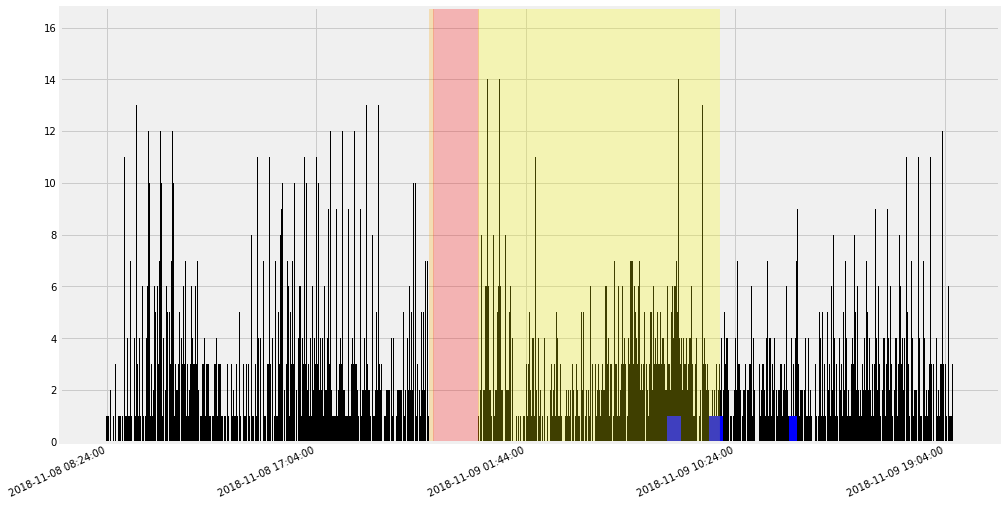

ZIP: 166073, Population: 3, Freq: 90, coverage: 0.03
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:01:00 started @ 2018-11-08 21:52:00 (30017)
end anomaly after 120 minutes
[{'start': 30008, 'detect': 30017, 'end': 30128, 'clear': 31300}]


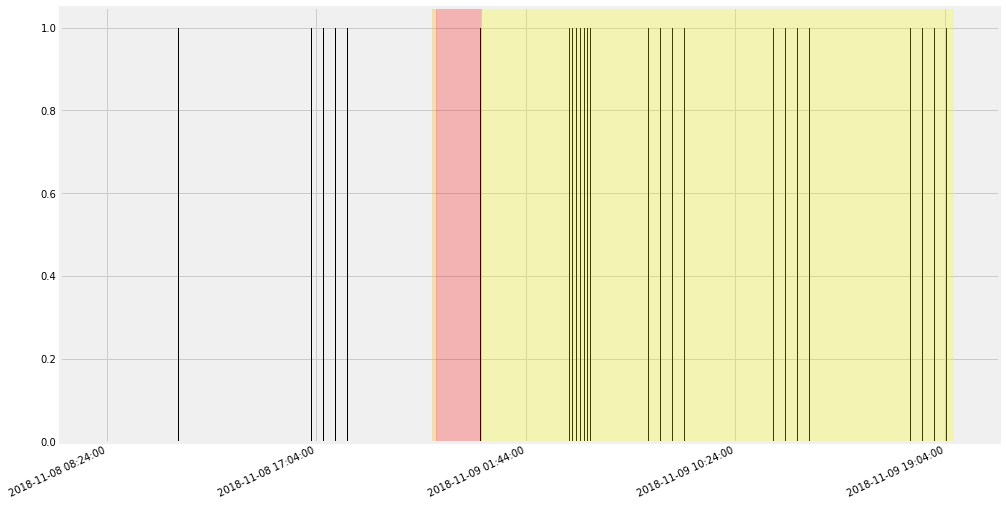

ZIP: 164972, Population: 69, Freq: 30, coverage: 0.93
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


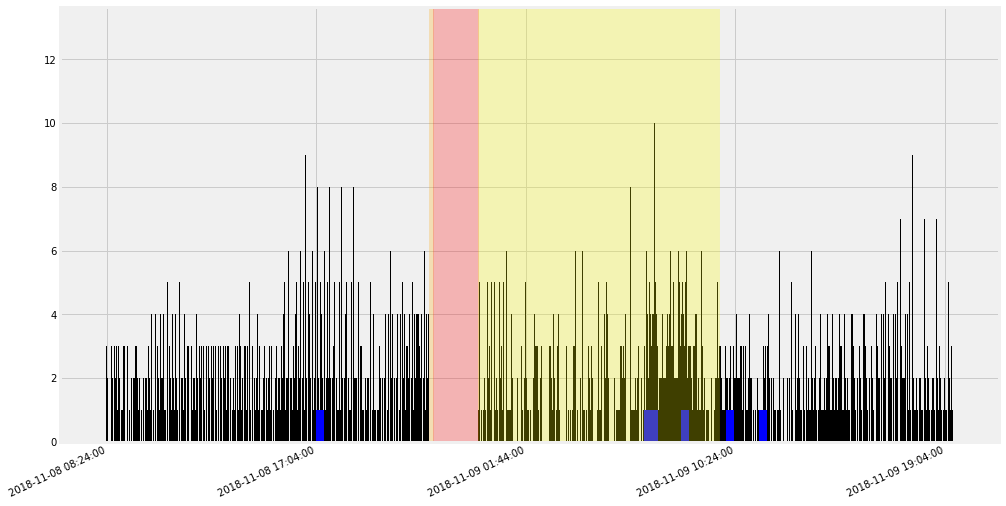

ZIP: 166382, Population: 6, Freq: 30, coverage: 0.13
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:54:00 started @ 2018-11-08 20:45:00 (29950)
decline anomaly @ 2018-11-08 20:59:00 started @ 2018-11-08 20:45:00 idx:29955, len:14, thres:30
detected anomaly @ 2018-11-08 21:24:00 started @ 2018-11-08 21:15:00 (29980)
decline anomaly @ 2018-11-08 21:29:00 started @ 2018-11-08 21:15:00 idx:29985, len:14, thres:30
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 135 minutes
cleared anomaly @ 2018-11-09 11:39:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 11:59:00 started @ 2018-11-09 11:50:00 (30855)
decline anomaly @ 2018-11-09 12:02:00 started @ 2018-11-09 11:50:00 idx:30858, len:12, thres:30
detected anomaly @ 2018-11-09 12:14:00 started @ 2018-11-09 12:05:00 (30870)
decline anomaly @ 20

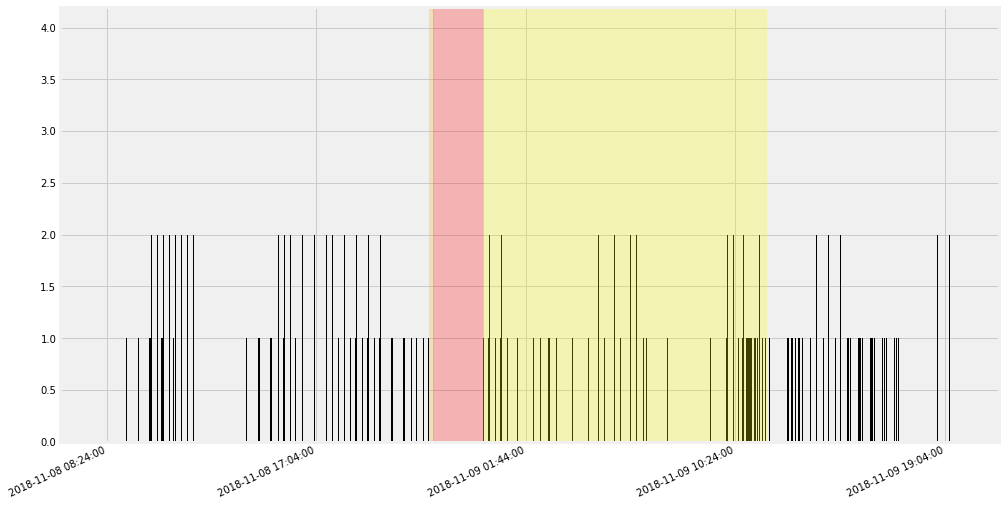

ZIP: 164957, Population: 92, Freq: 30, coverage: 0.97
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


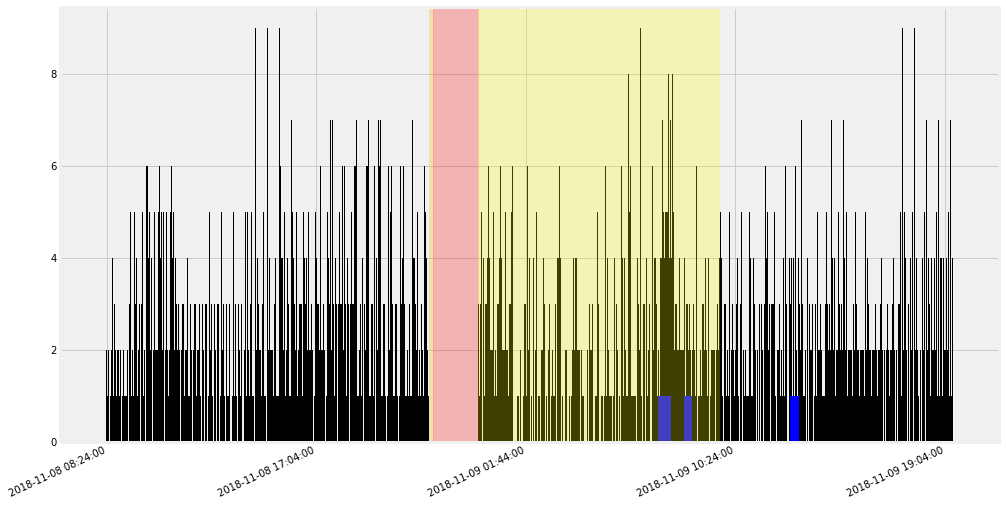

ZIP: 164961, Population: 63, Freq: 30, coverage: 0.73
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 123 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30123, 'clear': 30720}]


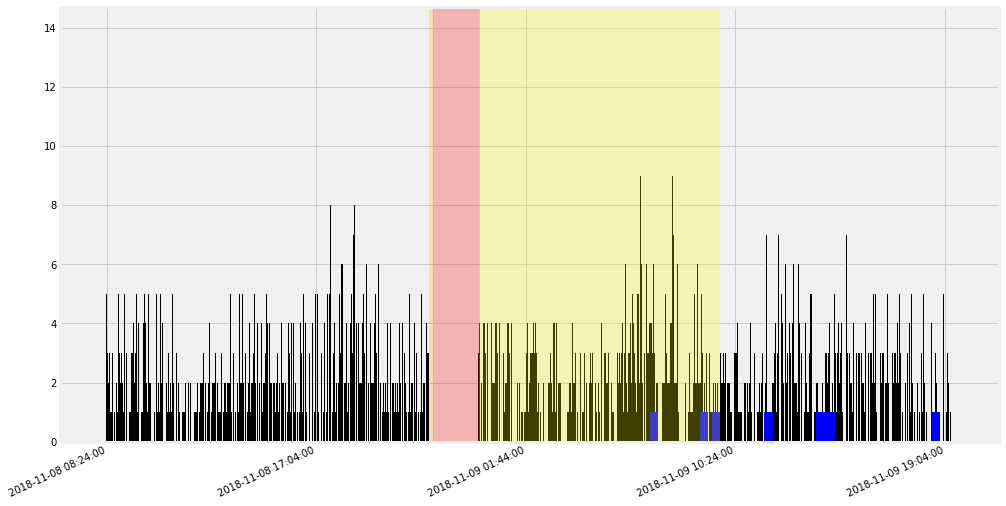

ZIP: 165948, Population: 13, Freq: 30, coverage: 0.37
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:56:00 started @ 2018-11-08 21:47:00 (30012)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:48:00 started @ 2018-11-08 21:47:00
[{'start': 30003, 'detect': 30012, 'end': 30124, 'clear': 30724}]


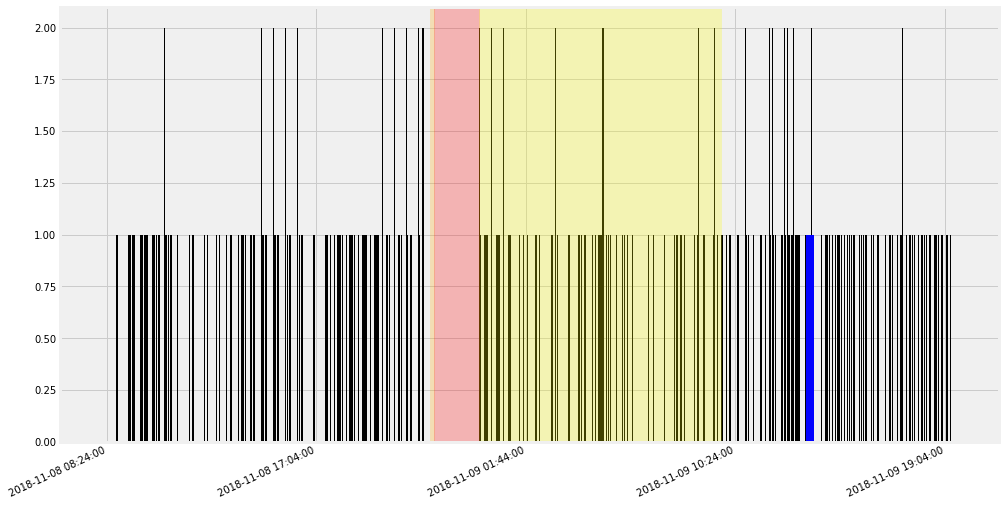

ZIP: 166218, Population: 103, Freq: 30, coverage: 0.83
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


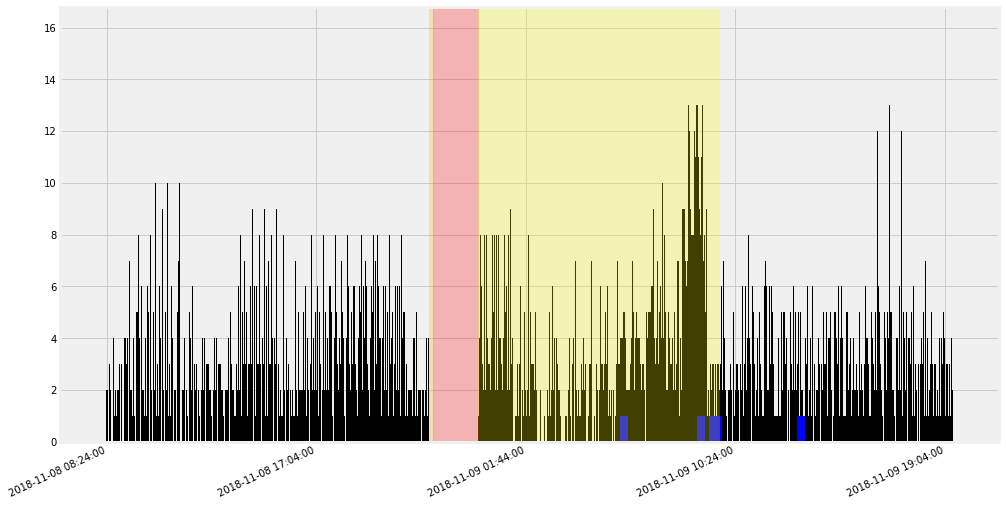

ZIP: 165000, Population: 6, Freq: 30, coverage: 0.2
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:33:00 started @ 2018-11-08 20:24:00 (29929)
decline anomaly @ 2018-11-08 20:34:00 started @ 2018-11-08 20:24:00 idx:29930, len:10, thres:30
detected anomaly @ 2018-11-08 21:03:00 started @ 2018-11-08 20:54:00 (29959)
decline anomaly @ 2018-11-08 21:04:00 started @ 2018-11-08 20:54:00 idx:29960, len:10, thres:30
detected anomaly @ 2018-11-08 21:33:00 started @ 2018-11-08 21:24:00 (29989)
decline anomaly @ 2018-11-08 21:34:00 started @ 2018-11-08 21:24:00 idx:29990, len:10, thres:30
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 127 minutes
[{'start': 30000, 'detect': 30009, 'end': 30127, 'clear': 31300}]


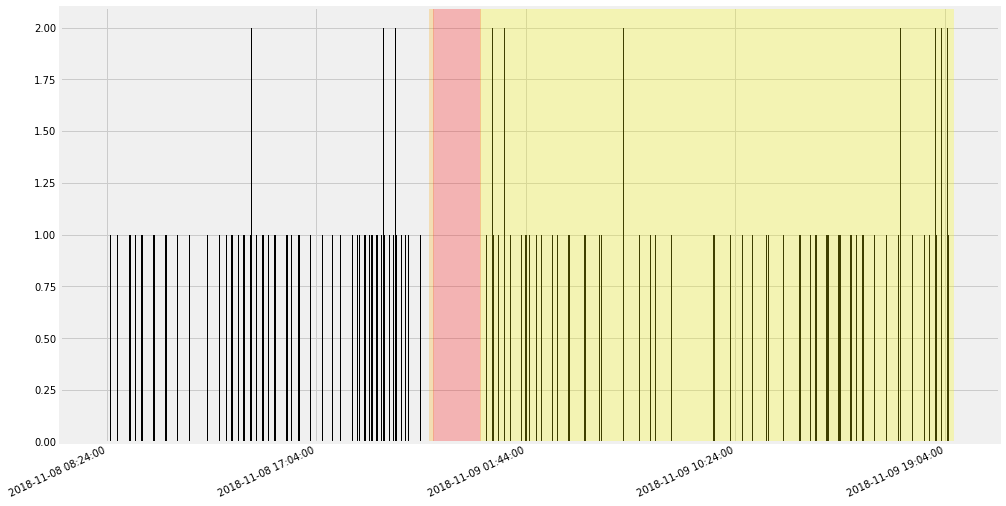

ZIP: 165955, Population: 2, Freq: 30, coverage: 0.03
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:19:00 started @ 2018-11-08 22:10:00 (30035)
end anomaly after 120 minutes
[{'start': 30026, 'detect': 30035, 'end': 30146, 'clear': 31300}]


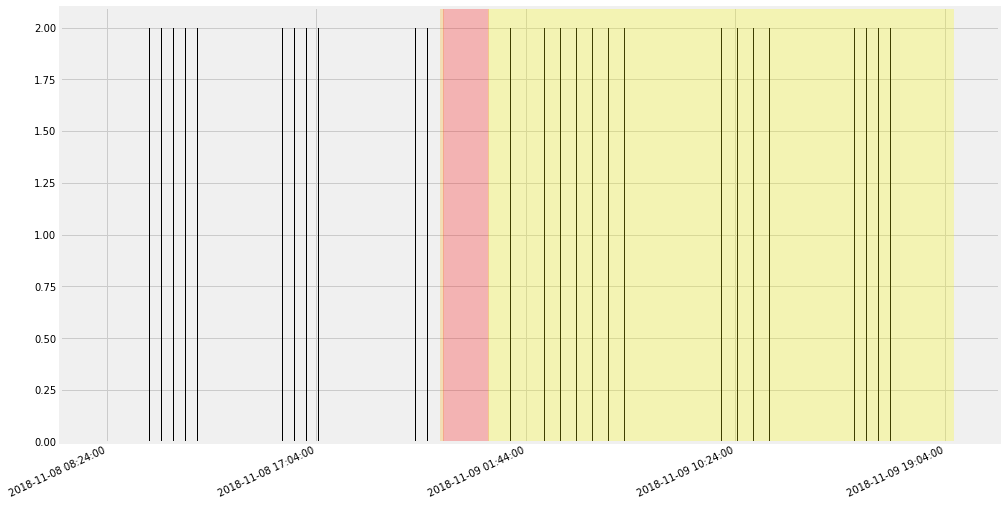

ZIP: 164989, Population: 59, Freq: 30, coverage: 0.6
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


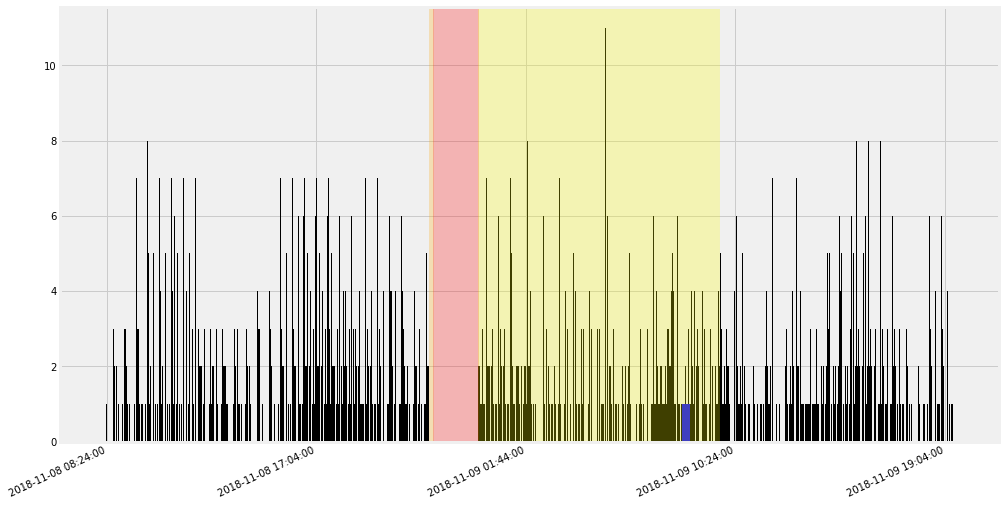

ZIP: 165949, Population: 4, Freq: 30, coverage: 0.13
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:02:00 started @ 2018-11-08 21:53:00 (30018)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 10:02:00 started @ 2018-11-08 21:53:00
detected anomaly @ 2018-11-09 10:13:00 started @ 2018-11-09 10:04:00 (30749)
decline anomaly @ 2018-11-09 10:24:00 started @ 2018-11-09 10:04:00 idx:30760, len:20, thres:30
detected anomaly @ 2018-11-09 10:43:00 started @ 2018-11-09 10:34:00 (30779)
decline anomaly @ 2018-11-09 10:55:00 started @ 2018-11-09 10:34:00 idx:30791, len:21, thres:30
detected anomaly @ 2018-11-09 11:43:00 started @ 2018-11-09 11:34:00 (30839)
decline anomaly @ 2018-11-09 11:44:00 started @ 2018-11-09 11:34:00 idx:30840, len:10, thres:30
detected anomaly @ 2018-11-09 12:13:00 started @ 2018-11-09 12:04:00 (30869)
decline anomaly @ 20

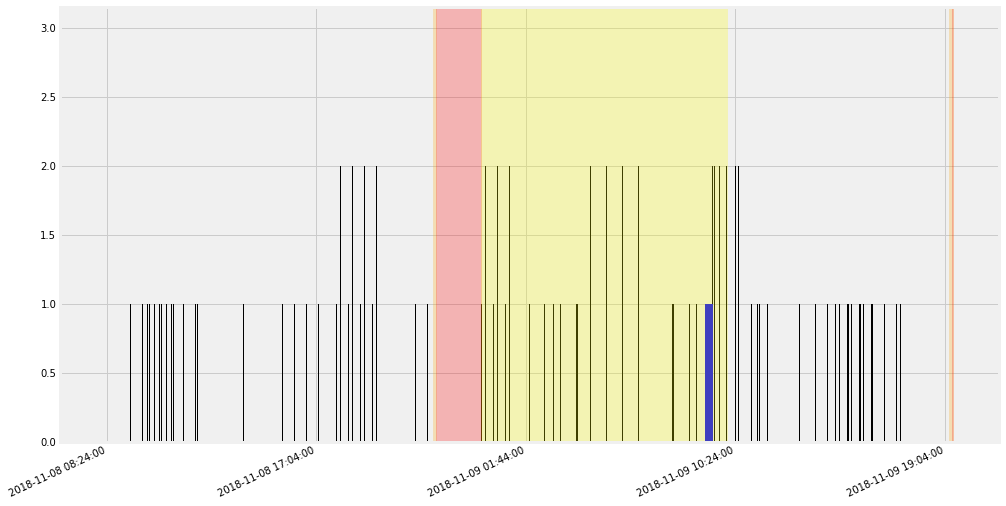

ZIP: 172202, Population: 28, Freq: 30, coverage: 0.57
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 31300}]


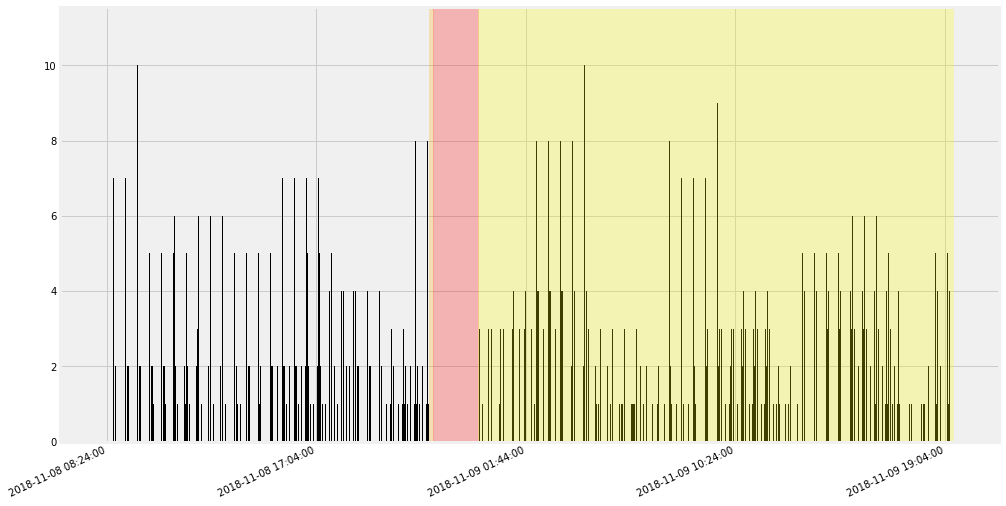

ZIP: 165021, Population: 71, Freq: 30, coverage: 0.97
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


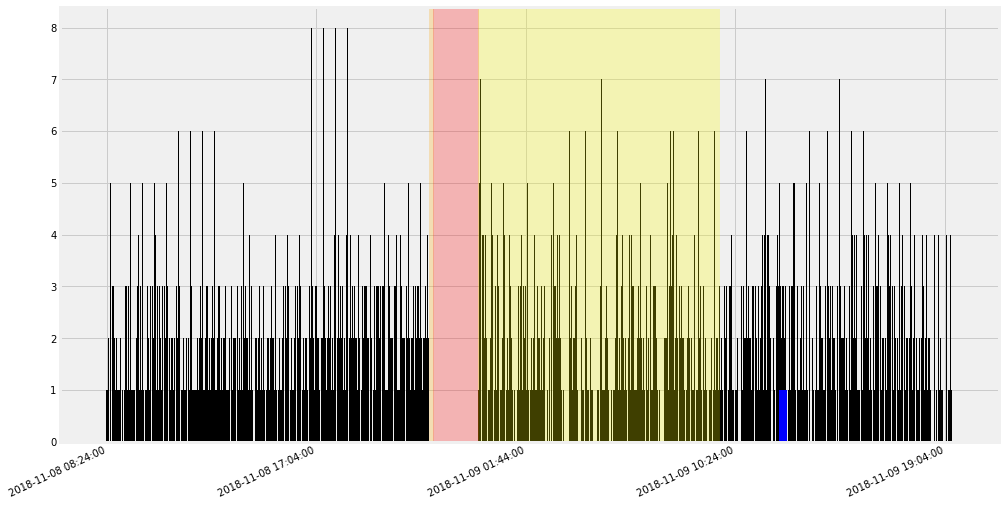

ZIP: 165962, Population: 4, Freq: 30, coverage: 0.13
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 134 minutes
cleared anomaly @ 2018-11-09 09:48:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 10:13:00 started @ 2018-11-09 10:04:00 (30749)
decline anomaly @ 2018-11-09 10:20:00 started @ 2018-11-09 10:04:00 idx:30756, len:16, thres:30
detected anomaly @ 2018-11-09 10:38:00 started @ 2018-11-09 10:29:00 (30774)
decline anomaly @ 2018-11-09 10:43:00 started @ 2018-11-09 10:29:00 idx:30779, len:14, thres:30
detected anomaly @ 2018-11-09 11:00:00 started @ 2018-11-09 10:51:00 (30796)
decline anomaly @ 2018-11-09 11:04:00 started @ 2018-11-09 10:51:00 idx:30800, len:13, thres:30
detected anomaly @ 2018-11-09 11:33:00 started @ 2018-11-09 11:24:00 (30829)
decline anomaly @ 20

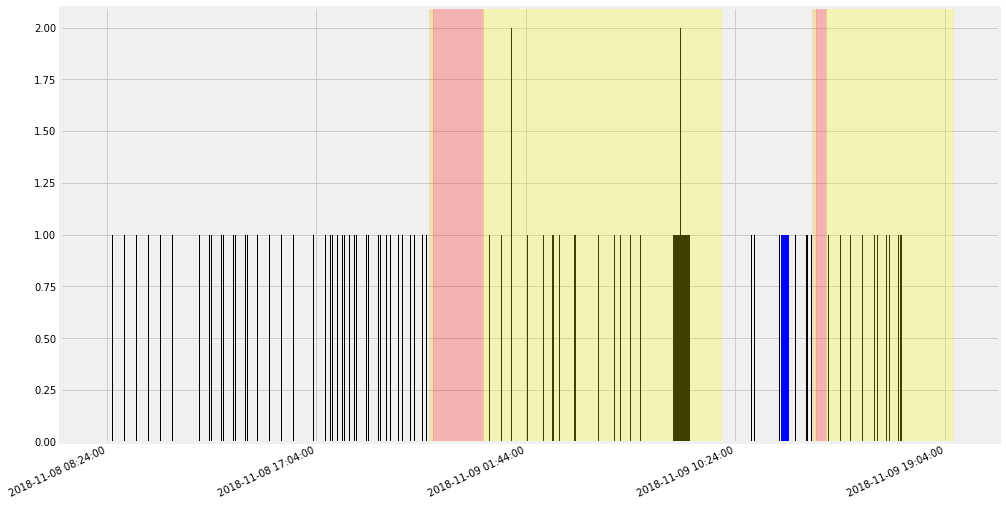

ZIP: 165951, Population: 49, Freq: 30, coverage: 0.83
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


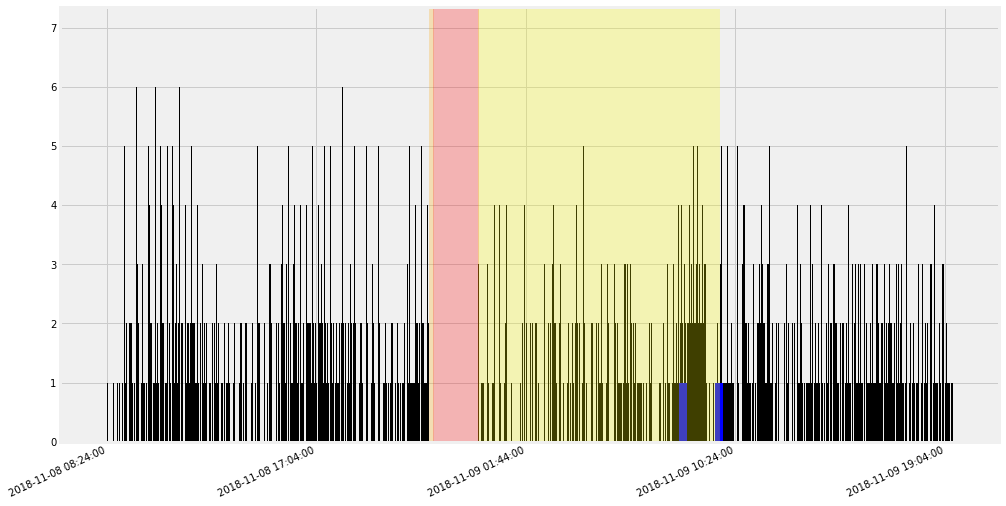

ZIP: 164673, Population: 118, Freq: 30, coverage: 0.93
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


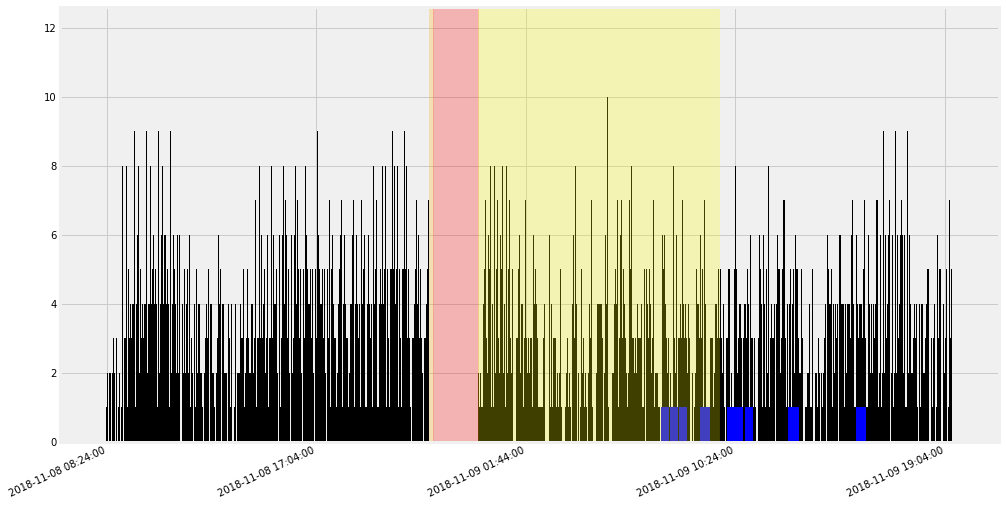

ZIP: 166271, Population: 14, Freq: 30, coverage: 0.4
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:49:00 started @ 2018-11-08 21:40:00 (30005)
end anomaly after 127 minutes
cleared anomaly @ 2018-11-09 09:40:00 started @ 2018-11-08 21:40:00
detected anomaly @ 2018-11-09 10:38:00 started @ 2018-11-09 10:29:00 (30774)
decline anomaly @ 2018-11-09 10:40:00 started @ 2018-11-09 10:29:00 idx:30776, len:11, thres:30
detected anomaly @ 2018-11-09 11:38:00 started @ 2018-11-09 11:29:00 (30834)
decline anomaly @ 2018-11-09 11:39:00 started @ 2018-11-09 11:29:00 idx:30835, len:10, thres:30
detected anomaly @ 2018-11-09 17:57:00 started @ 2018-11-09 17:48:00 (31213)
decline anomaly @ 2018-11-09 17:58:00 started @ 2018-11-09 17:48:00 idx:31214, len:10, thres:30
detected anomaly @ 2018-11-09 18:27:00 started @ 2018-11-09 18:18:00 (31243)
decline anomaly @ 20

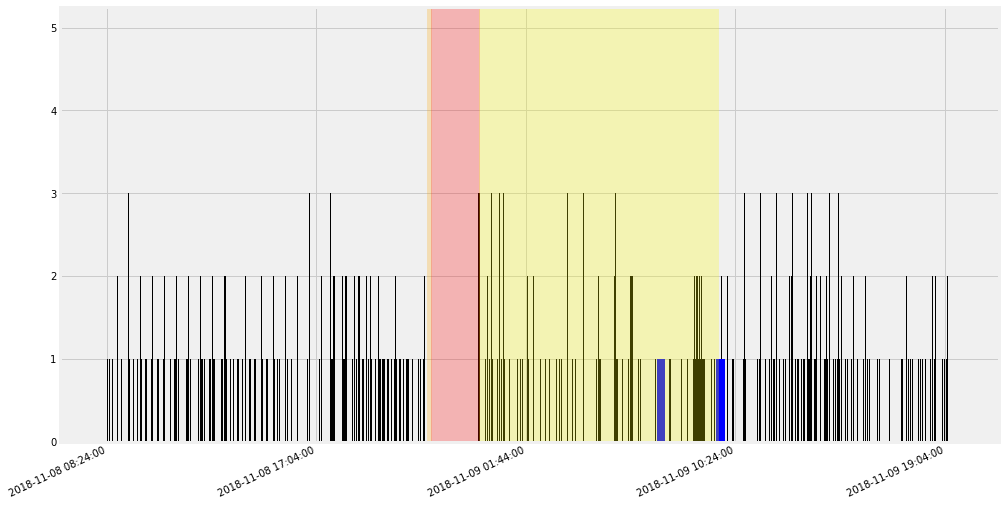

ZIP: 165938, Population: 7, Freq: 30, coverage: 0.17
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:58:00 started @ 2018-11-08 21:49:00 (30014)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 10:01:00 started @ 2018-11-08 21:49:00
detected anomaly @ 2018-11-09 10:30:00 started @ 2018-11-09 10:21:00 (30766)
decline anomaly @ 2018-11-09 10:33:00 started @ 2018-11-09 10:21:00 idx:30769, len:12, thres:30
detected anomaly @ 2018-11-09 10:59:00 started @ 2018-11-09 10:50:00 (30795)
decline anomaly @ 2018-11-09 11:00:00 started @ 2018-11-09 10:50:00 idx:30796, len:10, thres:30
detected anomaly @ 2018-11-09 11:23:00 started @ 2018-11-09 11:14:00 (30819)
decline anomaly @ 2018-11-09 11:29:00 started @ 2018-11-09 11:14:00 idx:30825, len:15, thres:30
detected anomaly @ 2018-11-09 11:54:00 started @ 2018-11-09 11:45:00 (30850)
decline anomaly @ 20

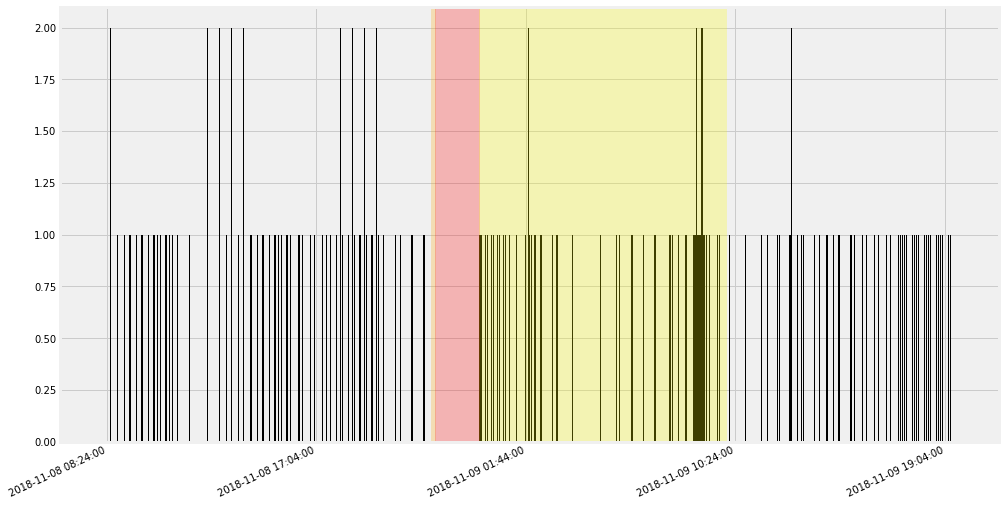

ZIP: 165220, Population: 1, Freq: 30, coverage: 0.03
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:02:00 started @ 2018-11-08 20:53:00 (29958)
decline anomaly @ 2018-11-08 21:22:00 started @ 2018-11-08 20:53:00 idx:29978, len:29, thres:30
detected anomaly @ 2018-11-08 21:32:00 started @ 2018-11-08 21:23:00 (29988)
end anomaly after 149 minutes
[{'start': 29979, 'detect': 29988, 'end': 30128, 'clear': 31300}]


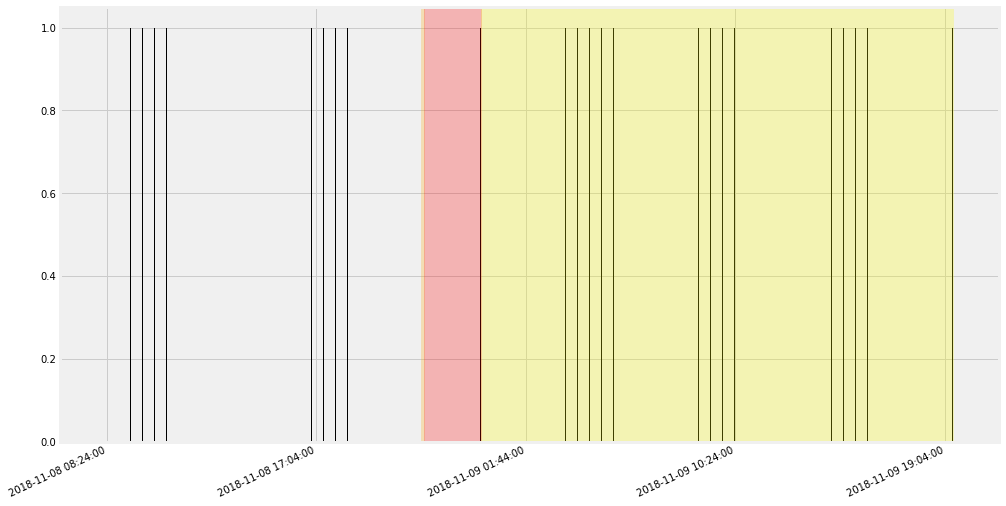

ZIP: 122060, Population: 3, Freq: 90, coverage: 0.03
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:14:00 started @ 2018-11-08 22:05:00 (30030)
end anomaly after 125 minutes
[{'start': 30021, 'detect': 30030, 'end': 30146, 'clear': 31300}]


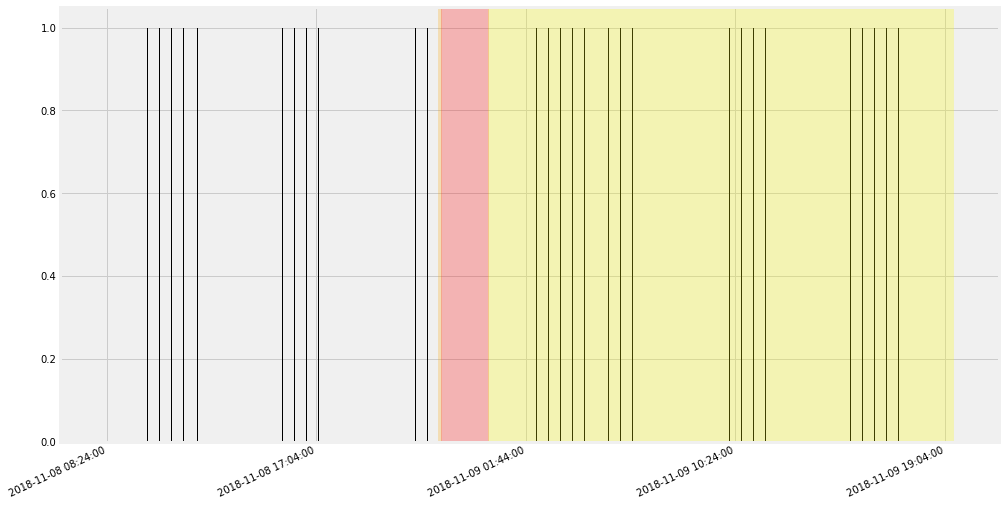

ZIP: 165421, Population: 149, Freq: 30, coverage: 0.97
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


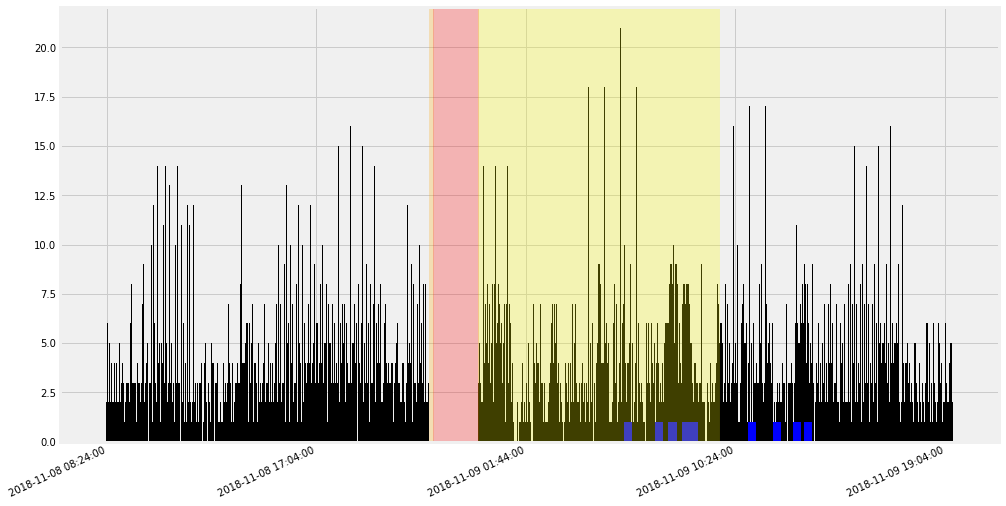

ZIP: 165845, Population: 14, Freq: 30, coverage: 0.27
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:54:00 started @ 2018-11-08 21:45:00 (30010)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 09:59:00 started @ 2018-11-08 21:45:00
detected anomaly @ 2018-11-09 11:24:00 started @ 2018-11-09 11:15:00 (30820)
decline anomaly @ 2018-11-09 11:25:00 started @ 2018-11-09 11:15:00 idx:30821, len:10, thres:30
detected anomaly @ 2018-11-09 11:54:00 started @ 2018-11-09 11:45:00 (30850)
decline anomaly @ 2018-11-09 11:58:00 started @ 2018-11-09 11:45:00 idx:30854, len:13, thres:30
detected anomaly @ 2018-11-09 13:24:00 started @ 2018-11-09 13:15:00 (30940)
decline anomaly @ 2018-11-09 13:25:00 started @ 2018-11-09 13:15:00 idx:30941, len:10, thres:30
[{'start': 30001, 'detect': 30010, 'end': 30121, 'clear': 30735}]


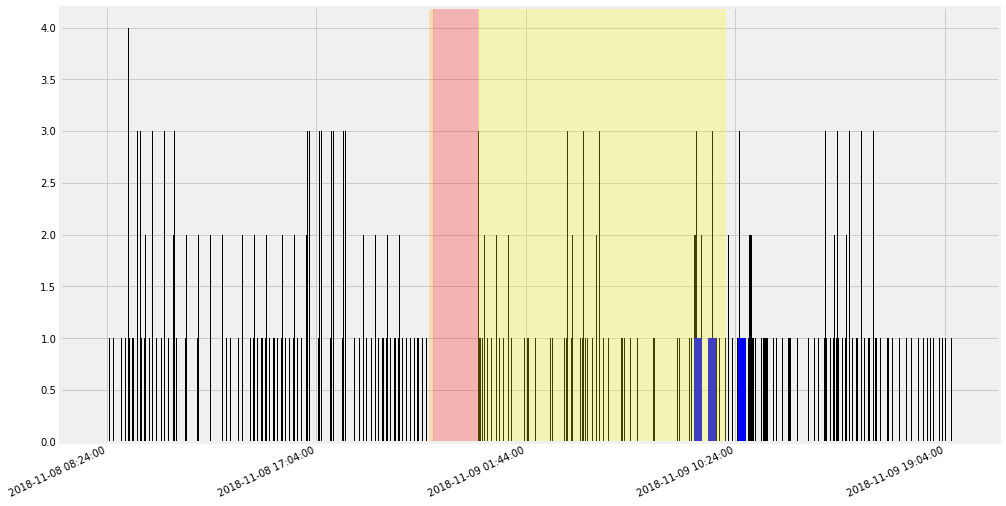

ZIP: 164638, Population: 4, Freq: 30, coverage: 0.13
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:57:00 started @ 2018-11-08 20:48:00 (29953)
decline anomaly @ 2018-11-08 20:58:00 started @ 2018-11-08 20:48:00 idx:29954, len:10, thres:30
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 124 minutes
[{'start': 29999, 'detect': 30008, 'end': 30123, 'clear': 31300}]


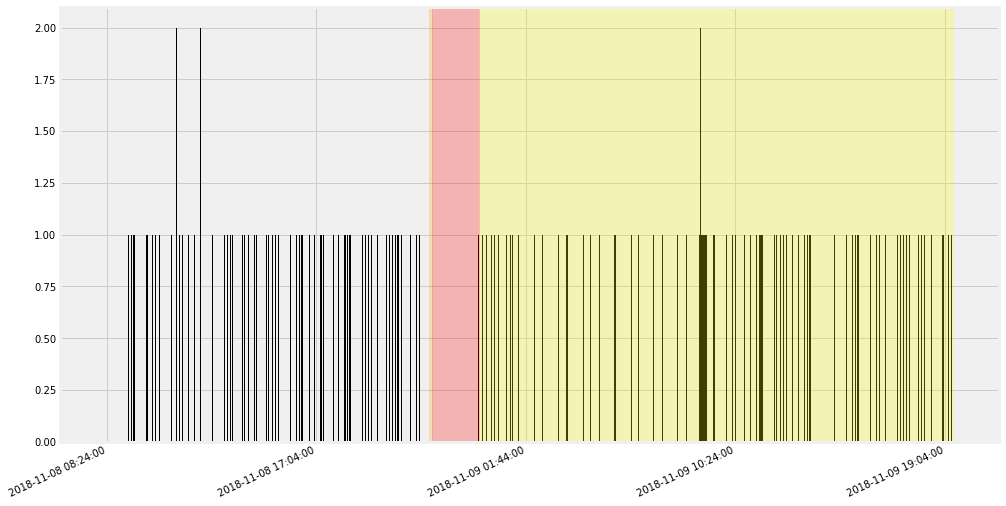

ZIP: 165858, Population: 33, Freq: 30, coverage: 0.63
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


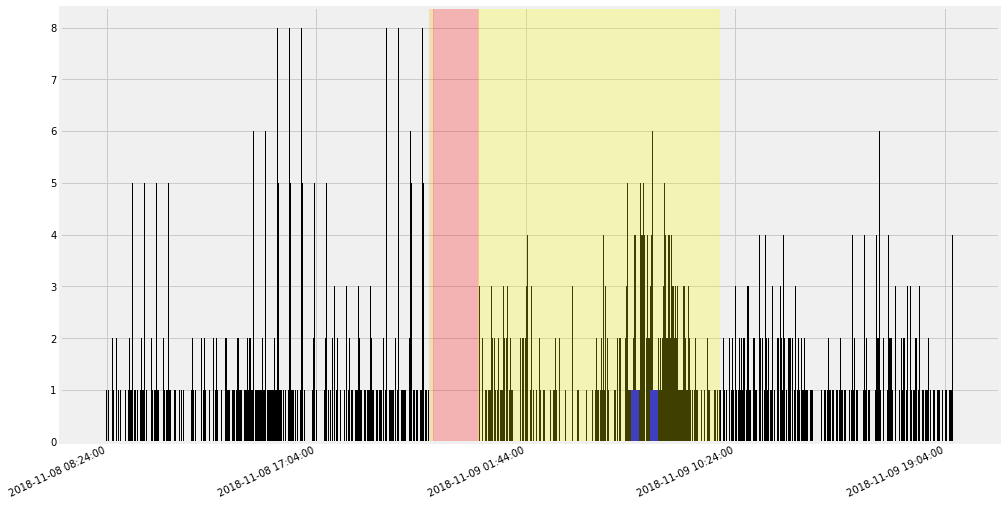

ZIP: 165124, Population: 2, Freq: 30, coverage: 0.07
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 22:06:00 started @ 2018-11-08 21:57:00 (30022)
end anomaly after 120 minutes
[{'start': 30013, 'detect': 30022, 'end': 30133, 'clear': 31300}]


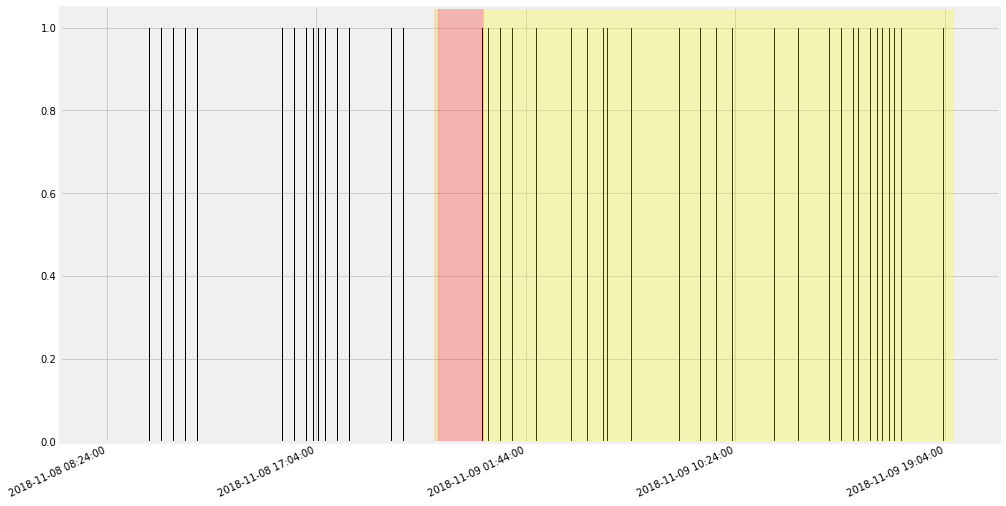

ZIP: 165019, Population: 12, Freq: 90, coverage: 0.13
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:48:00 started @ 2018-11-08 20:39:00 (29944)
decline anomaly @ 2018-11-08 20:54:00 started @ 2018-11-08 20:39:00 idx:29950, len:15, thres:30
detected anomaly @ 2018-11-08 21:18:00 started @ 2018-11-08 21:09:00 (29974)
decline anomaly @ 2018-11-08 21:24:00 started @ 2018-11-08 21:09:00 idx:29980, len:15, thres:30
detected anomaly @ 2018-11-08 21:48:00 started @ 2018-11-08 21:39:00 (30004)
end anomaly after 135 minutes
[{'start': 29995, 'detect': 30004, 'end': 30130, 'clear': 31300}]


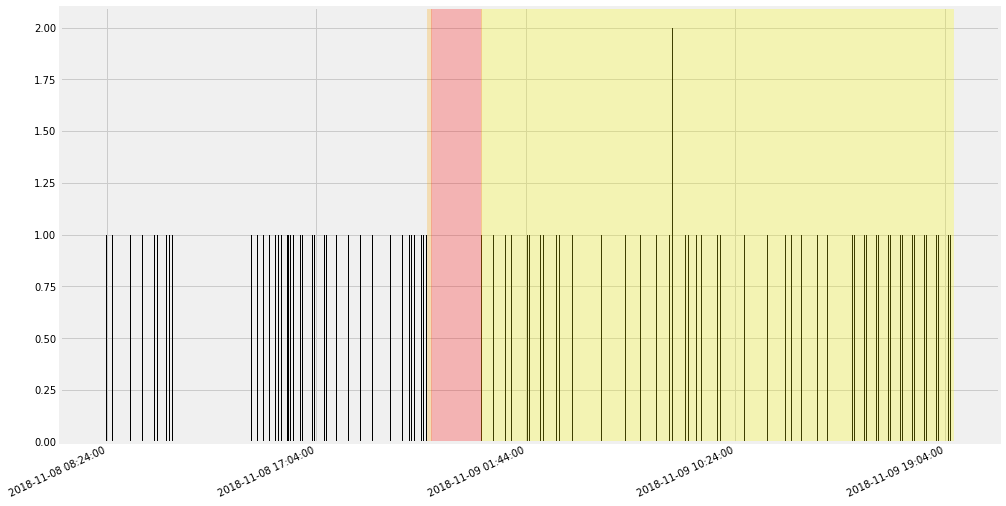

ZIP: 172567, Population: 46, Freq: 30, coverage: 0.6
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 31300}]


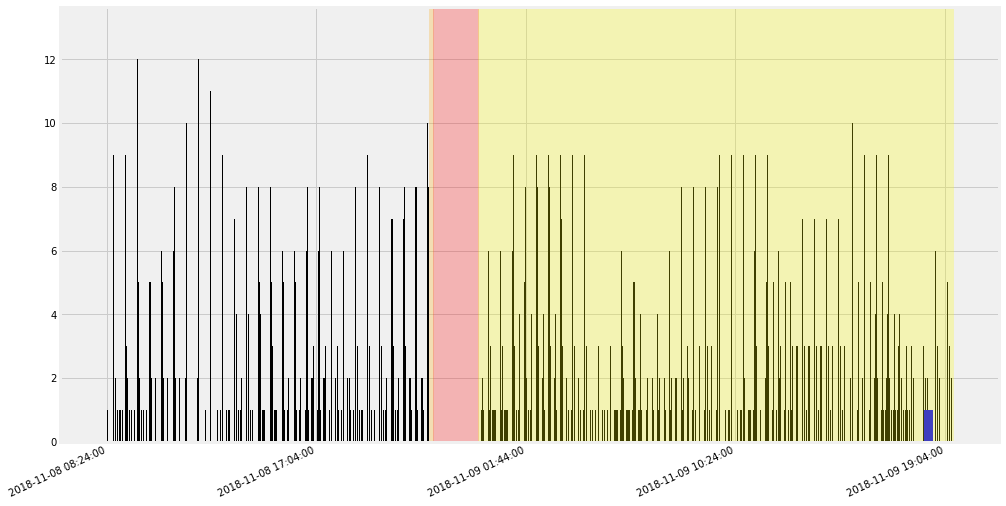

ZIP: 165467, Population: 70, Freq: 30, coverage: 0.87
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


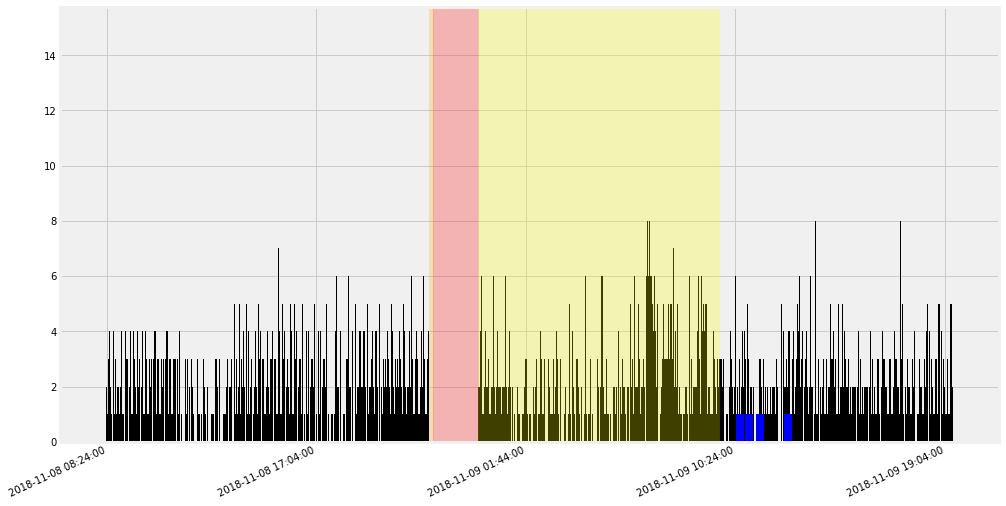

ZIP: 166379, Population: 19, Freq: 30, coverage: 0.5
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 18:56:00 started @ 2018-11-09 18:47:00 (31272)
decline anomaly @ 2018-11-09 18:59:00 started @ 2018-11-09 18:47:00 idx:31275, len:12, thres:30
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


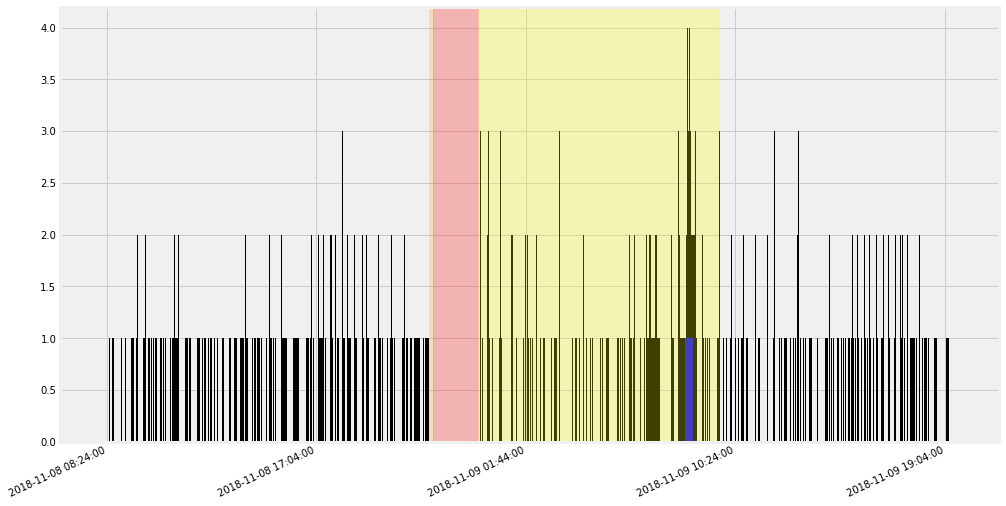

ZIP: 166279, Population: 213, Freq: 30, coverage: 1.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


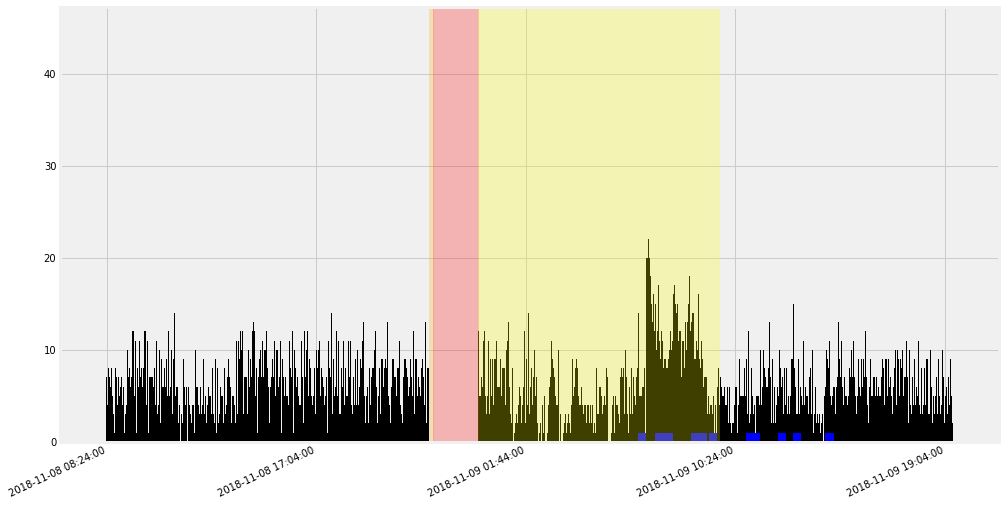

ZIP: 164637, Population: 119, Freq: 30, coverage: 0.87
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


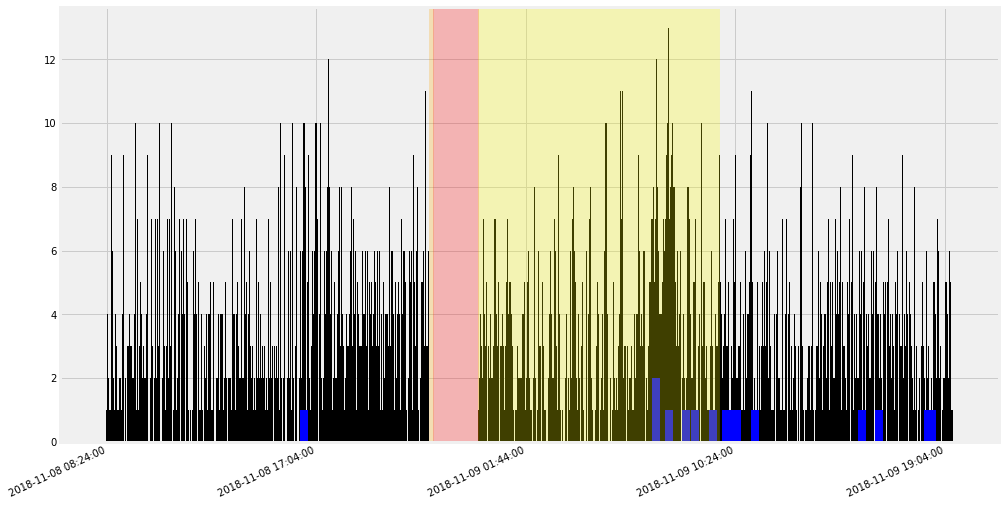

ZIP: 166076, Population: 62, Freq: 30, coverage: 0.87
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:45:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30122, 'clear': 30721}]


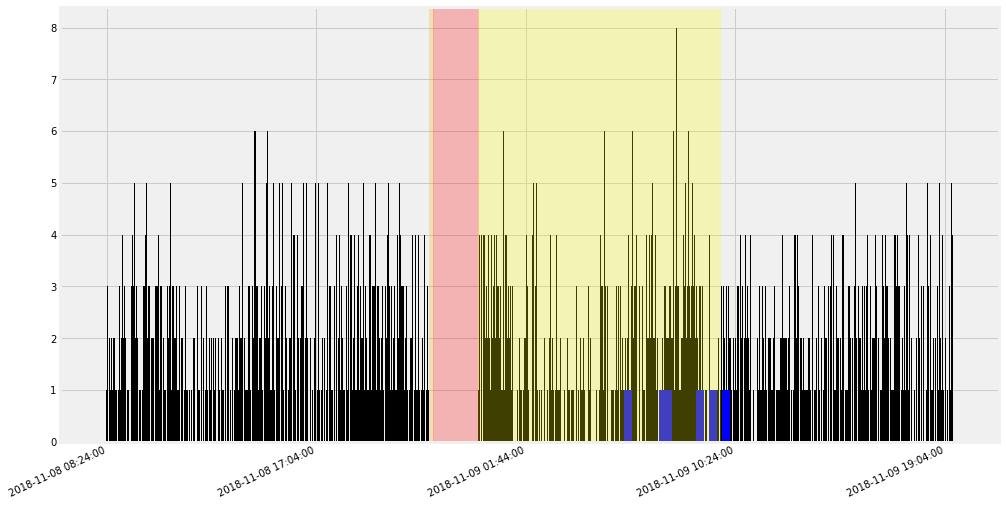

ZIP: 165867, Population: 13, Freq: 60, coverage: 0.18
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:55:00 started @ 2018-11-08 20:46:00 (29951)
decline anomaly @ 2018-11-08 21:02:00 started @ 2018-11-08 20:46:00 idx:29958, len:16, thres:30
detected anomaly @ 2018-11-08 21:25:00 started @ 2018-11-08 21:16:00 (29981)
decline anomaly @ 2018-11-08 21:30:00 started @ 2018-11-08 21:16:00 idx:29986, len:14, thres:30
detected anomaly @ 2018-11-08 21:51:00 started @ 2018-11-08 21:42:00 (30007)
end anomaly after 123 minutes
cleared anomaly @ 2018-11-09 09:53:00 started @ 2018-11-08 21:42:00
detected anomaly @ 2018-11-09 10:14:00 started @ 2018-11-09 10:05:00 (30750)
end anomaly after 33 minutes
[{'start': 29998, 'detect': 30007, 'end': 30121, 'clear': 30729}, {'start': 30741, 'detect': 30750, 'end': 30774, 'clear': 31300}]


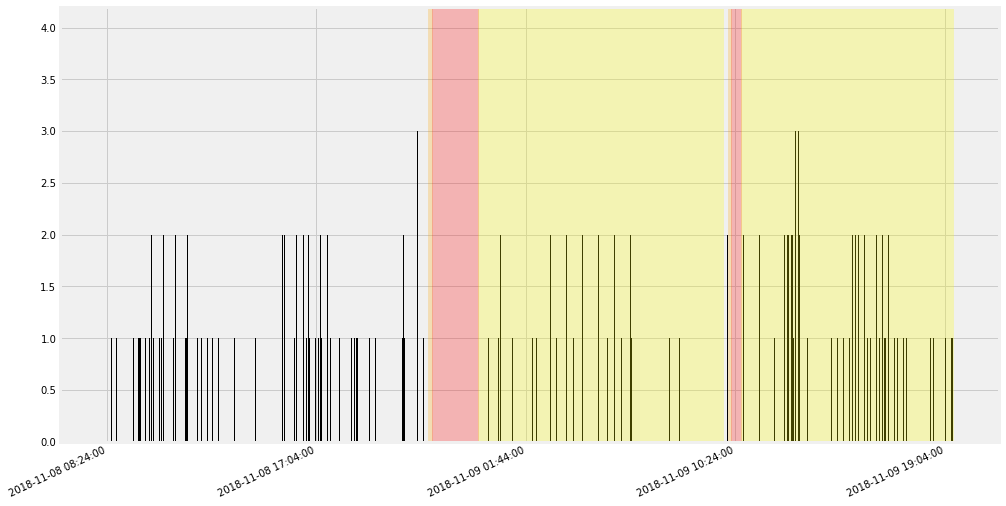

ZIP: 165958, Population: 2, Freq: 30, coverage: 0.07
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:51:00 started @ 2018-11-08 20:42:00 (29947)
decline anomaly @ 2018-11-08 21:04:00 started @ 2018-11-08 20:42:00 idx:29960, len:22, thres:30
detected anomaly @ 2018-11-08 21:21:00 started @ 2018-11-08 21:12:00 (29977)
decline anomaly @ 2018-11-08 21:34:00 started @ 2018-11-08 21:12:00 idx:29990, len:22, thres:30
detected anomaly @ 2018-11-08 21:51:00 started @ 2018-11-08 21:42:00 (30007)
end anomaly after 141 minutes
[{'start': 29998, 'detect': 30007, 'end': 30139, 'clear': 31300}]


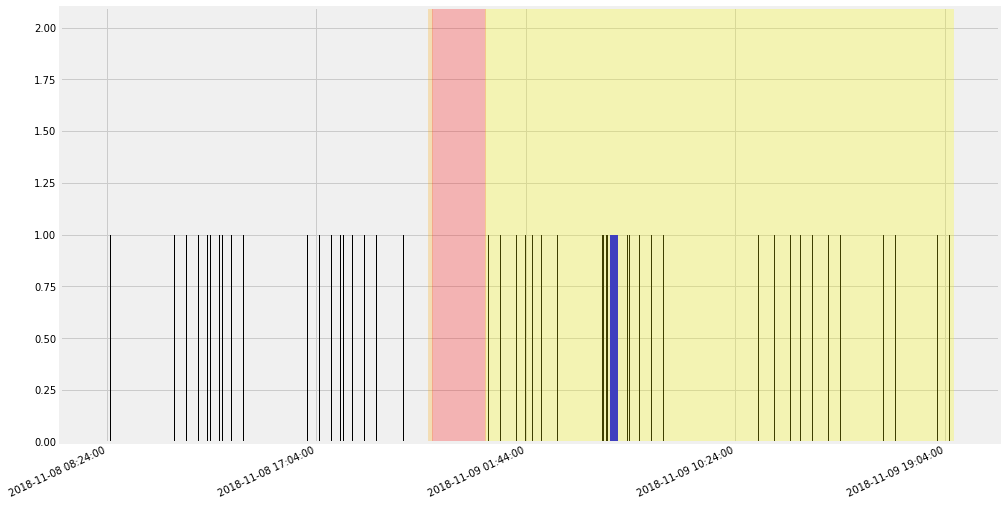

ZIP: 165887, Population: 61, Freq: 30, coverage: 0.93
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30122, 'clear': 30720}]


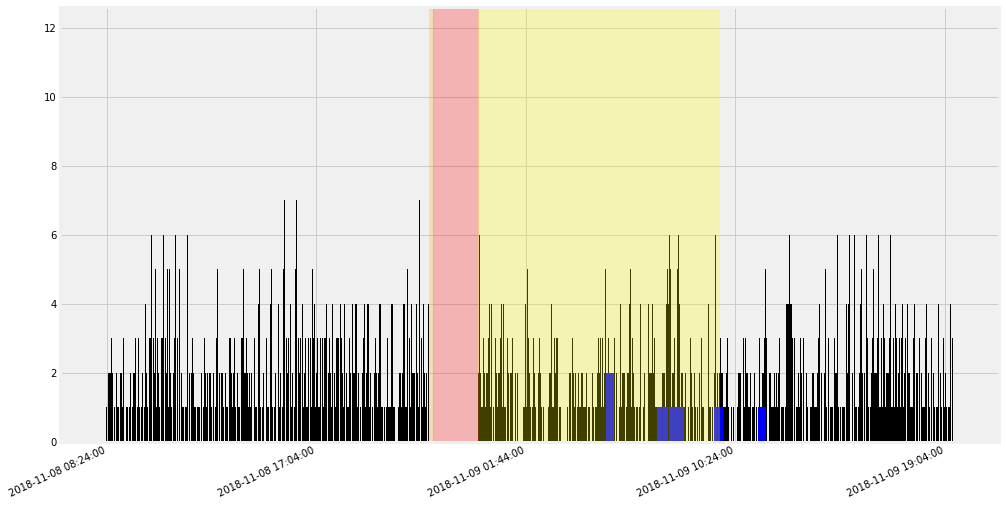

ZIP: 166273, Population: 123, Freq: 30, coverage: 1.0
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


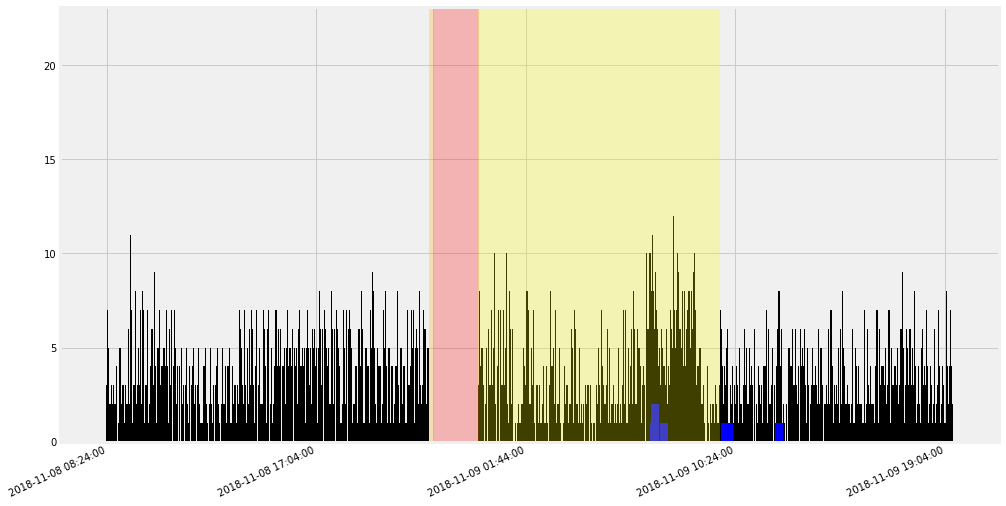

ZIP: 165960, Population: 12, Freq: 30, coverage: 0.4
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:36:00 started @ 2018-11-08 20:27:00 (29932)
decline anomaly @ 2018-11-08 20:39:00 started @ 2018-11-08 20:27:00 idx:29935, len:12, thres:30
detected anomaly @ 2018-11-08 21:06:00 started @ 2018-11-08 20:57:00 (29962)
decline anomaly @ 2018-11-08 21:09:00 started @ 2018-11-08 20:57:00 idx:29965, len:12, thres:30
detected anomaly @ 2018-11-08 21:36:00 started @ 2018-11-08 21:27:00 (29992)
decline anomaly @ 2018-11-08 21:39:00 started @ 2018-11-08 21:27:00 idx:29995, len:12, thres:30
detected anomaly @ 2018-11-08 21:54:00 started @ 2018-11-08 21:45:00 (30010)
end anomaly after 120 minutes
cleared anomaly @ 2018-11-09 09:46:00 started @ 2018-11-08 21:45:00
detected anomaly @ 2018-11-09 10:00:00 started @ 2018-11-09 09:51:00 (30736)
decline anomaly @ 20

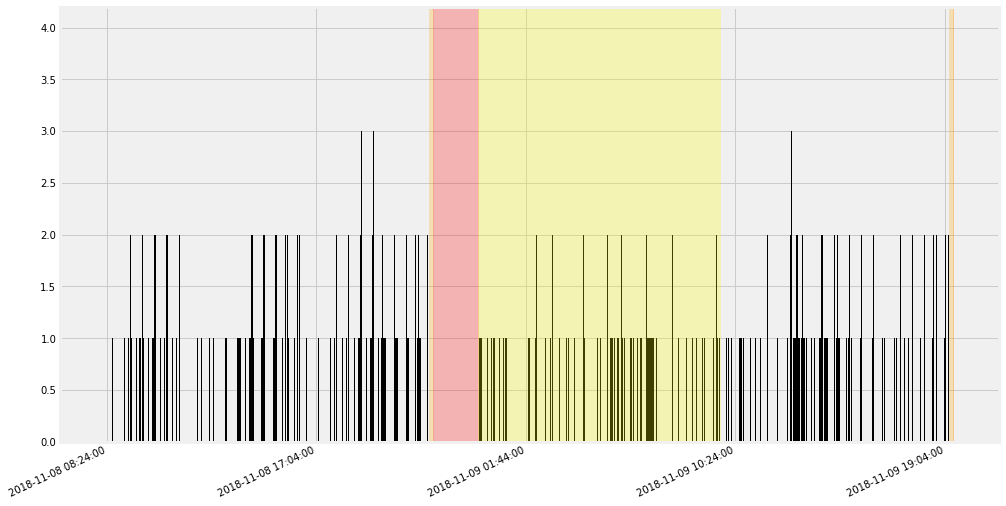

ZIP: 165856, Population: 14, Freq: 30, coverage: 0.33
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 10:29:00 started @ 2018-11-09 10:20:00 (30765)
decline anomaly @ 2018-11-09 10:31:00 started @ 2018-11-09 10:20:00 idx:30767, len:11, thres:30
detected anomaly @ 2018-11-09 11:24:00 started @ 2018-11-09 11:15:00 (30820)
decline anomaly @ 2018-11-09 11:31:00 started @ 2018-11-09 11:15:00 idx:30827, len:16, thres:30
detected anomaly @ 2018-11-09 12:29:00 started @ 2018-11-09 12:20:00 (30885)
decline anomaly @ 2018-11-09 12:31:00 started @ 2018-11-09 12:20:00 idx:30887, len:11, thres:30
detected anomaly @ 2018-11-09 13:24:00 started @ 2018-11-09 13:15:00 (30940)
decline anomaly @ 2

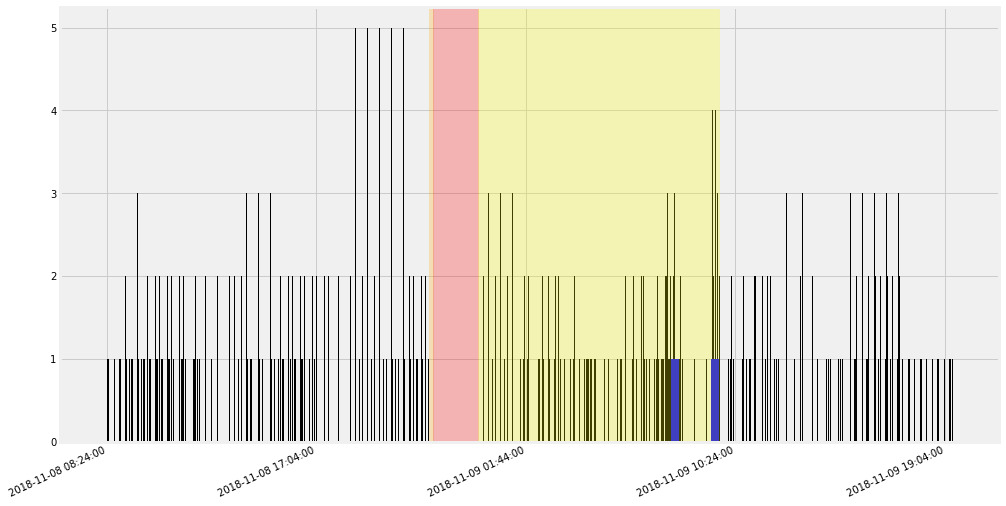

ZIP: 165459, Population: 75, Freq: 30, coverage: 0.97
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30122, 'clear': 30720}]


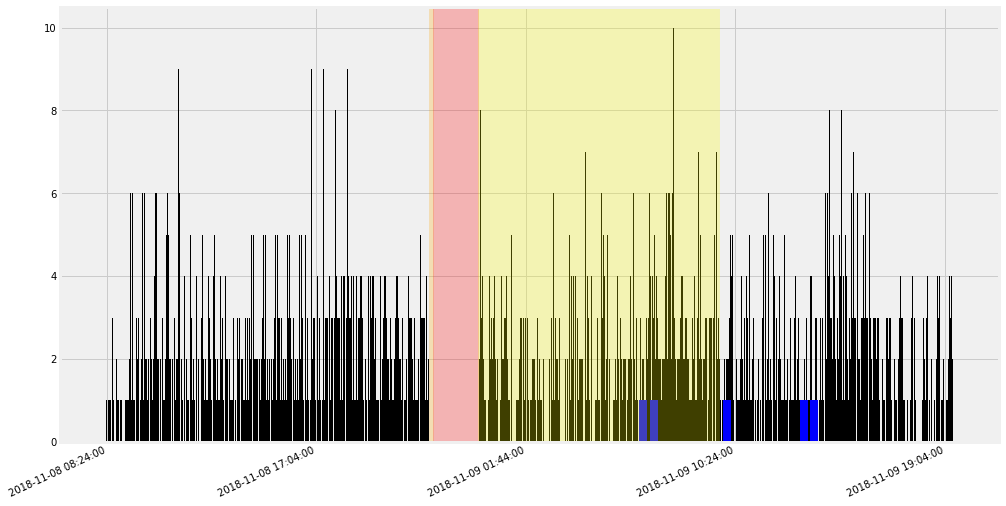

ZIP: 164769, Population: 25, Freq: 30, coverage: 0.5
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:52:00 started @ 2018-11-08 21:43:00 (30008)
end anomaly after 122 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:43:00
[{'start': 29999, 'detect': 30008, 'end': 30121, 'clear': 30720}]


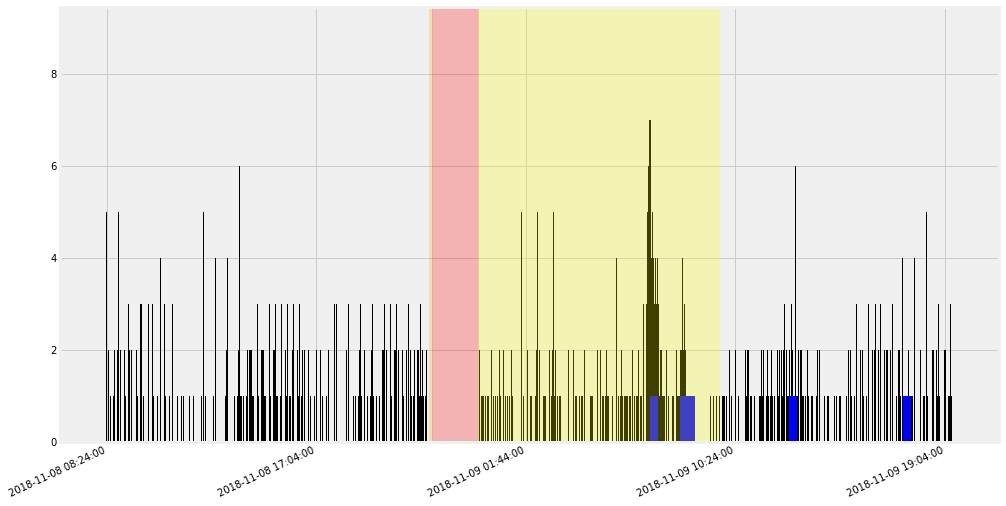

ZIP: 166061, Population: 8, Freq: 60, coverage: 0.13
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 126 minutes
cleared anomaly @ 2018-11-09 11:30:00 started @ 2018-11-08 21:44:00
detected anomaly @ 2018-11-09 11:44:00 started @ 2018-11-09 11:35:00 (30840)
decline anomaly @ 2018-11-09 11:50:00 started @ 2018-11-09 11:35:00 idx:30846, len:15, thres:30
detected anomaly @ 2018-11-09 12:00:00 started @ 2018-11-09 11:51:00 (30856)
decline anomaly @ 2018-11-09 12:10:00 started @ 2018-11-09 11:51:00 idx:30866, len:19, thres:30
detected anomaly @ 2018-11-09 12:20:00 started @ 2018-11-09 12:11:00 (30876)
decline anomaly @ 2018-11-09 12:32:00 started @ 2018-11-09 12:11:00 idx:30888, len:21, thres:30
detected anomaly @ 2018-11-09 12:43:00 started @ 2018-11-09 12:34:00 (30899)
decline anomaly @ 20

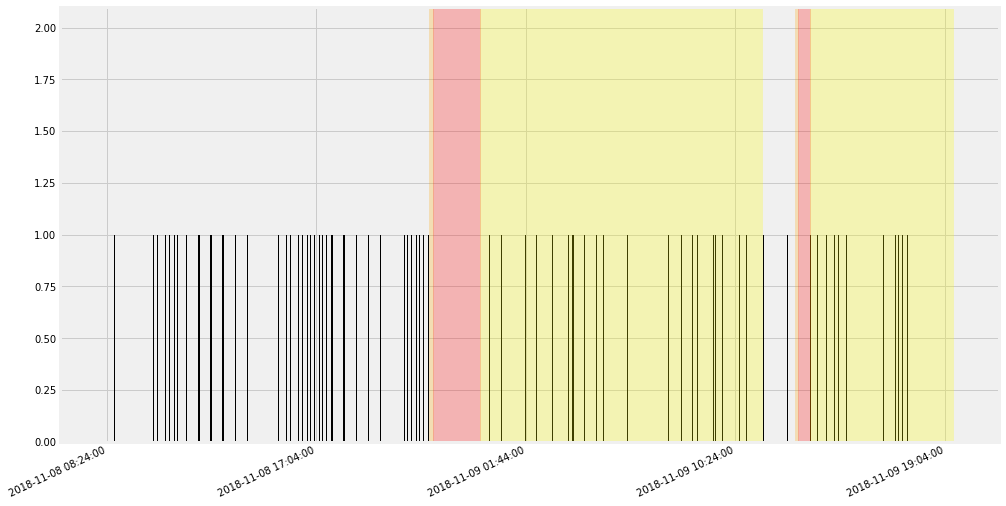

ZIP: 165864, Population: 3, Freq: 30, coverage: 0.1
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 20:46:00 started @ 2018-11-08 20:37:00 (29942)
decline anomaly @ 2018-11-08 20:50:00 started @ 2018-11-08 20:37:00 idx:29946, len:13, thres:30
detected anomaly @ 2018-11-08 21:16:00 started @ 2018-11-08 21:07:00 (29972)
decline anomaly @ 2018-11-08 21:29:00 started @ 2018-11-08 21:07:00 idx:29985, len:22, thres:30
detected anomaly @ 2018-11-08 21:46:00 started @ 2018-11-08 21:37:00 (30002)
end anomaly after 142 minutes
[{'start': 29993, 'detect': 30002, 'end': 30135, 'clear': 31300}]


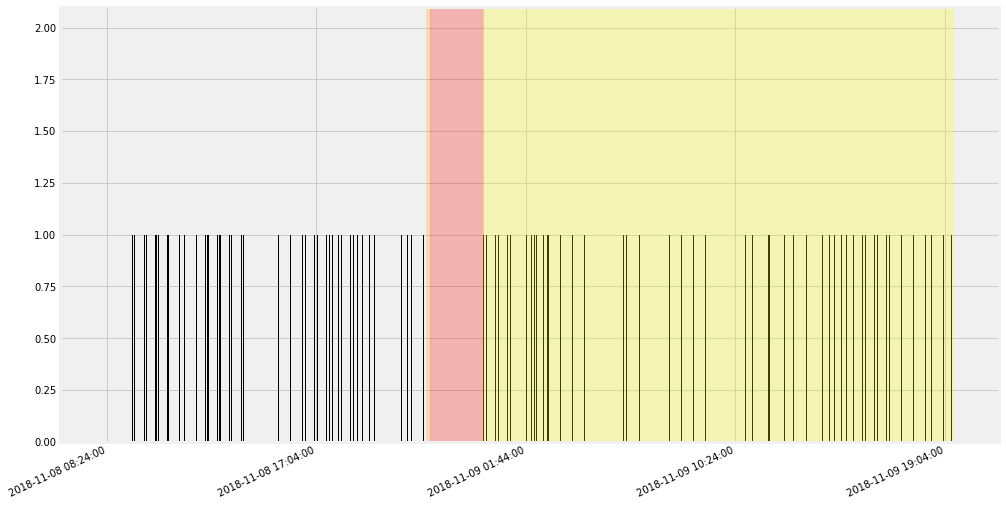

ZIP: 164990, Population: 94, Freq: 30, coverage: 0.67
Simulating dhcp requests outage @ 2018-11-08 21:44:00, clearing 2018-11-08 23:44:00
index0:29200, lookbehind:720, len(data):2100
processing 29920, 31300, 1
detected anomaly @ 2018-11-08 21:53:00 started @ 2018-11-08 21:44:00 (30009)
end anomaly after 121 minutes
cleared anomaly @ 2018-11-09 09:44:00 started @ 2018-11-08 21:44:00
[{'start': 30000, 'detect': 30009, 'end': 30121, 'clear': 30720}]


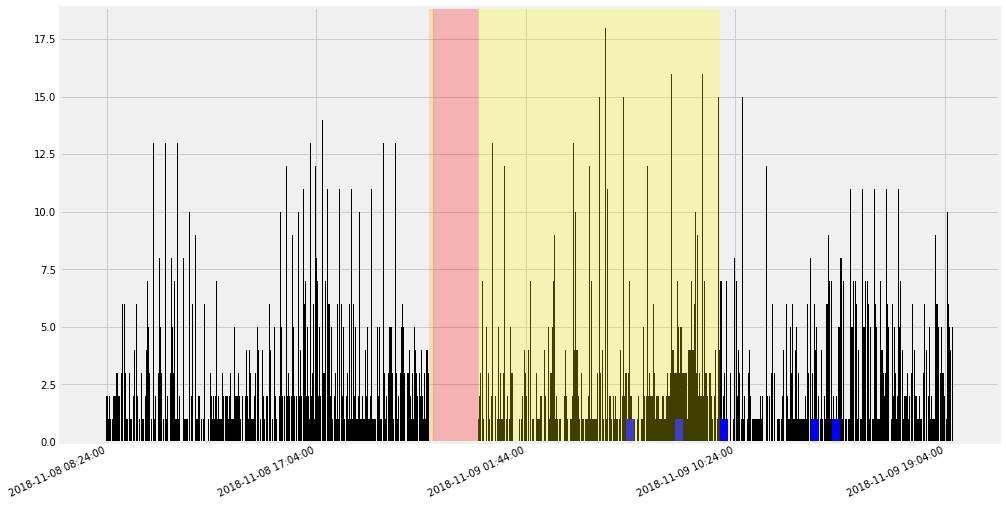

In [64]:

# Replay params
sm = 29200 # start minute
em = 31300 # end minute
l = em - sm # length
# 35h 

# generated complete 2h outage
outage_start = 30000 
outage_end = 30120  

sample_start = 25600 # arbitrary

coverage_delay = []

for zipcode in sparse_data['zip'].unique():

    d = sparse_data[sparse_data['zip'] == zipcode].copy().reset_index()
    
    mean_dhcp = d.dhcp.mean()
    freq = min_std_interval( np.array( d[sm:em].dhcp.copy() ) )
    
    sum_dhcp = d[sample_start:sample_start+freq].dhcp.sum()

    max_calls = d.call.max()
    
    coverage = np.round( np.sum( d[sample_start:sample_start+freq].dhcp > 0 ) / freq, 2 )
    
    print("ZIP: {}, Population: {}, Freq: {}, coverage: {}".format( zipcode, sum_dhcp, freq, coverage ))

    generate_total_outage_dhcp(d, outage_start, outage_end)
    events = replay_moving_average(d[sm:em])

    print(events)
    
    # record the count, coverage, delay
    success = [ e['detect'] - outage_start for e in events if e['detect'] > outage_start & e['detect'] < outage_end ]
    mean_delay = success[0] if len(success) > 0 else None
    coverage_delay.append([sum_dhcp, coverage, mean_delay])

    #graph simulated period inkl spans for prior, active and post detection  
    plt.figure(figsize=(15, 8))
    plt.bar( range(0,len(d[sm:em])), d.dhcp[sm:em], width=1, color='black'  )
    plt.bar( range(0,len(d[sm:em])), d.call[sm:em], width=20, color='blue')
    for e in events:
        plt.axvspan(e['start']-sm,  e['detect']-sm,   alpha=0.25, color='orange')
        plt.axvspan(e['detect']-sm, e['end']-sm,   alpha=0.25, color='red') 
        plt.axvspan(e['end']-sm,    e['clear']-sm, alpha=0.25, color='yellow')

    plt.xticks( range(0,l,520), pd.to_datetime(d.ts[sm:em:520],unit='s') ) 
    plt.xticks( rotation=25, ha='right' )
    plt.show()


(-5, 200)

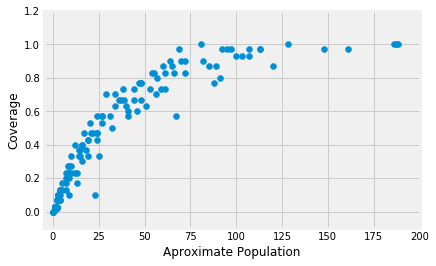

In [59]:
reg = plt.scatter(np.array(coverage_delay).T[0],np.array(coverage_delay).T[1])
plt.ylabel("Coverage")
plt.ylim(-.1,1.2)
plt.xlabel("Aproximate Population")
plt.xlim(-5,200)

(0, 150)

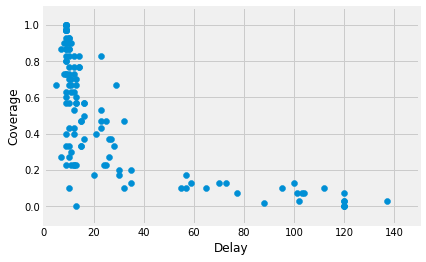

In [46]:
reg = plt.scatter(np.array(coverage_delay).T[2],np.array(coverage_delay).T[1])
plt.ylabel("Coverage")
plt.ylim(-.1,1.1)
plt.xlabel("Delay")
plt.xlim(0,150)

(-5, 200)

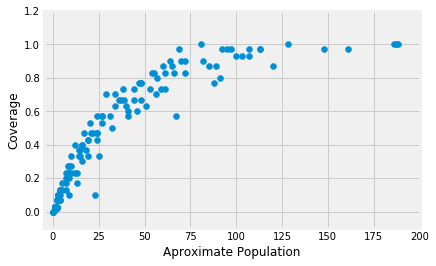

In [37]:
reg = plt.scatter(np.array(coverage_delay).T[0],np.array(coverage_delay).T[1])
plt.ylabel("Coverage")
plt.ylim(-.1,1.2)
plt.xlabel("Aproximate Population")
plt.xlim(-5,200)

In [38]:
stats.pearsonr(np.array(coverage_delay).T[0],np.array(coverage_delay).T[1])

(0.5076040932656558, 1.3258087978998335e-10)

(0, 150)

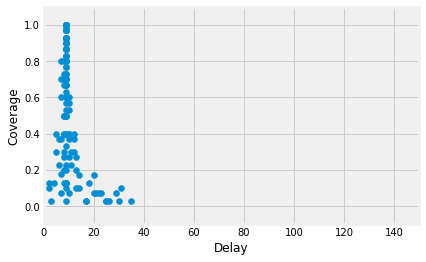

In [65]:
reg = plt.scatter(np.array(coverage_delay).T[2],np.array(coverage_delay).T[1])
plt.ylabel("Coverage")
plt.ylim(-.1,1.1)
plt.xlabel("Delay")
plt.xlim(0,150)